In [1]:
import os
# import pdfplumber
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("pdfminer").setLevel(logging.ERROR)
import docx
from collections import defaultdict
from docx.table import _Cell
from docx.oxml.table import CT_Tbl
from docx.oxml.text.paragraph import CT_P
import yaml
import json
import shutil
import glob

import importlib
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from scipy.stats import pearsonr
from pandas.plotting import table
from scipy.interpolate import interp1d
from scipy.stats import ttest_ind
import networkx as nx
import sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import openai
from openai import OpenAI
import time
import math
# openai.api_key=os.getenv('OPENAI_API_KEY')

openai.api_key = API_KEY
openai.organization = FLORA_OPENAI_ORGANIZATION
openai.project = PROJECT_ID


client = OpenAI(api_key = openai.api_key, organization = openai.organization, project = openai.project)
# client = OpenAI(api_key = openai.api_key)
safety_settings = { "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE" }, { "category": "HARM_CATEGORY_HATE_SPEECH" , "threshold": "BLOCK_NONE" },{ "category": "HARM_CATEGORY_HARASSMENT" , "threshold": "BLOCK_NONE" },{ "category": "HARM_CATEGORY_DANGEROUS_CONTENT" , "threshold": "BLOCK_NONE" }
max_attempts = 10  # 最大尝试次数
attempts = 0


from google import genai
from google.genai import types


NameError: name 'API_KEY' is not defined

In [3]:
# # 要遍历的根目录
# target_folder = r"C:\Users\kqia0008\D\Dean\Data\FIT2021 S1"
# # 要删除的字符串
# target_str = "assignsubmission_file_"

# def remove_str_from_filenames(root_dir: str, target_str: str) -> None:
#     """
#     递归遍历 root_dir 下所有子目录，删除文件名中所有指定字符串。
#     :param root_dir: 要遍历的根目录
#     :param target_str: 要从文件名中删除的字符串
#     """
#     for dirpath, dirnames, filenames in os.walk(root_dir):
#         for filename in filenames:
#             if target_str in filename:
#                 old_path = os.path.join(dirpath, filename)
#                 new_filename = filename.replace(target_str, "")
#                 new_path = os.path.join(dirpath, new_filename)
#                 # 如果目标文件已存在，可选择覆盖或跳过
#                 if os.path.exists(new_path):
#                     print(f"目标文件已存在，跳过重命名: {new_path}")
#                     continue
#                 os.rename(old_path, new_path)
# #                 print(f"已重命名: {old_path} -> {new_path}")

# remove_str_from_filenames(target_folder, target_str)

In [15]:
class EnhancedPDFProcessor:
    def __init__(self, filepath):
        self.filepath = filepath
        self.pdf = pdfplumber.open(filepath)
        self.all_text = []
        self.current_page = 0
    
    def drop_empty_cols(self, data):
        """Remove completely empty columns"""
        if not data or len(data) == 0:
            return data
        
        transposed_data = list(map(list, zip(*data)))
        filtered_data = [col for col in transposed_data if not all(cell == '' or cell is None for cell in col)]
        
        if not filtered_data:
            return data
            
        result = list(map(list, zip(*filtered_data)))
        return result
    
    def process_table(self, table):
        """Process tables, merge cells and optimize structure"""
        if not table:
            return []
            
        # Extract table data
        table_data = table.extract()
        
        # Process cells spanning multiple rows
        r_count = 0
        for r in range(len(table_data)):
            row = table_data[r]
            if row[0] is None:
                r_count += 1
                for c in range(len(row)):
                    if row[c] is not None and row[c] not in ['', ' ']:
                        if r - r_count >= 0 and c < len(table_data[r - r_count]):
                            if table_data[r - r_count][c] is None:
                                table_data[r - r_count][c] = row[c]
                            else:
                                table_data[r - r_count][c] += ' ' + row[c]
                        row[c] = None
            else:
                r_count = 0
        
        # Remove empty rows and clean data
        result_table = []
        for row in table_data:
            if row[0] is not None:
                cell_list = []
                cell_check = False
                for cell in row:
                    if cell is not None:
                        cell = cell.replace('\n', ' ')
                    else:
                        cell = ''
                    if cell != '':
                        cell_check = True
                    cell_list.append(cell)
                if cell_check:
                    result_table.append(cell_list)
        
        # Remove empty columns
        result_table = self.drop_empty_cols(result_table)
        return result_table
    
    def format_table_as_text(self, table_data):
        """Format table data as text using | as separator"""
        if not table_data:
            return ""
        
        table_text = ""
        for row in table_data:
            row_text = " | ".join([str(cell).strip() if cell else "" for cell in row])
            table_text += row_text + "\n"
        
        return table_text
    
    def extract_text_between_tables(self, page, top=None, bottom=0):
        """Extract text between tables"""
        # Use extract_words for more precise text positioning
        words = page.extract_words(x_tolerance=3, y_tolerance=3)
        text_lines = []
        current_line = ""
        last_top = -1
        
        for word in words:
            # Filter by position
            if (top is None or word['top'] < top) and word['top'] > bottom:
                # If y position is close, consider as same line
                if abs(last_top - word['top']) <= 3 and last_top != -1:
                    current_line += " " + word['text']
                else:
                    if current_line:
                        text_lines.append(current_line)
                    current_line = word['text']
                last_top = word['top']
        
        if current_line:
            text_lines.append(current_line)
            
        return text_lines
    
    def process_page(self, page):
        """Process a single page: extract tables and text"""
        page_content = []
        bottom = 0
        
        # Find all tables in the page
        tables = page.find_tables()
        
        if tables:
            # Sort tables by vertical position
            tables.sort(key=lambda t: t.bbox[1])
            
            for table in tables:
                # Extract text above the table
                top = table.bbox[1]
                text_lines = self.extract_text_between_tables(page, top, bottom)
                for line in text_lines:
                    if line.strip():
                        page_content.append({"type": "text", "content": line.strip()})
                
                # Process the table
                processed_table = self.process_table(table)
                if processed_table:
                    table_text = self.format_table_as_text(processed_table)
                    page_content.append({"type": "table", "content": table_text})
                
                # Update bottom position
                bottom = table.bbox[3]
            
            # Extract text below the last table
            text_lines = self.extract_text_between_tables(page, None, bottom)
            for line in text_lines:
                if line.strip():
                    page_content.append({"type": "text", "content": line.strip()})
        else:
            # If page has no tables, extract all text
            text = page.extract_text(x_tolerance=3, y_tolerance=3)
            if text:
                for line in text.split('\n'):
                    if line.strip():
                        page_content.append({"type": "text", "content": line.strip()})
        
        return page_content
    
    def process_pdf(self):
        """Process the entire PDF"""
        all_content = []
        
        for i, page in enumerate(self.pdf.pages):
#             print(f"Processing page {i+1} of {len(self.pdf.pages)}")
            page_content = self.process_page(page)
            
            # Add page marker
            all_content.append({"type": "page_marker", "content": f"{'='*20} Page {i+1} {'='*20}"})
            
            # Add page content
            all_content.extend(page_content)
            
        return all_content
    
    def save_to_txt(self, output_path):
        """Save processed content to TXT file"""
        contents = self.process_pdf()
        
        with open(output_path, 'w', encoding='utf-8') as file:
            for item in contents:
                if item["type"] == "page_marker":
                    file.write(f"\n\n{item['content']}\n\n")
                elif item["type"] == "text":
                    file.write(f"{item['content']}\n")
                elif item["type"] == "table":
                    file.write(f"\n// The following is converted from a table\n")
                    file.write(item['content'])
                    file.write(f"\n")
        
        return output_path

# Batch processing function
def process_pdf_folder(source_folder, target_folder):
    """Process all PDF files in a folder and convert to TXT"""
    # Create target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    # Iterate through all files in source folder
    processed_files = 0
    for filename in os.listdir(source_folder):
        if filename.endswith(".pdf"):
            # Build complete file paths
            file_path = os.path.join(source_folder, filename)
            txt_file_path = os.path.join(target_folder, filename.replace(".pdf", ".txt"))
            
            # Display processing status
#             print(f"Processing file: {filename}")
            
            try:
                # Initialize processor and execute conversion
                processor = EnhancedPDFProcessor(file_path)
                processor.save_to_txt(txt_file_path)
#                 print(f"✓ Successfully converted: {filename} -> {os.path.basename(txt_file_path)}")
                processed_files += 1
            except Exception as e:
                print(f"✗ Conversion failed: {filename}. Error: {str(e)}")
    
    print(f"\nSummary: Successfully converted {processed_files} files")
    return processed_files

# New function to recursively process PDFs in all subfolders
def process_pdfs_recursively(source_folder):
    """
    Recursively traverse all subfolders of source_folder and convert PDF files to TXT
    placing the TXT files in the same location as the original PDF files
    """
    total_processed = 0
    
    # Walk through directory tree
    for root, dirs, files in os.walk(source_folder):
        pdf_files = [f for f in files if f.lower().endswith('.pdf')]
        
#         if pdf_files:
#             print(f"\nProcessing folder: {root}")
            
        folder_processed = 0
        for pdf_file in pdf_files:
            pdf_path = os.path.join(root, pdf_file)
            # Generate txt path in the same folder as PDF
            txt_path = pdf_path.replace('.pdf', '.txt').replace('.PDF', '.txt')
            
#             print(f"Processing file: {pdf_file}")
            
            try:
                processor = EnhancedPDFProcessor(pdf_path)
                processor.save_to_txt(txt_path)
#                 print(f"✓ Successfully converted: {pdf_file} -> {os.path.basename(txt_path)}")
                folder_processed += 1
                total_processed += 1
            except Exception as e:
                print(f"✗ Conversion failed: {pdf_file}. Error: {str(e)}")
        
#         if pdf_files:
#             print(f"Folder summary: Successfully converted {folder_processed} out of {len(pdf_files)} files")
    
    print(f"\nTotal summary: Successfully converted {total_processed} PDF files across all folders")
    return total_processed

# Usage example - modify this path to your actual path
source_folder = "C:\\Users\\kqia0008\\D\\Dean\\Data\\FIT2021 S1"

# Execute recursive processing instead of the old batch processing
total_processed = process_pdfs_recursively(source_folder)

[WARNING] Metadata key "Title" could not be parsed due to exception: maximum recursion depth exceeded while calling a Python object
[WARNING] Metadata key "Creator" could not be parsed due to exception: maximum recursion depth exceeded while calling a Python object
[WARNING] Metadata key "CreationDate" could not be parsed due to exception: maximum recursion depth exceeded while calling a Python object
[WARNING] Metadata key "Keywords" could not be parsed due to exception: maximum recursion depth exceeded while calling a Python object


✗ Conversion failed: Fullston Grant_12201483_FIT1049 Assignment 1- Grant Fullston.pdf. Error: No /Root object! - Is this really a PDF?


[WARNING] Metadata key "Title" could not be parsed due to exception: maximum recursion depth exceeded


✗ Conversion failed: Kayyalathodi Pooja_11884447_WhatsApp Image 2021-03-05 at 10.42.50 AM.pdf. Error: No /Root object! - Is this really a PDF?
✗ Conversion failed: Kayyalathodi Pooja_11884447_WhatsApp Image 2021-03-05 at 10.42.52 AM.pdf. Error: No /Root object! - Is this really a PDF?
✗ Conversion failed: Chan Wai_12970751_FIT3159 Tute 6.pdf. Error: No /Root object! - Is this really a PDF?
✗ Conversion failed: Mukhopadhyaya Petrina_13100850_9137 REPORT()32289855.pdf. Error: No /Root object! - Is this really a PDF?

Total summary: Successfully converted 33015 PDF files across all folders


In [16]:
class EnhancedDOCXProcessor:
    def __init__(self, filepath):
        self.filepath = filepath
        self.document = docx.Document(filepath)
        self.all_text = []
    
    def drop_empty_cols(self, data):
        """Remove completely empty columns"""
        if not data or len(data) == 0:
            return data
        
        transposed_data = list(map(list, zip(*data)))
        filtered_data = [col for col in transposed_data if not all(cell == '' or cell is None for cell in col)]
        
        if not filtered_data:
            return data
            
        result = list(map(list, zip(*filtered_data)))
        return result
    
    def process_table(self, table):
        """Process tables, merge cells and optimize structure"""
        if not table:
            return []
            
        # Extract table data
        table_data = []
        for row in table.rows:
            row_data = []
            for cell in row.cells:
                # Get text from the cell (handling potential nested tables)
                cell_text = self.get_cell_text(cell)
                row_data.append(cell_text)
            table_data.append(row_data)
        
        # Remove empty rows and clean data
        result_table = []
        for row in table_data:
            cell_list = []
            cell_check = False
            for cell in row:
                if cell is not None:
                    cell = cell.replace('\n', ' ')
                else:
                    cell = ''
                if cell != '':
                    cell_check = True
                cell_list.append(cell)
            if cell_check:
                result_table.append(cell_list)
        
        # Remove empty columns
        result_table = self.drop_empty_cols(result_table)
        return result_table
    
    def get_cell_text(self, cell):
        """Extract text from a table cell, handling potential nested tables"""
        text = ""
        for paragraph in cell.paragraphs:
            text += paragraph.text + " "
            
        # Check for nested tables in cell
        for element in cell._element:
            if isinstance(element, CT_Tbl):
                # Found a nested table, process it
                nested_table = docx.table.Table(element, cell)
                for row in nested_table.rows:
                    for nested_cell in row.cells:
                        cell_text = ""
                        for para in nested_cell.paragraphs:
                            cell_text += para.text + " "
                        text += cell_text + " | "
                    text = text.rstrip(" | ") + "\n"
        
        return text.strip()
    
    def format_table_as_text(self, table_data):
        """Format table data as text using | as separator"""
        if not table_data:
            return ""
        
        table_text = ""
        for row in table_data:
            row_text = " | ".join([str(cell).strip() if cell else "" for cell in row])
            table_text += row_text + "\n"
        
        return table_text
    
    def process_document(self):
        """Process the entire DOCX document without page estimation"""
        all_content = []
        
        # Process all elements in the document
        for element in self.document.element.body:
            # Process tables
            if isinstance(element, CT_Tbl):
                table = docx.table.Table(element, None)
                processed_table = self.process_table(table)
                if processed_table:
                    table_text = self.format_table_as_text(processed_table)
                    all_content.append({"type": "table", "content": table_text})
            
            # Process paragraphs
            elif isinstance(element, CT_P):
                paragraph = docx.text.paragraph.Paragraph(element, None)
                if paragraph.text.strip():
                    all_content.append({"type": "text", "content": paragraph.text.strip()})
        
        return all_content
    
    def save_to_txt(self, output_path):
        """Save processed content to TXT file"""
        contents = self.process_document()
        
        with open(output_path, 'w', encoding='utf-8') as file:
            for item in contents:
                if item["type"] == "text":
                    file.write(f"{item['content']}\n")
                elif item["type"] == "table":
                    file.write(f"\n// The following is converted from a table\n")
                    file.write(item['content'])
                    file.write(f"\n")
        
        return output_path

def process_docx_file(file_path):
    """Process a single DOCX file and save the TXT in the same location"""
    txt_file_path = file_path.replace(".docx", ".txt")
    
    try:
        # Initialize processor and execute conversion
        processor = EnhancedDOCXProcessor(file_path)
        processor.save_to_txt(txt_file_path)
        return True
    except Exception as e:
        print(f"✗ Conversion failed: {file_path}. Error: {str(e)}")
        return False

def process_docx_recursive(source_folder):
    """
    Process all DOCX files in source_folder and all its subfolders,
    converting each to TXT and placing the result in the same folder
    """
    processed_files = 0
    failed_files = 0
    
    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(source_folder):
        for filename in files:
            if filename.endswith(".docx") and not filename.startswith("~$"):  # Exclude temp files
                # Build complete file path
                file_path = os.path.join(root, filename)
                
                # Process the file
                if process_docx_file(file_path):
                    processed_files += 1
                else:
                    failed_files += 1
    
    print(f"\nSummary: Successfully converted {processed_files} files. Failed conversions: {failed_files}")
    return processed_files

# Usage example - modify this path to your actual path
source_folder = "C:\\Users\\kqia0008\\D\\Dean\\Data\\FIT2021 S1"

# Process all DOCX files in source_folder and all its subfolders
processed_count = process_docx_recursive(source_folder)

✗ Conversion failed: C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT5101 Enterprise systems - S1 2021\FIT5101_S1_2021-Assignment 2  Business Process Integration S4 HANA-8309711\Chen Xiaobing_12849685_Assignment 2 V1.0 .docx. Error: "There is no item named 'word/media/image5.jpeg' in the archive"
✗ Conversion failed: C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT5190 Introduction to IT research methods - S1 2021\FIT5190_S1_2021-Assignment 1 Research Writing Task 1 submission (Due 1155pm Friday 9 April 2021 - Week 6)-8316591\Ma Jianjun_12351626_24_T1.docx. Error: Package not found at 'C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT5190 Introduction to IT research methods - S1 2021\FIT5190_S1_2021-Assignment 1 Research Writing Task 1 submission (Due 1155pm Friday 9 April 2021 - Week 6)-8316591\Ma Jianjun_12351626_24_T1.docx'

Summary: Successfully converted 4127 files. Failed conversions: 2


In [17]:
class RmdProcessor:
    def __init__(self, filepath):
        self.filepath = filepath
        self.content = ""
        self.load_file()
        
    def load_file(self):
        """Load the Rmd file content"""
        try:
            with open(self.filepath, 'r', encoding='utf-8') as file:
                self.content = file.read()
        except Exception as e:
            raise Exception(f"Failed to read file {self.filepath}: {str(e)}")
    
    def extract_yaml_header(self):
        """Extract and format the YAML header if present"""
        # YAML headers in Rmd are enclosed between --- at the beginning of the file
        yaml_pattern = r'^\s*---\s*\n(.*?)\n\s*---\s*\n'
        match = re.search(yaml_pattern, self.content, re.DOTALL)
        
        if match:
            try:
                # Extract YAML content
                yaml_content = match.group(1)
                # Parse YAML
                parsed_yaml = yaml.safe_load(yaml_content)
                
                # Format as text
                yaml_text = "# Document Metadata\n"
                for key, value in parsed_yaml.items():
                    if isinstance(value, list):
                        yaml_text += f"{key}: {', '.join(str(item) for item in value)}\n"
                    else:
                        yaml_text += f"{key}: {value}\n"
                
                # Remove the YAML header from content
                self.content = re.sub(yaml_pattern, '', self.content, 1)
                
                return yaml_text
            except Exception as e:
                return f"# YAML Header (parsing error: {str(e)})\n{match.group(0)}\n"
        
        return ""
    
    def process_code_chunks(self):
        """Process R code chunks into a text format"""
        # Pattern for R code chunks: ```{r chunk_name, options}...```
        code_pattern = r'```\{r(.*?)\}(.*?)```'
        
        def format_code_chunk(match):
            chunk_options = match.group(1).strip()
            chunk_code = match.group(2).strip()
            
            formatted_chunk = "\n# R CODE CHUNK"
            if chunk_options:
                formatted_chunk += f" [{chunk_options}]"
            formatted_chunk += "\n"
            
            for line in chunk_code.split('\n'):
                formatted_chunk += f"# {line}\n"
            
            return formatted_chunk
        
        # Replace code chunks with formatted text
        self.content = re.sub(code_pattern, format_code_chunk, self.content, flags=re.DOTALL)
    
    def process_inline_code(self):
        """Process inline R code `r code`"""
        inline_pattern = r'`r\s+(.*?)`'
        
        def format_inline(match):
            return f"[R: {match.group(1)}]"
        
        self.content = re.sub(inline_pattern, format_inline, self.content)
    
    def process_markdown_formatting(self):
        """Convert basic markdown formatting to plain text"""
        # Headers
        self.content = re.sub(r'^#{1,6}\s+(.*?)$', r'\1', self.content, flags=re.MULTILINE)
        
        # Bold and italic
        self.content = re.sub(r'\*\*(.*?)\*\*', r'\1', self.content)
        self.content = re.sub(r'\*(.*?)\*', r'\1', self.content)
        self.content = re.sub(r'__(.*?)__', r'\1', self.content)
        self.content = re.sub(r'_(.*?)_', r'\1', self.content)
        
        # Lists: maintain the structure but simplify markers
        self.content = re.sub(r'^\s*[\*\-\+]\s+', '- ', self.content, flags=re.MULTILINE)
        self.content = re.sub(r'^\s*(\d+)\.', r'\1.', self.content, flags=re.MULTILINE)
        
        # Links
        self.content = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1 (\2)', self.content)
        
        # Images - convert to text reference
        self.content = re.sub(r'!\[(.*?)\]\((.*?)\)', r'[Image: \1 (\2)]', self.content)
        
        # Tables are complex to parse in general markdown, handled simply here
        self.content = re.sub(r'\|[-:\s|]*\|\n', '\n', self.content)  # Remove table formatting lines
    
    def process_rmd(self):
        """Process the entire Rmd file"""
        # Extract YAML header
        yaml_text = self.extract_yaml_header()
        
        # Process code chunks and inline code
        self.process_code_chunks()
        self.process_inline_code()
        
        # Process markdown formatting
        self.process_markdown_formatting()
        
        # Combine all content
        processed_content = yaml_text
        if yaml_text and not yaml_text.endswith("\n\n"):
            processed_content += "\n\n"
        
        processed_content += self.content
        
        return processed_content
    
    def save_to_txt(self, output_path=None):
        """Save processed content to TXT file"""
        if output_path is None:
            # Default: replace .Rmd extension with .txt
            output_path = os.path.splitext(self.filepath)[0] + ".txt"
        
        processed_content = self.process_rmd()
        
        try:
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(processed_content)
            return output_path
        except Exception as e:
            raise Exception(f"Failed to write to {output_path}: {str(e)}")


def process_rmd_folder(source_folder, target_folder=None):
    """Process all Rmd files in a folder and convert to TXT"""
    # If no target folder specified, save in the same location
    if target_folder:
        # Create target folder if it doesn't exist
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
    
    # Iterate through all files in source folder
    processed_files = 0
    for filename in os.listdir(source_folder):
        if filename.lower().endswith((".rmd", ".Rmd")):
            # Build complete file paths
            file_path = os.path.join(source_folder, filename)
            
            if target_folder:
                txt_file_path = os.path.join(target_folder, filename.replace(".Rmd", ".txt").replace(".rmd", ".txt"))
            else:
                txt_file_path = os.path.splitext(file_path)[0] + ".txt"
            
            # Display processing status
#             print(f"Processing file: {filename}")
            
            try:
                # Initialize processor and execute conversion
                processor = RmdProcessor(file_path)
                processor.save_to_txt(txt_file_path)
#                 print(f"✓ Successfully converted: {filename} -> {os.path.basename(txt_file_path)}")
                processed_files += 1
            except Exception as e:
                print(f"✗ Conversion failed: {filename}. Error: {str(e)}")
    
#     print(f"\nSummary: Successfully converted {processed_files} files")
    return processed_files


def process_rmd_recursively(source_folder):
    """
    Recursively traverse all subfolders of source_folder and convert Rmd files to TXT
    placing the TXT files in the same location as the original Rmd files
    """
    total_processed = 0
    
    # Walk through directory tree
    for root, dirs, files in os.walk(source_folder):
        rmd_files = [f for f in files if f.lower().endswith('.rmd')]
        
#         if rmd_files:
#             print(f"\nProcessing folder: {root}")
            
        folder_processed = 0
        for rmd_file in rmd_files:
            rmd_path = os.path.join(root, rmd_file)
            # Generate txt path in the same folder as Rmd
            txt_path = os.path.splitext(rmd_path)[0] + ".txt"
            
#             print(f"Processing file: {rmd_file}")
            
            try:
                processor = RmdProcessor(rmd_path)
                processor.save_to_txt(txt_path)
#                 print(f"✓ Successfully converted: {rmd_file} -> {os.path.basename(txt_path)}")
                folder_processed += 1
                total_processed += 1
            except Exception as e:
                print(f"✗ Conversion failed: {rmd_file}. Error: {str(e)}")
        
#         if rmd_files:
#             print(f"Folder summary: Successfully converted {folder_processed} out of {len(rmd_files)} files")
    
    print(f"\nTotal summary: Successfully converted {total_processed} Rmd files across all folders")
    return total_processed


# Usage example - modify this path to your actual path
source_folder = "C:\\Users\\kqia0008\\D\\Dean\\Data\\FIT2021 S1"
    
    # Execute recursive processing
total_processed = process_rmd_recursively(source_folder)
    
    # Alternatively, process a single folder:
    # process_rmd_folder(source_folder)
    
    # Or process a single file:
    # processor = RmdProcessor("/path/to/file.Rmd")
    # processor.save_to_txt("/path/to/output.txt")

✗ Conversion failed: Qian Lei_12127806_FIT5145_Assignment_01.rmd. Error: Failed to read file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT5145 Introduction to data science - S1 2021\FIT5145_S1_2021-Assignment 1 Coding Tasks I - Data Analysis with R (Weight 10%)-8315782\Qian Lei_12127806_FIT5145_Assignment_01.rmd: 'utf-8' codec can't decode byte 0xa3 in position 5672: invalid start byte

Total summary: Successfully converted 542 Rmd files across all folders


In [18]:
class JupynbProcessor:
    def __init__(self, filepath):
        self.filepath = filepath
        self.notebook = None
        self.load_file()
        
    def load_file(self):
        """Load the .ipynb file content as JSON"""
        try:
            with open(self.filepath, 'r', encoding='utf-8') as file:
                self.notebook = json.load(file)
        except Exception as e:
            raise Exception(f"Failed to read file {self.filepath}: {str(e)}")
    
    def extract_metadata(self):
        """Extract and format notebook metadata if present"""
        if 'metadata' in self.notebook and self.notebook['metadata']:
            metadata_text = "# Notebook Metadata\n"
            
            # Process the main metadata sections
            for key, value in self.notebook['metadata'].items():
                if isinstance(value, dict):
                    metadata_text += f"{key}:\n"
                    for subkey, subvalue in value.items():
                        if isinstance(subvalue, (list, dict)):
                            metadata_text += f"  {subkey}: {str(subvalue)}\n"
                        else:
                            metadata_text += f"  {subkey}: {subvalue}\n"
                elif isinstance(value, list):
                    metadata_text += f"{key}: {', '.join(str(item) for item in value)}\n"
                else:
                    metadata_text += f"{key}: {value}\n"
            
            return metadata_text
        
        return ""
    
    def process_code_cell(self, cell):
        """Process a code cell into text format"""
        # Get cell metadata
        cell_metadata = ""
        if 'metadata' in cell and cell['metadata']:
            cell_metadata = f" [{', '.join(f'{k}={v}' for k, v in cell['metadata'].items())}]"
        
        # Process source code
        source_code = "".join(cell['source'])
        formatted_code = "\n# CODE CELL" + cell_metadata + "\n"
        
        for line in source_code.split('\n'):
            formatted_code += f"# {line}\n"
            
        # Process outputs if present
        if 'outputs' in cell and cell['outputs']:
            formatted_code += "\n# CELL OUTPUT\n"
            
            for output in cell['outputs']:
                output_type = output.get('output_type', 'unknown')
                
                if output_type == 'stream':
                    stream_name = output.get('name', 'stdout')
                    stream_text = "".join(output.get('text', []))
                    formatted_code += f"# {stream_name}: {stream_text}\n"
                    
                elif output_type == 'execute_result' or output_type == 'display_data':
                    # Handle various data formats: text/plain, text/html, image, etc.
                    if 'data' in output:
                        if 'text/plain' in output['data']:
                            plain_text = "".join(output['data']['text/plain'])
                            formatted_code += f"# Result: {plain_text}\n"
                        elif 'text/html' in output['data']:
                            formatted_code += "# [HTML output present]\n"
                        elif 'image/png' in output['data']:
                            formatted_code += "# [Image output present]\n"
                        else:
                            formatted_code += f"# [Output of type(s): {', '.join(output['data'].keys())}]\n"
                
                elif output_type == 'error':
                    ename = output.get('ename', 'Error')
                    evalue = output.get('evalue', '')
                    formatted_code += f"# ERROR: {ename}: {evalue}\n"
                
                else:
                    formatted_code += f"# [Output of type: {output_type}]\n"
        
        return formatted_code
    
    def process_markdown_cell(self, cell):
        """Process a markdown cell into plain text"""
        markdown_content = "".join(cell['source'])
        
        # Process markdown formatting (similar to RmdProcessor)
        # Headers
        content = re.sub(r'^#{1,6}\s+(.*?)$', r'\1', markdown_content, flags=re.MULTILINE)
        
        # Bold and italic
        content = re.sub(r'\*\*(.*?)\*\*', r'\1', content)
        content = re.sub(r'\*(.*?)\*', r'\1', content)
        content = re.sub(r'__(.*?)__', r'\1', content)
        content = re.sub(r'_(.*?)_', r'\1', content)
        
        # Lists: maintain the structure but simplify markers
        content = re.sub(r'^\s*[\*\-\+]\s+', '- ', content, flags=re.MULTILINE)
        content = re.sub(r'^\s*(\d+)\.', r'\1.', content, flags=re.MULTILINE)
        
        # Links
        content = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1 (\2)', content)
        
        # Images - convert to text reference
        content = re.sub(r'!\[(.*?)\]\((.*?)\)', r'[Image: \1 (\2)]', content)
        
        # Tables are complex to parse in general markdown, handled simply here
        content = re.sub(r'\|[-:\s|]*\|\n', '\n', content)  # Remove table formatting lines
        
        # Math expressions
        content = re.sub(r'\$\$(.*?)\$\$', r'[Math: \1]', content, flags=re.DOTALL)
        content = re.sub(r'\$(.*?)\$', r'[Math: \1]', content)
        
        # HTML tags - simple removal
        content = re.sub(r'<.*?>', '', content)
        
        return content
    
    def process_raw_cell(self, cell):
        """Process a raw cell"""
        raw_content = "".join(cell['source'])
        return "\n# RAW CELL\n" + raw_content
    
    def process_notebook(self):
        """Process the entire notebook file"""
        if not self.notebook or 'cells' not in self.notebook:
            return "# Error: Invalid notebook format or empty notebook"
        
        # Extract metadata
        metadata_text = self.extract_metadata()
        
        # Process cells
        cells_text = []
        
        for cell in self.notebook['cells']:
            cell_type = cell.get('cell_type', 'unknown')
            
            if cell_type == 'code':
                cells_text.append(self.process_code_cell(cell))
            elif cell_type == 'markdown':
                cells_text.append(self.process_markdown_cell(cell))
            elif cell_type == 'raw':
                cells_text.append(self.process_raw_cell(cell))
            else:
                cells_text.append(f"\n# UNKNOWN CELL TYPE: {cell_type}\n")
        
        # Combine all content
        processed_content = metadata_text
        if metadata_text and not metadata_text.endswith("\n\n"):
            processed_content += "\n\n"
        
        processed_content += "\n\n".join(cells_text)
        
        return processed_content
    
    def save_to_txt(self, output_path=None):
        """Save processed content to TXT file"""
        if output_path is None:
            # Default: replace .ipynb extension with .txt
            output_path = os.path.splitext(self.filepath)[0] + ".txt"
        
        processed_content = self.process_notebook()
        
        try:
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(processed_content)
            return output_path
        except Exception as e:
            raise Exception(f"Failed to write to {output_path}: {str(e)}")


def process_ipynb_folder(source_folder, target_folder=None):
    """Process all ipynb files in a folder and convert to TXT"""
    # If no target folder specified, save in the same location
    if target_folder:
        # Create target folder if it doesn't exist
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
    
    # Iterate through all files in source folder
    processed_files = 0
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(".ipynb"):
            # Build complete file paths
            file_path = os.path.join(source_folder, filename)
            
            if target_folder:
                txt_file_path = os.path.join(target_folder, filename.replace(".ipynb", ".txt"))
            else:
                txt_file_path = os.path.splitext(file_path)[0] + ".txt"
            
            # Display processing status
#             print(f"Processing file: {filename}")
            
            try:
                # Initialize processor and execute conversion
                processor = JupynbProcessor(file_path)
                processor.save_to_txt(txt_file_path)
#                 print(f"✓ Successfully converted: {filename} -> {os.path.basename(txt_file_path)}")
                processed_files += 1
            except Exception as e:
                print(f"✗ Conversion failed: {filename}. Error: {str(e)}")
    
#     print(f"\nSummary: Successfully converted {processed_files} files")
    return processed_files


def process_ipynb_recursively(source_folder):
    """
    Recursively traverse all subfolders of source_folder and convert ipynb files to TXT
    placing the TXT files in the same location as the original ipynb files
    """
    total_processed = 0
    
    # Walk through directory tree
    for root, dirs, files in os.walk(source_folder):
        ipynb_files = [f for f in files if f.lower().endswith('.ipynb')]
        
#         if ipynb_files:
#             print(f"\nProcessing folder: {root}")
            
        folder_processed = 0
        for ipynb_file in ipynb_files:
            ipynb_path = os.path.join(root, ipynb_file)
            # Generate txt path in the same folder as ipynb
            txt_path = os.path.splitext(ipynb_path)[0] + ".txt"
            
#             print(f"Processing file: {ipynb_file}")
            
            try:
                processor = JupynbProcessor(ipynb_path)
                processor.save_to_txt(txt_path)
#                 print(f"✓ Successfully converted: {ipynb_file} -> {os.path.basename(txt_path)}")
                folder_processed += 1
                total_processed += 1
            except Exception as e:
                print(f"✗ Conversion failed: {ipynb_file}. Error: {str(e)}")
        
#         if ipynb_files:
#             print(f"Folder summary: Successfully converted {folder_processed} out of {len(ipynb_files)} files")
    
    print(f"\nTotal summary: Successfully converted {total_processed} ipynb files across all folders")
    return total_processed


source_folder = "C:\\Users\\kqia0008\\D\\Dean\\Data\\FIT2021 S1"
    
    # Execute recursive processing
total_processed = process_ipynb_recursively(source_folder)
    
    # Alternatively, process a single folder:
    # process_ipynb_folder(source_folder)
    
    # Or process a single file:
    # processor = JupynbProcessor("/path/to/file.ipynb")
    # processor.save_to_txt("/path/to/output.txt")

✗ Conversion failed: Dai Xinbang_12383724_Assignment1_32172508.ipynb. Error: Failed to read file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT5197 Statistical data modelling - S1 2021\FIT5197_S1_2021-Assignment 1 (weight 20 %)-8325224\Dai Xinbang_12383724_Assignment1_32172508.ipynb: Expecting value: line 1 column 1 (char 0)
✗ Conversion failed: Zhang Xuancheng_13120552_Assignment2_31218881.ipynb. Error: Failed to read file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT5197 Statistical data modelling - S1 2021\FIT5197_S1_2021-Assignment 2 (weight 30 %)-8325226\Zhang Xuancheng_13120552_Assignment2_31218881.ipynb: Expecting value: line 1 column 1 (char 0)
✗ Conversion failed: Tian Yujia_12567158_30479649.ipynb. Error: Failed to read file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT9136 Algorithms and programming foundations in Python - S1 2021\A1\Tian Yujia_12567158_30479649.ipynb: Expecting value: line 1 column 1 (char 0)

Total summary: Successfully converted 1643 ipynb files across all fo

In [19]:
def convert_file_to_txt(filepath, output_path=None):
    """
    Convert a single file to txt by copying it and changing the extension.
    
    Args:
        filepath (str): Path to the source file
        output_path (str, optional): Custom output path. If None, will use the same directory.
        
    Returns:
        str: Path to the created txt file
    """
    try:
        # If no output path specified, use the same location but with .txt extension
        if output_path is None:
            output_path = os.path.splitext(filepath)[0] + ".txt"
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Copy the file and change extension
        shutil.copy2(filepath, output_path)
        return output_path
    except Exception as e:
        raise Exception(f"Failed to convert {filepath}: {str(e)}")

def process_folder(source_folder, target_folder=None, extensions=['.imn', '.sql', '.py']):
    """
    Process all files with specified extensions in a folder and convert to TXT.
    
    Args:
        source_folder (str): Folder containing files to convert
        target_folder (str, optional): Folder where txt files will be saved. If None, saves in source folder.
        extensions (list): List of file extensions to process
        
    Returns:
        int: Number of processed files
    """
    # Make sure extensions include the dot
    extensions = [ext if ext.startswith('.') else '.' + ext for ext in extensions]
    
    # If no target folder specified, save in the same location
    if target_folder:
        # Create target folder if it doesn't exist
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
    
    # Iterate through all files in source folder
    processed_files = 0
    for filename in os.listdir(source_folder):
        file_extension = os.path.splitext(filename)[1].lower()
        
        if file_extension in extensions:
            # Build complete file paths
            file_path = os.path.join(source_folder, filename)
            
            if target_folder:
                base_name = os.path.splitext(filename)[0]
                txt_file_path = os.path.join(target_folder, f"{base_name}.txt")
            else:
                txt_file_path = os.path.splitext(file_path)[0] + ".txt"
            
            try:
                convert_file_to_txt(file_path, txt_file_path)
#                 print(f"✓ Successfully converted: {filename} -> {os.path.basename(txt_file_path)}")
                processed_files += 1
            except Exception as e:
                print(f"✗ Conversion failed: {filename}. Error: {str(e)}")
    
#     print(f"\nSummary: Successfully converted {processed_files} files")
    return processed_files

def process_recursively(source_folder, extensions=['.imn', '.sql', '.py']):
    """
    Recursively traverse all subfolders of source_folder and convert files to TXT,
    placing the TXT files in the same location as the original files.
    
    Args:
        source_folder (str): Root folder to start recursive conversion
        extensions (list): List of file extensions to process
        
    Returns:
        int: Total number of processed files
    """
    # Make sure extensions include the dot
    extensions = [ext if ext.startswith('.') else '.' + ext for ext in extensions]
    
    total_processed = 0
    
    # Walk through directory tree
    for root, dirs, files in os.walk(source_folder):
        files_to_process = [f for f in files if os.path.splitext(f)[1].lower() in extensions]
        
#         if files_to_process:
#             print(f"\nProcessing folder: {root}")
            
        folder_processed = 0
        for file in files_to_process:
            file_path = os.path.join(root, file)
            # Generate txt path in the same folder
            txt_path = os.path.splitext(file_path)[0] + ".txt"
            
            try:
                convert_file_to_txt(file_path, txt_path)
#                 print(f"✓ Successfully converted: {file} -> {os.path.basename(txt_path)}")
                folder_processed += 1
                total_processed += 1
            except Exception as e:
                print(f"✗ Conversion failed: {file}. Error: {str(e)}")
        
#         if files_to_process:
#             print(f"Folder summary: Successfully converted {folder_processed} out of {len(files_to_process)} files")
    
    print(f"\nTotal summary: Successfully converted {total_processed} files across all folders")
    return total_processed

# Example usage in Jupyter notebook:
# 1. Convert all files in a single folder
# source_folder = "/path/to/your/folder"
# process_folder(source_folder)

# 2. Recursively process all subfolders
source_folder = "C:\\Users\\kqia0008\\D\\Dean\\Data\\FIT2021 S1"
process_recursively(source_folder)

# 3. Convert only specific extensions
# process_folder(source_folder, extensions=['.imn', '.sql'])
# process_recursively(source_folder, extensions=['.py'])

# 4. Process with custom target folder
# target_folder = "/path/to/output/folder"
# process_folder(source_folder, target_folder)


Total summary: Successfully converted 8325 files across all folders


8325

In [23]:
# from natsort import natsorted  # 用于自然排序，与Windows默认排序类似

def extract_folder_structure_to_excel(source_folder, output_excel_path="folder_structure.csv"):
    """
    提取文件夹结构并导出为Excel
    
    参数:
    source_folder (str): 源文件夹路径
    output_excel_path (str): 输出Excel文件路径
    
    返回:
    pandas.DataFrame: 包含Unit name和Assignment name的DataFrame
    """
    # 存储结果的列表
    result_data = []
    
    # 检查源文件夹是否存在
    if not os.path.exists(source_folder):
        print(f"错误: 文件夹 '{source_folder}' 不存在")
        return None
    
    # 获取第一级子文件夹列表并排序
    unit_folders = [f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, f))]
    # 使用natsort进行自然排序，类似于Windows默认排序
#     unit_folders = natsorted(unit_folders)
    
    # 遍历每个第一级子文件夹
    for unit in unit_folders:
        unit_path = os.path.join(source_folder, unit)
        
        # 获取第二级子文件夹列表
        assignment_folders = [f for f in os.listdir(unit_path) if os.path.isdir(os.path.join(unit_path, f))]
        
        # 如果第二级文件夹不存在，添加一个空值记录
        if not assignment_folders:
            result_data.append({"Unit name": unit, "Assignment name": ""})
        else:
            # 如果存在，为每个第二级文件夹添加一条记录
            for assignment in assignment_folders:
                result_data.append({"Unit name": unit, "Assignment name": assignment})
    
    # 创建DataFrame
    df = pd.DataFrame(result_data)
    
    # 保存为Excel文件
    df.to_csv(output_excel_path, index=False)
    print(f"文件已保存至: {output_excel_path}")
    
    return df

source_folder = r"C:\Users\kqia0008\D\Dean\Data\FIT2021 S1"
df = extract_folder_structure_to_excel(source_folder)
df

文件已保存至: folder_structure.csv


Unit name  \
0      FIT1006 Business information analysis - S1 2021   
1       FIT1043 Introduction to data science - S1 2021   
2       FIT1043 Introduction to data science - S1 2021   
3       FIT1043 Introduction to data science - S1 2021   
4    FIT1047 Introduction to computer systems, netw...   
..                                                 ...   
175        FIT9132 Introduction to databases - S1 2021   
176        FIT9132 Introduction to databases - S1 2021   
177  FIT9136 Algorithms and programming foundations...   
178  FIT9136 Algorithms and programming foundations...   
179  FIT9137 Introduction to computer architecture ...   

                                       Assignment name  
0    FIT1006_S1_2021-FIT1006 Written Assignment (We...  
1         FIT1043_S1_2021-Assessment 1 Hand-in-8284483  
2         FIT1043_S1_2021-Assessment 2 Hand-in-8284488  
3         FIT1043_S1_2021-Assessment 3 Hand-in-8284493  
4     FIT1047_S1_2021-ASSIGNMENT-2 (Weight15%)-8284786  
..                                                 ...  
175  FIT9132_S1_2021-Assignment 2A - SQL Database C...  
176  FIT9132_S1_2021-Assignment 2B - SQL Queries (1...  
177                                                 A1  
178                                                 A2  
179  FIT9137_S1_2021-Assignment Submission link (We...  

[180 rows x 2 columns]

In [26]:
df_structure = pd.read_csv('../Data/folder_structure.csv', header=0)

In [28]:
df_structure['Assignment description file'] += '.txt'

In [30]:
df_structure

Unit name  \
0      FIT1006 Business information analysis - S1 2021   
1       FIT1043 Introduction to data science - S1 2021   
2       FIT1043 Introduction to data science - S1 2021   
3       FIT1043 Introduction to data science - S1 2021   
4    FIT1047 Introduction to computer systems, netw...   
..                                                 ...   
175        FIT9132 Introduction to databases - S1 2021   
176        FIT9132 Introduction to databases - S1 2021   
177  FIT9136 Algorithms and programming foundations...   
178  FIT9136 Algorithms and programming foundations...   
179  FIT9137 Introduction to computer architecture ...   

                                       Assignment name  \
0    FIT1006_S1_2021-FIT1006 Written Assignment (We...   
1         FIT1043_S1_2021-Assessment 1 Hand-in-8284483   
2         FIT1043_S1_2021-Assessment 2 Hand-in-8284488   
3         FIT1043_S1_2021-Assessment 3 Hand-in-8284493   
4     FIT1047_S1_2021-ASSIGNMENT-2 (Weight15%)-8284786   
..                                                 ...   
175  FIT9132_S1_2021-Assignment 2A - SQL Database C...   
176  FIT9132_S1_2021-Assignment 2B - SQL Queries (1...   
177                                                 A1   
178                                                 A2   
179  FIT9137_S1_2021-Assignment Submission link (We...   

                           Assignment description file  
0                        FIT1006_2021S1 Assignment.txt  
1              FIT1043 Assignment 1 Specifications.txt  
2              FIT1043 Assignment 2 Specifications.txt  
3              FIT1043 Assignment 3 Specifications.txt  
4                     FIT1047-Assignment-2-S1-2021.txt  
..                                                 ...  
175                                           2A 1.txt  
176                                           2B 1.txt  
177                                           A1 1.txt  
178                                           A2 1.txt  
179  FIT9137_Assignment_2_Sem-1_2021_Specifications...  

[180 rows x 3 columns]

In [39]:
def analyze_folder_structure(source_folder, df_structure):
    """
    分析文件夹结构，验证描述文件存在性，并添加token数量列
    
    参数:
    source_folder (str): 源文件夹路径
    df_structure (DataFrame): 包含三列的DataFrame:
                            - Unit name: 第一级子文件夹名
                            - Assignment name: 第二级子文件夹名
                            - Assignment description file: 描述文件名
    
    返回:
    DataFrame: 处理后的DataFrame，如果所有描述文件都存在，则添加Num_of_Tokens列
    bool: 是否所有描述文件都存在
    """
    # 检查描述文件是否存在
    missing_files = []
    
    for index, row in df_structure.iterrows():
        unit_name = row['Unit name']
        desc_file = row['Assignment description file']
        
        # 构建描述文件的完整路径（在第一级子文件夹内）
        desc_file_path = os.path.join(source_folder, unit_name, desc_file)
        
        # 检查文件是否存在
        if not os.path.isfile(desc_file_path):
            missing_files.append({
                'Unit name': unit_name, 
                'Assignment name': row['Assignment name'], 
                'Assignment description file': desc_file
            })
    
    # 如果有缺失文件，输出结果并返回
    if missing_files:
        print("以下描述文件不存在:")
        for file_info in missing_files:
            print(f"单元: {file_info['Unit name']}, 作业: {file_info['Assignment name']}, 文件: {file_info['Assignment description file']}")
        
        # 创建并返回只包含缺失文件的DataFrame
        return pd.DataFrame(missing_files), False
    
    # 如果所有文件都存在，添加Num_of_Tokens列
    num_tokens = []
    
    for index, row in df_structure.iterrows():
        unit_name = row['Unit name']
        desc_file = row['Assignment description file']
        desc_file_path = os.path.join(source_folder, unit_name, desc_file)
        
        # 读取文件并计算字符数
        with open(desc_file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            char_count = len(content)
            # 使用float或int来确保这是一个数值类型
            token_count = float(char_count) / 3
            # 或者直接使用整数：token_count = int(char_count / 3)
            num_tokens.append(token_count)
    
    # 添加Num_of_Tokens列，确保是浮点数类型
    df_structure['Num_of_Tokens'] = np.array(num_tokens).astype(float)
    
    # 保存为CSV文件时使用Excel兼容的设置
    df_structure.to_csv('folder_structure.csv', index=False, float_format='%.2f')
    
    print("所有描述文件都存在，已添加Num_of_Tokens列并保存为folder_structure.csv")
    return df_structure, True

source_folder = r"C:\Users\kqia0008\D\Dean\Data\FIT2021 S1"
    
result_df, all_exist = analyze_folder_structure(source_folder, df_structure)
if all_exist:
    df_structure = result_df

所有描述文件都存在，已添加Num_of_Tokens列并保存为folder_structure.csv


In [41]:
source_folder = r"C:\Users\kqia0008\D\Dean\Data\FIT2021 S1"

# Create an empty dataframe to store our results
df = pd.DataFrame(columns=[
    'source_folder', 
    'unit_name', 
    'assignment_name', 
    'Real student submission name', 
    'Assignment description', 
    'Real student submission', 
    'Num_of_Tokens_description', 
    'Num_of_Tokens_submission', 
    'Num_of_Tokens_total'
])

# Keep track of the number of rows in df
row_count = 0

# Iterate through each row in df_structure
for idx, row in df_structure.iterrows():
    unit_name = row['Unit name']
    assignment_name = row['Assignment name']
    assignment_desc_file = row['Assignment description file']
    num_of_tokens = row['Num_of_Tokens']
    
    # Path to assignment description file
    desc_file_path = os.path.join(source_folder, unit_name, assignment_desc_file)
    
    # Read assignment description content
    try:
        with open(desc_file_path, 'r', encoding='utf-8') as f:
            assignment_description = f.read()
    except Exception as e:
        print(f"Error reading assignment description file {desc_file_path}: {e}")
        assignment_description = ""
    
    # Path to student submissions
    submissions_folder = os.path.join(source_folder, unit_name, assignment_name)
    
    # Get all txt files in the submissions folder
    txt_files = glob.glob(os.path.join(submissions_folder, "*.txt"))
    
    # Process each submission file
    for submission_file in txt_files:
        try:
            submission_filename = os.path.basename(submission_file)
            
            # Read the submission content
            with open(submission_file, 'r', encoding='utf-8') as f:
                submission_content = f.read()
            
            # Calculate the number of tokens in submission (chars/3)
            num_tokens_submission = len(submission_content) / 3
            
            # Calculate total tokens
            num_tokens_total = num_of_tokens + num_tokens_submission
            
            # Add to dataframe
            df.loc[row_count] = [
                source_folder,
                unit_name,
                assignment_name,
                submission_filename,
                assignment_description,
                submission_content,
                num_of_tokens,
                num_tokens_submission,
                num_tokens_total
            ]
            
            row_count += 1
            
        except Exception as e:
            print(f"Error processing submission file {submission_file}: {e}")
    
print(f"Total rows in df: {len(df)}")

Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 1B - Full Database Model and Implementation (Weight 15%)-8259920\An Haowei_12677826_ad_schema.txt: 'utf-8' codec can't decode byte 0xc9 in position 3: invalid continuation byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 1B - Full Database Model and Implementation (Weight 15%)-8259920\Li Haozhe_12671350_ad_schema.txt: 'utf-8' codec can't decode byte 0xc9 in position 3: invalid continuation byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 1B - Full Database Model and Implementation (Weight 15%)-8259920\Li Haozhe_12671350_ad_schema_output.txt: 'utf-8' codec can't decode byte 0xd2 in position 109: invalid continuation byte
Error processing submissi

Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 2B - SQL Queries and PL-SQL for FIT3171 (Weight 15%)-8402483\Ahmad Fahad_13147150_mh-triggers.txt: 'utf-8' codec can't decode byte 0x92 in position 2344: invalid start byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 2B - SQL Queries and PL-SQL for FIT3171 (Weight 15%)-8402483\Chee Chloe_13140577_mh-queries.txt: 'utf-8' codec can't decode byte 0x92 in position 7327: invalid start byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 2B - SQL Queries and PL-SQL for FIT3171 (Weight 15%)-8402483\Cheng Bryan_13170228_mh-triggers.txt: 'utf-8' codec can't decode byte 0x92 in position 2657: invalid start byte
Error processing submission file C:\Users\kqia00

Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 2B - SQL Queries and PL-SQL for FIT3171 (Weight 15%)-8402483\Sim Annabelle_13231198_mh-triggers.txt: 'utf-8' codec can't decode byte 0x92 in position 1659: invalid start byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 2B - SQL Queries and PL-SQL for FIT3171 (Weight 15%)-8402483\Stow Liam_13079886_mh-queries.txt: 'utf-8' codec can't decode byte 0x92 in position 8564: invalid start byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT2094-FIT3171 Databases - S1 2021\FIT2094-FIT3171_S1_2021-Assignment 2B - SQL Queries and PL-SQL for FIT3171 (Weight 15%)-8402483\Stow Liam_13079886_mh-triggers.txt: 'utf-8' codec can't decode byte 0x92 in position 1527: invalid start byte
Error processing submission file C:\Users\kqia000

Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT9132 Introduction to databases - S1 2021\FIT9132_S1_2021-Assignment 2A - SQL Database CreationModification (10%)-8328816\Li Linyan_12823067_T2-cb-dm.txt: 'utf-8' codec can't decode byte 0x92 in position 1681: invalid start byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT9132 Introduction to databases - S1 2021\FIT9132_S1_2021-Assignment 2A - SQL Database CreationModification (10%)-8328816\Liu Huilin_12786252_T2-cb-dm.txt: 'utf-8' codec can't decode byte 0x92 in position 2345: invalid start byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT9132 Introduction to databases - S1 2021\FIT9132_S1_2021-Assignment 2A - SQL Database CreationModification (10%)-8328816\Lyubic Sam_12823141_T3-cb-alter.txt: 'utf-8' codec can't decode byte 0x93 in position 1022: invalid start byte
Error processing submission file C:\Users\kqia0008\D\Dean\Data\FIT2021 S1\FIT913

In [42]:
df.to_csv('../Data/FIT2021 S1/all_submissions_original.csv', index=False)

In [43]:
df = df.sample(frac=1).reset_index(drop=True)

In [44]:
df.to_csv('../Data/FIT2021 S1/all_submissions.csv', index=False)

In [27]:
df = pd.read_csv('../Data/FIT2021 S1/all_submissions_original.csv', header=0)

In [28]:
df = df.dropna().reset_index(drop=True)

In [57]:
df['Num_of_Tokens_description'] = df['Num_of_Tokens_description'] * 3 / 4
df['Num_of_Tokens_submission'] = df['Num_of_Tokens_submission'] * 3 / 4
df['Num_of_Tokens_total'] = df['Num_of_Tokens_total'] * 3 / 4

In [29]:
df.to_csv('../Data/FIT2021 S1/all_submissions_original.csv', index=False)

In [63]:
df = pd.read_csv('../Data/FIT2021 S1/all_submissions.csv', header=0)

In [41]:
df = df.dropna().reset_index(drop=True)

In [60]:
df['Num_of_Tokens_description'] = df['Num_of_Tokens_description'] * 3 / 4
df['Num_of_Tokens_submission'] = df['Num_of_Tokens_submission'] * 3 / 4
df['Num_of_Tokens_total'] = df['Num_of_Tokens_total'] * 3 / 4

In [43]:
df.to_csv('../Data/FIT2021 S1/all_submissions.csv', index=False)

In [32]:
df['Num_of_Tokens_total'].sum()

371776079.75

In [33]:
print(df['Num_of_Tokens_total'].describe())

# 找出最大的10个值对应的行（不用全列排序）
top10 = df['Num_of_Tokens_total'].nlargest(5134)
print("\nTop 10 longest 'Num_of_Tokens_total':")
print(top10)

count    4.512600e+04
mean     8.238623e+03
std      2.811804e+04
min      4.565000e+02
25%      4.191750e+03
50%      6.305750e+03
75%      8.762000e+03
max      3.435942e+06
Name: Num_of_Tokens_total, dtype: float64

Top 10 longest 'Num_of_Tokens_total':
33986    3435942.25
6161     2390092.00
28037    1804686.25
240      1109571.50
6105     1030321.25
            ...    
35787      11999.75
13136      11997.25
37102      11996.75
20488      11995.75
3657       11992.75
Name: Num_of_Tokens_total, Length: 5134, dtype: float64


In [45]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

# 参数
n = 160
accuracies = [0.70, 0.80, 0.90, 0.95]
z = norm.ppf(0.975)  # 95% CI 的 z 值

# 存结果
results = []

for acc in accuracies:
    x = int(round(acc * n))

    # 正态近似法 CI
    se = np.sqrt(acc * (1 - acc) / n)
    ci_norm_lower = acc - z * se
    ci_norm_upper = acc + z * se
    norm_width = ci_norm_upper - ci_norm_lower

    # Clopper-Pearson 精确法 CI
    ci_cp_lower, ci_cp_upper = proportion_confint(count=x, nobs=n, alpha=0.05, method='beta')
    cp_width = ci_cp_upper - ci_cp_lower

    results.append({
        'Accuracy': acc,
        'Normal CI': f"[{ci_norm_lower:.3f}, {ci_norm_upper:.3f}]",
        'Normal Width': round(norm_width, 3),
        'Clopper-Pearson CI': f"[{ci_cp_lower:.3f}, {ci_cp_upper:.3f}]",
        'CP Width': round(cp_width, 3),
    })

# 转成 DataFrame
df = pd.DataFrame(results)
print(df.to_string(index=False))
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from scipy.stats import norm

# 计算 Cohen's kappa 和标准误差的函数（正态近似）
def kappa_ci(y1, y2, alpha=0.05):
    kappa = cohen_kappa_score(y1, y2)
    n = len(y1)
    se = np.sqrt((1 - kappa**2) / n)  # 粗略近似
    z = norm.ppf(1 - alpha / 2)
    ci_lower = kappa - z * se
    ci_upper = kappa + z * se
    return kappa, max(-1, ci_lower), min(1, ci_upper)

# 模拟数据（你可以换成自己的标签）
np.random.seed(42)
n = 160
acc_levels = [0.70, 0.80, 0.90, 0.95]
results = []

for acc in acc_levels:
    # 生成标签（确保准确率为 acc）
    y_true = np.random.randint(0, 2, size=n)
    y_pred = y_true.copy()
    flip_n = int(n * (1 - acc))
    flip_idx = np.random.choice(n, size=flip_n, replace=False)
    y_pred[flip_idx] = 1 - y_pred[flip_idx]

    kappa, lower, upper = kappa_ci(y_true, y_pred)
    results.append({
        "Accuracy": acc,
        "Kappa": round(kappa, 3),
        "95% CI": f"[{lower:.3f}, {upper:.3f}]",
        "CI Width": round(upper - lower, 3)
    })

df = pd.DataFrame(results)
print(df.to_string(index=False))


 Accuracy      Normal CI  Normal Width Clopper-Pearson CI  CP Width
     0.70 [0.629, 0.771]         0.142     [0.623, 0.770]     0.147
     0.80 [0.738, 0.862]         0.124     [0.730, 0.859]     0.129
     0.90 [0.854, 0.946]         0.093     [0.843, 0.942]     0.099
     0.95 [0.916, 0.984]         0.068     [0.904, 0.978]     0.074
 Accuracy  Kappa         95% CI  CI Width
     0.70  0.400 [0.258, 0.542]     0.284
     0.80  0.609 [0.486, 0.732]     0.246
     0.90  0.809 [0.718, 0.900]     0.182
     0.95  0.900 [0.832, 0.967]     0.135


In [65]:
smallest_indices = df.nsmallest(40000, 'Num_of_Tokens_total').index

# 保持原顺序筛选，并 reset index
df = df.loc[smallest_indices].sort_index().reset_index(drop=True)

In [43]:
df.describe()

Num_of_Tokens_description  Num_of_Tokens_submission  \
count                 320.000000                320.000000   
mean                 4013.323438               1903.457031   
std                  2374.522041               1704.075924   
min                   319.500000                 10.000000   
25%                  2129.562500                650.187500   
50%                  3515.000000               1256.500000   
75%                  5099.500000               2822.500000   
max                 10422.250000               8205.250000   

       Num_of_Tokens_total    char_count   token_count  
count           320.000000    320.000000    320.000000  
mean           5916.780469  16053.293750   4013.323438  
std            2633.978026   9498.088163   2374.522041  
min             599.500000   1278.000000    319.500000  
25%            4060.562500   8518.250000   2129.562500  
50%            5741.500000  14060.000000   3515.000000  
75%            7733.562500  20398.000000   5099.500000  
max           11925.000000  41689.000000  10422.250000

In [579]:
# 20000
df.describe()

Num_of_Tokens_description  Num_of_Tokens_submission  \
count               20000.000000              20000.000000   
mean                 2411.226988               1211.846362   
std                  1292.032689                886.896600   
min                   143.500000                  1.750000   
25%                  1125.750000                563.000000   
50%                  2299.750000                986.375000   
75%                  3515.000000               1676.187500   
max                  5411.750000               4921.500000   

       Num_of_Tokens_total  
count          20000.00000  
mean            3623.07335  
std             1378.00920  
min              456.50000  
25%             2576.00000  
50%             3980.62500  
75%             4695.31250  
max             5675.25000

In [46]:
df['Num_of_Tokens_total'].sum()

234070395.75

In [43]:
prompt1 = '''[[Start of Assignment description]]
'''
prompt2 =  '''[[End of Assignment description]]

Please act as a virtual student. You need to generate a student work of the assignment that has been described above for you. A student response for the assignment is given to you below. Please try your best to imitating that student's style, and you don't need to do anything better or worse than the given student. You don't need to supplement things if some requried submission are missing from the student assignment response.
# Be aware
REMEMBER, you only need to output the virtual student's response to the assignment; you MUST not include any of the real student's identity (e.g., name, student ID) and other personal information; you must protect the student's privacy.

[[Start of the student's assignment submission that you need to imitate]]
'''
prompt3 = '''[[End of the student's assignment submission that you need to imitate]]'''

In [15]:
def get_completion(description, submission, model, client_instance=client):
    messages = [
    {"role": "system", "content": "You are ChatGPT, a large language model trained by OpenAI. Answer as concisely as possible."},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt1 + description + prompt2 + submission + prompt3}
    ]
    
    response = client_instance.chat.completions.create(
        model=model,
        messages=messages,
#         max_tokens=50,
        temperature=0,  # default 1, between 0 and 2. 越大越随机
        top_p=1,  # default 1, between 0 and 2. 越大越多样
        n=1,  # 产生几个候选回答
        presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
        frequency_penalty=0  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
    )
    return response.choices[0].message.content

In [68]:
df['Virtual student submission'] = ''
df['LLM tutor feedback'] = ''
df['Tutor model'] = ''

In [69]:
%%time
max_attempts = 10
for index, row in df.head(320).iterrows():
    attempts = 0
    while attempts < max_attempts:
        try:
            # 执行指定的操作
            row['Virtual student submission'] = get_completion(
                row['Assignment description'],
                row['Real student submission'], 
                "gpt-4.1-2025-04-14"
            )
            
            # 更新DataFrame中的值（因为row是副本）
            df.at[index, 'Virtual student submission'] = row['Virtual student submission']
            
            # 操作成功，跳出循环
#             print(f"Successfully processed row {index}")
            break
        
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")

print("Processing completed for first 320 rows.")

Processing completed for first 320 rows.
CPU times: total: 406 ms
Wall time: 1h 20min 2s


In [70]:
df[:320].to_csv('test.csv', index=False) 

In [40]:
import re

# Excel不允许的非法字符（Unicode 0x00-0x08, 0x0B, 0x0C, 0x0E-0x1F）
illegal_characters_re = re.compile(r'[\x00-\x08\x0B\x0C\x0E-\x1F]')

def clean_illegal_chars(x):
    if isinstance(x, str):
        return illegal_characters_re.sub('', x)
    return x

# 清洗df
df_cleaned = df[:320].applymap(clean_illegal_chars)

# 保存
df_cleaned.to_excel('test.xlsx', index=False)


In [3]:
df = pd.read_csv('test.csv', header=0)

In [81]:
prompt4 = '''[[Start of assignment description]]
'''
prompt5 =  '''[[End of assignment description]]

[[Start of the student's assignment submission]]'''
prompt6 = '''[[End of the student's assignment submission]]

Please act as a virtual tutor. Your goal is to generate educational feedback for the given student’s assignment submission of the given assignment.
# Be aware
Figures within the assignment description and the student’s submission are excluded from the prompt, so lack of figure is not the student’s fault.
Tables in the assignment description and student’s submission are also converted into plain text, in a way which you are able to detect and understand.
The assignment may require multiple submission files, but some required files may not be included here. The provided student's assignment submission is either the single-submission file or one of the submission files of the student. The student's real personal information (name, student ID) are also removed or changed from the submission. Thus, you don't need to comment on the missing parts/files of the student submission.

Finally, your feedback MUST be less than 300 words.'''

In [16]:
def get_completion2(description, submission, model, client_instance=client):
    messages = [
#     {"role": "system", "content": "You are a helpful assistant."},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt6}
    ]
    if model == 'o3-2025-04-16':
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
        )
        return response.choices[0].message.content

In [17]:
def get_completion3(description, submission, model, client=client):
    if model == 'gemini-2.5-flash-preview-04-17':
        response = client.models.generate_content(
            model=model,
            contents=prompt4 + description + prompt5 + submission + prompt6,
            config=types.GenerateContentConfig(
                candidate_count=1,
                temperature=0,
                thinking_config=types.ThinkingConfig(thinking_budget=0)
            )
        )

        return response.text
    else:
        response = client.models.generate_content(
            model=model,
            contents=prompt4 + description + prompt5 + submission + prompt6,
            config=types.GenerateContentConfig(
                candidate_count=1,
                temperature=0
            )
        )

        return response.text

In [18]:
def tutor_feedback(i, j, model):
    max_attempts = 10
    if 'gemini' in model:
        client = genai.Client(api_key="")
        for index, row in df.iloc[i:j].iterrows():
            attempts = 0
            while attempts < max_attempts:
                try:
                    # 执行指定的操作
                    row['LLM tutor feedback'] = get_completion3(
                        row['Assignment description'],
                        row['Virtual student submission'], 
                        model,
                        client
                    )

                    # 更新DataFrame中的值（因为row是副本）
                    df.at[index, 'LLM tutor feedback'] = row['LLM tutor feedback']
                    df.at[index, 'Tutor model'] = model

                    # 操作成功，跳出循环
        #             print(f"Successfully processed row {index}")
                    break

                except Exception as e:
                    print(f"Error at row {index}: {e}")
                    attempts += 1
                    if attempts < max_attempts:
                        print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                        time.sleep(1)  # 添加短暂延迟，避免频繁请求
                    else:
                        print(f"Max attempts reached for row {index}. Moving to next row.")
    else:
        client = OpenAI(api_key = openai.api_key, organization = openai.organization)
        for index, row in df.iloc[i:j].iterrows():
            attempts = 0
            while attempts < max_attempts:
                try:
                    # 执行指定的操作
                    row['LLM tutor feedback'] = get_completion2(
                        row['Assignment description'],
                        row['Virtual student submission'], 
                        model,
                        client
                    )

                    # 更新DataFrame中的值（因为row是副本）
                    df.at[index, 'LLM tutor feedback'] = row['LLM tutor feedback']
                    df.at[index, 'Tutor model'] = model

                    # 操作成功，跳出循环
        #             print(f"Successfully processed row {index}")
                    break

                except Exception as e:
                    print(f"Error at row {index}: {e}")
                    attempts += 1
                    if attempts < max_attempts:
                        print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                        time.sleep(1)  # 添加短暂延迟，避免频繁请求
                    else:
                        print(f"Max attempts reached for row {index}. Moving to next row.")

In [13]:
%%time
tutor_feedback(0,40,'gpt-4.1-2025-04-14')

CPU times: total: 15.6 ms
Wall time: 6min 7s


In [14]:
%%time
tutor_feedback(40,80,'gemini-2.5-flash-preview-04-17')

CPU times: total: 62.5 ms
Wall time: 1min 40s


In [15]:
%%time
tutor_feedback(80,120,'gpt-4.1-nano-2025-04-14')

CPU times: total: 15.6 ms
Wall time: 1min 25s


In [16]:
%%time
tutor_feedback(120,160,'gemini-2.0-flash-lite-001')

CPU times: total: 31.2 ms
Wall time: 2min 28s


In [17]:
%%time
tutor_feedback(160,200,'gpt-3.5-turbo-0125')

CPU times: total: 15.6 ms
Wall time: 1min 39s


In [18]:
%%time
tutor_feedback(200,240,'gemini-1.5-flash-8b-001')

CPU times: total: 62.5 ms
Wall time: 1min 29s


In [30]:
%%time
tutor_feedback(240,280,'o3-2025-04-16')

CPU times: total: 15.6 ms
Wall time: 13min 30s


In [31]:
%%time
tutor_feedback(280,320,'gemini-2.5-pro-preview-03-25')

CPU times: total: 0 ns
Wall time: 11min 13s


In [32]:
df[:320].to_csv('../Data/FIT2021 S1/annotation_dataset.csv', index=False)

In [54]:
chunk_size = 40
delete_size = 15
mask = np.ones(len(df), dtype='bool')

for start in range(0, len(df), chunk_size):
    end = min(start + chunk_size, len(df))
    mask[start + (chunk_size - delete_size):end] = False

# filter df and reset index
df_filtered = df[mask].reset_index(drop=True)

In [56]:
df = df_filtered

In [69]:
df.to_csv('../Data/FIT2021 S1/annotation_dataset.csv', index=False)

In [186]:
df = pd.read_csv('../Data/FIT2021 S1/annotation_dataset - 320.csv', header=0)

In [188]:
mask = []
for i in range(320):
    # 每40行中的前25行为True，后15行为False
    if i % 40 < 25:
        mask.append(True)
    else:
        mask.append(False)

# 应用掩码
df = df[mask].reset_index(drop=True)

In [195]:
print(len(df['unit_name'].unique()))
print(df[['unit_name','assignment_name']].value_counts().shape[0])

43
85


In [196]:
# 43 units 85 assignments

In [149]:
df.loc[175,'Virtual student submission']
# df.loc[175,'LLM tutor feedback']
# df

'==================== Page 1 ====================\n\nStudent name: [REDACTED]\nStudent id: [REDACTED]\n\nPet ownership details\n\nUNF  \nOwner(owner_id, owner_gname, owner_fname, vet_id, vet_name, owner_address, (pet_id, pet_name, pet_type, pet_gender, pet_birthdate, pet_deceased))\n\n1NF  \nOwner(owner_id, owner_gname, owner_fname, vet_id, vet_name, owner_address)  \nPet(pet_id, pet_name, pet_type, pet_gender, pet_birthdate, pet_deceased, owner_id)\n\nPartial dependencies:  \nNo Partial dependencies\n\n2NF  \nOwner(owner_id, owner_gname, owner_fname, vet_id, vet_name, owner_address)  \nPet(pet_id, pet_name, pet_type, pet_gender, pet_birthdate, pet_deceased, owner_id)\n\nTransitive dependencies:  \nvet_id → vet_name\n\n3NF  \nOwner(owner_id, owner_gname, owner_fname, vet_id, owner_address)  \nVet(vet_id, vet_name)  \nPet(pet_id, pet_name, pet_type, pet_gender, pet_birthdate, pet_deceased, owner_id)\n\nFull dependencies:  \nowner_id → owner_gname, owner_fname, vet_id, owner_address  \nv

In [134]:
prompt7 = '''[[End of the student's assignment submission]]

[[Start of the LLM tutor feedback]]

'''
prompt8 = '''[[End of the LLM tutor feedback]]

Please note that a LLM tutor generated the given feedback according to the given assignment description and the given student's assignment submission.

The prompt to the LLM virtual tutor include the following tips:

[Figures within the assignment description and the student’s response are excluded from the prompt, so lack of figure is not the student’s fault.
Tables in the assignment description and student’s response are also converted into words, in a way which you are able to detect and understand.
The assignment may require multiple submission files, but some required files are not included here. The provided student's assignment response is either the single-submission file or one of the submission files of the student. The student's real personal information (name, student ID) are also removed or changed from the submission. Thus, you don't need to comment on the missing parts/files of the student response.
Finally, your feedback MUST be less than 300 words.]

Now your task is to label whether the given virtual tutor feedback include hallucinations or not. You need to label in three dimensions:
Input-Conflicting Hallucinations
Context-Conflicting Hallucinations
Fact-Conflicting Hallucinations
For all dimensions, 0 = no hallucinations, and 1 = hallucinations exist. If one hallucination belongs to multiple types, then multiple dimensions need to be labelled as 1.
You also need to explain in 200 words what are hallucinations you found, if you find any, in the Explanation session. Usually there's no hallucinations, so don't mind if you don't find any.
#BE AWARE
Your output format is: 
Input-Conflicting Hallucinations
0/1
Context-Conflicting Hallucinations
0/1
Fact-Conflicting Hallucinations
0/1
Explanation
(insert your explanation here if you found hallucinations)


# Above is your output format, don't include this line.


Here are the definitions of these types of hallucinations you need to label:
Input-Conflicting Hallucinations
Input-conflicting hallucinations replace correct input information with errors, such as swapping a person’s name in a summary. These often stem from limited contextual understanding.
In our case, this refers to the case when tutor feedback conflicted with student assignment. For example, when the student assignment uses the title “Flood Response in Australia”, but the LLM tutor feedback says the title is “Flood Response in Austria”.

Context-Conflicting Hallucinations
Context-conflicting hallucinations provide contradictory information within the same context (i.e., in our scenario is contradiction within the tutor feedback itself), leading to confusion and misinformation.
For example, in the first feedback sentence: "For this problem, let's define X as 5."
But in the following feedback: "Given X is 10...".
Special case: If a hallucination is both input-conflicting and context-conflicting, we label it as both.
Example: when the student assignment uses the title “Flood Response in Australia”, and the tutor feedback mentions the correct title in the beginning, but mentions the wrong title “Flood Response in Austria” in the next paragraph, then the feedback contains both Input-Conflicting Hallucinations and Context-Conflicting Hallucinations.

Fact-Conflicting Hallucinations
Fact-conflicting hallucinations produce text that contradicts known facts, like "the capital of France is Lyon."'''

In [139]:
def get_completion4(description, submission, feedback, model, client_instance=client):
    messages = [
#     {"role": "system", "content": "You are a helpful assistant."},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt7 + feedback + prompt8}
    ]
    if model == 'o3-pro-2025-06-10':
        response = client.responses.create(
            model=model,
            input=prompt4 + description + prompt5 + submission + prompt7 + feedback + prompt8,
            reasoning={
                "effort": "high"
            }
        )
        return response.output[1].content[0].text
        
    elif model == 'o3-2025-04-16':
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
        )
        return response.choices[0].message.content

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# 创建一个线程锁，确保对 DataFrame 的写操作不会发生冲突
df_lock = threading.Lock()

def _process_row(index, row, model):
    """
    工作函数：对单行数据执行 API 调用并更新 DataFrame
    """
    max_attempts = 10
    attempts = 0

    # 根据 model 选择 client 和调用的函数
    if 'gemini' in model:
        client = genai.Client(api_key="")
        call_fn = get_completion3
        out_col = 'LLM tutor feedback'
        extra_args = (row['Assignment description'], row['Virtual student submission'], model, client)
    else:
        client = OpenAI(api_key=openai.api_key, organization=openai.organization, project = openai.project)
        call_fn = get_completion4
        out_col = 'LLM_labelled hallucinations'
        extra_args = (
            row['Assignment description'],
            row['Virtual student submission'],
            row['LLM tutor feedback'],
            model,
            client
        )

    while attempts < max_attempts:
        try:
            # 执行 API 调用，获取结果
            result = call_fn(*extra_args)

            # 使用锁来更新全局 DataFrame
            with df_lock:
                df.at[index, out_col] = result
                if out_col == 'LLM tutor feedback':
                    df.at[index, 'Hallucination model'] = model# previously "Tutor model"

            break  # 成功后跳出重试循环

        except Exception as e:
            attempts += 1
            print(f"[Row {index}] Error: {e}. Retry {attempts}/{max_attempts}")
            time.sleep(1)

    if attempts == max_attempts:
        print(f"[Row {index}] Reached max retries, skipping.")
    print(index)

def get_hallucinations(i, j, model, max_workers=8):
    """
    多线程版：使用 ThreadPoolExecutor 并发处理 df.iloc[i:j] 区间内的行
    """
    # 提取这一段要处理的子集
    sub_df = df.iloc[i:j]

    # 使用 ThreadPoolExecutor 并发提交任务
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(_process_row, idx, row, model): idx
            for idx, row in sub_df.iterrows()
        }

        # 可选：等待所有任务完成，并在进度上做简单输出
        for future in as_completed(futures):
            idx = futures[future]
            try:
                future.result()
                # print(f"[Row {idx}] Done.")
            except Exception as e:
                # 理论上 _process_row 内已经捕获了异常，这里一般不会再触发
                print(f"[Row {idx}] Unexpected error: {e}")

    print(f"Finished processing rows {i} to {j} with model '{model}'.")

In [ ]:
df['LLM_labelled hallucinations'] = ''
get_hallucinations(0,200,'o3-pro-2025-06-10')

In [153]:
df.to_csv('../Data/FIT2021 S1/annotation_dataset.csv', index=False) 

In [222]:
df = pd.read_csv('../Data/FIT2021 S1/annotation_dataset.csv', header=0)

In [150]:
def create_annotation_dataset(dataframe):
    # Create main directory if it doesn't exist
    main_dir = "Annotation dataset (updated)"
    if not os.path.exists(main_dir):
        os.makedirs(main_dir)
        print(f"Created main directory: {main_dir}")
    
    # Template for Result.txt
    result_template = '''Alignment with goal

Specificity

Motivational Tone

Strength

Weakness

Feed forward

Feed up

Feed back

Feedback on task

Feedback on process

Feedback on self-regulation

Feedback on self

Clarity and Understandability

Input-Conflicting Hallucinations

Context-Conflicting Hallucinations

Fact-Conflicting Hallucinations

Explanation (optional)
'''
    
    # Process first 320 rows
    for i in range(min(200, len(dataframe))):
        # Create folder for each row (named by row number)
        folder_name = str(i)
        folder_path = os.path.join(main_dir, folder_name)
        
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
#             print(f"Created folder: {folder_path}")
        
        # Extract data from the row
        row_data = dataframe.iloc[i]
        
        # Create the three column files
        columns = ["Assignment description", "Virtual student submission", "LLM tutor feedback", "LLM_labelled hallucinations"]
        for column in columns:
            file_path = os.path.join(folder_path, f"{column}.txt")
            with open(file_path, 'w', encoding='utf-8') as f:
                # Handle NaN values
                content = row_data[column] if pd.notna(row_data[column]) else ""
                f.write(str(content))
#             print(f"Created file: {file_path}")
        
        # Create Result.txt file
        result_path = os.path.join(folder_path, "Result.txt")
        with open(result_path, 'w', encoding='utf-8') as f:
            f.write(result_template)
#         print(f"Created file: {result_path}")
    
    print(f"Successfully processed {min(320, len(dataframe))} rows into the folder structure.")


    
    
create_annotation_dataset(df[:200])

Successfully processed 200 rows into the folder structure.


In [151]:
import os
import shutil
from pathlib import Path

def update_llm_files():
    """
    将源文件夹中的LLM_labelled hallucinations.txt文件更新到目标文件夹中对应的位置
    """
    # 定义路径
    source_folder = Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation dataset (updated)")
    target_folders = [
        Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation_dataset_1_labelled"),
        Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation_dataset_2_labelled"),
        Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation_dataset_3_labelled")
    ]
    
    # 检查源文件夹是否存在
    if not source_folder.exists():
        print(f"错误：源文件夹不存在: {source_folder}")
        return
    
    # 检查目标文件夹是否存在
    for target_folder in target_folders:
        if not target_folder.exists():
            print(f"错误：目标文件夹不存在: {target_folder}")
            return
    
    # 获取源文件夹中的所有一级子文件夹
    source_subfolders = [f for f in source_folder.iterdir() if f.is_dir()]
    
    if not source_subfolders:
        print("源文件夹中没有找到子文件夹")
        return
    
    print(f"在源文件夹中找到 {len(source_subfolders)} 个子文件夹")
    
    # 统计信息
    total_updates = 0
    successful_updates = 0
    failed_updates = []
    
    # 遍历每个目标文件夹
    for target_folder in target_folders:
        print(f"\n处理目标文件夹: {target_folder.name}")
        
        # 遍历源文件夹中的每个子文件夹
        for source_subfolder in source_subfolders:
            subfolder_name = source_subfolder.name
            
            # 检查目标文件夹中是否存在同名子文件夹
            target_subfolder = target_folder / subfolder_name
            
            if target_subfolder.exists():
                # 构建文件路径
                source_file = source_subfolder / "LLM_labelled hallucinations.txt"
                target_file = target_subfolder / "LLM_labelled hallucinations.txt"
                
                # 检查源文件是否存在
                if source_file.exists():
                    try:
                        # 创建目标目录（如果不存在）
                        target_file.parent.mkdir(parents=True, exist_ok=True)
                        
                        # 复制文件
                        shutil.copy2(source_file, target_file)
                        print(f"  ✓ 已更新: {subfolder_name}/LLM_labelled hallucinations.txt")
                        successful_updates += 1
                        total_updates += 1
                        
                    except Exception as e:
                        error_msg = f"{target_folder.name}/{subfolder_name}: {str(e)}"
                        failed_updates.append(error_msg)
                        print(f"  ✗ 更新失败: {subfolder_name} - {str(e)}")
                        total_updates += 1
                        
                else:
                    print(f"  - 跳过: {subfolder_name} (源文件不存在)")
            else:
                print(f"  - 跳过: {subfolder_name} (目标子文件夹不存在)")
    
    # 输出统计结果
    print(f"\n" + "="*50)
    print("更新完成！")
    print(f"总计尝试更新: {total_updates} 个文件")
    print(f"成功更新: {successful_updates} 个文件")
    print(f"失败: {len(failed_updates)} 个文件")
    
    if failed_updates:
        print("\n失败的更新:")
        for error in failed_updates:
            print(f"  - {error}")

def verify_folder_structure():
    """
    验证文件夹结构，显示各个文件夹中的子文件夹对应关系
    """
    print("验证文件夹结构...")
    
    source_folder = Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation dataset (updated)")
    target_folders = [
        Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation_dataset_1_labelled"),
        Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation_dataset_2_labelled"),
        Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation_dataset_3_labelled")
    ]
    
    if not source_folder.exists():
        print(f"源文件夹不存在: {source_folder}")
        return
    
    source_subfolders = set(f.name for f in source_folder.iterdir() if f.is_dir())
    print(f"源文件夹中的子文件夹 ({len(source_subfolders)} 个):")
    for subfolder in sorted(source_subfolders):
        print(f"  - {subfolder}")
    
    for target_folder in target_folders:
        if target_folder.exists():
            target_subfolders = set(f.name for f in target_folder.iterdir() if f.is_dir())
            common_folders = source_subfolders.intersection(target_subfolders)
            print(f"\n{target_folder.name} 中的匹配子文件夹 ({len(common_folders)} 个):")
            for subfolder in sorted(common_folders):
                print(f"  - {subfolder}")
        else:
            print(f"\n{target_folder.name}: 文件夹不存在")

if __name__ == "__main__":
    print("LLM_labelled hallucinations.txt 文件更新工具")
    print("="*50)
    
    # 首先验证文件夹结构
    verify_folder_structure()
    
    # 询问用户是否继续
    response = input("\n是否继续执行文件更新？(y/n): ").lower().strip()
    
    if response in ['y', 'yes', '是']:
        update_llm_files()
    else:
        print("操作已取消。")

LLM_labelled hallucinations.txt 文件更新工具
验证文件夹结构...
源文件夹中的子文件夹 (200 个):
  - 0
  - 1
  - 10
  - 100
  - 101
  - 102
  - 103
  - 104
  - 105
  - 106
  - 107
  - 108
  - 109
  - 11
  - 110
  - 111
  - 112
  - 113
  - 114
  - 115
  - 116
  - 117
  - 118
  - 119
  - 12
  - 120
  - 121
  - 122
  - 123
  - 124
  - 125
  - 126
  - 127
  - 128
  - 129
  - 13
  - 130
  - 131
  - 132
  - 133
  - 134
  - 135
  - 136
  - 137
  - 138
  - 139
  - 14
  - 140
  - 141
  - 142
  - 143
  - 144
  - 145
  - 146
  - 147
  - 148
  - 149
  - 15
  - 150
  - 151
  - 152
  - 153
  - 154
  - 155
  - 156
  - 157
  - 158
  - 159
  - 16
  - 160
  - 161
  - 162
  - 163
  - 164
  - 165
  - 166
  - 167
  - 168
  - 169
  - 17
  - 170
  - 171
  - 172
  - 173
  - 174
  - 175
  - 176
  - 177
  - 178
  - 179
  - 18
  - 180
  - 181
  - 182
  - 183
  - 184
  - 185
  - 186
  - 187
  - 188
  - 189
  - 19
  - 190
  - 191
  - 192
  - 193
  - 194
  - 195
  - 196
  - 197
  - 198
  - 199
  - 2
  - 20
  - 21
  - 22
  - 23
  - 24
  - 25



是否继续执行文件更新？(y/n):  y


在源文件夹中找到 200 个子文件夹

处理目标文件夹: Annotation_dataset_1_labelled
  - 跳过: 0 (目标子文件夹不存在)
  - 跳过: 1 (目标子文件夹不存在)
  - 跳过: 10 (目标子文件夹不存在)
  - 跳过: 100 (目标子文件夹不存在)
  - 跳过: 101 (目标子文件夹不存在)
  ✓ 已更新: 102/LLM_labelled hallucinations.txt
  ✓ 已更新: 103/LLM_labelled hallucinations.txt
  ✓ 已更新: 104/LLM_labelled hallucinations.txt
  ✓ 已更新: 105/LLM_labelled hallucinations.txt
  ✓ 已更新: 106/LLM_labelled hallucinations.txt
  ✓ 已更新: 107/LLM_labelled hallucinations.txt
  ✓ 已更新: 108/LLM_labelled hallucinations.txt
  ✓ 已更新: 109/LLM_labelled hallucinations.txt
  - 跳过: 11 (目标子文件夹不存在)
  - 跳过: 110 (目标子文件夹不存在)
  - 跳过: 111 (目标子文件夹不存在)
  - 跳过: 112 (目标子文件夹不存在)
  - 跳过: 113 (目标子文件夹不存在)
  - 跳过: 114 (目标子文件夹不存在)
  - 跳过: 115 (目标子文件夹不存在)
  - 跳过: 116 (目标子文件夹不存在)
  - 跳过: 117 (目标子文件夹不存在)
  - 跳过: 118 (目标子文件夹不存在)
  - 跳过: 119 (目标子文件夹不存在)
  - 跳过: 12 (目标子文件夹不存在)
  - 跳过: 120 (目标子文件夹不存在)
  - 跳过: 121 (目标子文件夹不存在)
  - 跳过: 122 (目标子文件夹不存在)
  - 跳过: 123 (目标子文件夹不存在)
  - 跳过: 124 (目标子文件夹不存在)
  - 跳过: 125 (目标子文件夹不存在)
  - 跳过: 126 (目标子文件夹不存在)
  ✓ 已更新: 127

In [152]:
import os
import shutil
from pathlib import Path

def copy_llm_files_to_inter_rater():
    """
    将源文件夹中的LLM_labelled hallucinations.txt文件复制到Inter-rater test文件夹中对应的子文件夹
    """
    # 定义路径
    source_folder = Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation dataset (updated)")
    target_folder = Path(r"C:\Users\kqia0008\D\Dean\Codes\Inter-rater test")
    
    # 检查源文件夹是否存在
    if not source_folder.exists():
        print(f"错误：源文件夹不存在: {source_folder}")
        return False
    
    # 检查目标文件夹是否存在
    if not target_folder.exists():
        print(f"错误：目标文件夹不存在: {target_folder}")
        return False
    
    # 获取源文件夹中的所有一级子文件夹
    source_subfolders = [f for f in source_folder.iterdir() if f.is_dir()]
    
    if not source_subfolders:
        print("源文件夹中没有找到子文件夹")
        return False
    
    print(f"在源文件夹中找到 {len(source_subfolders)} 个子文件夹")
    
    # 获取目标文件夹中的所有一级子文件夹
    target_subfolders = {f.name: f for f in target_folder.iterdir() if f.is_dir()}
    
    if not target_subfolders:
        print("Inter-rater test文件夹中没有找到子文件夹")
        return False
    
    print(f"在Inter-rater test文件夹中找到 {len(target_subfolders)} 个子文件夹")
    
    # 统计信息
    total_attempts = 0
    successful_copies = 0
    failed_copies = []
    skipped_folders = []
    missing_source_files = []
    
    print(f"\n开始复制文件...")
    print("="*60)
    
    # 遍历源文件夹中的每个子文件夹
    for source_subfolder in source_subfolders:
        subfolder_name = source_subfolder.name
        
        # 检查Inter-rater test文件夹中是否存在同名子文件夹
        if subfolder_name in target_subfolders:
            target_subfolder = target_subfolders[subfolder_name]
            
            # 构建文件路径
            source_file = source_subfolder / "LLM_labelled hallucinations.txt"
            target_file = target_subfolder / "LLM_labelled hallucinations.txt"
            
            # 检查源文件是否存在
            if source_file.exists():
                try:
                    total_attempts += 1
                    
                    # 检查目标文件是否已存在
                    if target_file.exists():
                        print(f"  ⚠ 目标文件已存在，将覆盖: {subfolder_name}/LLM_labelled hallucinations.txt")
                    
                    # 复制文件
                    shutil.copy2(source_file, target_file)
                    print(f"  ✓ 已复制: {subfolder_name}/LLM_labelled hallucinations.txt")
                    successful_copies += 1
                    
                except Exception as e:
                    error_msg = f"{subfolder_name}: {str(e)}"
                    failed_copies.append(error_msg)
                    print(f"  ✗ 复制失败: {subfolder_name} - {str(e)}")
            else:
                missing_source_files.append(subfolder_name)
                print(f"  - 跳过: {subfolder_name} (源文件不存在)")
        else:
            skipped_folders.append(subfolder_name)
            print(f"  - 跳过: {subfolder_name} (Inter-rater test中无对应文件夹)")
    
    # 输出详细统计结果
    print("\n" + "="*60)
    print("复制操作完成！")
    print(f"总计尝试复制: {total_attempts} 个文件")
    print(f"成功复制: {successful_copies} 个文件")
    print(f"失败: {len(failed_copies)} 个文件")
    print(f"源文件不存在: {len(missing_source_files)} 个")
    print(f"目标文件夹不存在: {len(skipped_folders)} 个")
    
    if failed_copies:
        print(f"\n失败的复制操作:")
        for error in failed_copies:to_csv
            print(f"  - {error}")
    
    if missing_source_files:
        print(f"\n缺少源文件的文件夹:")
        for folder in missing_source_files:
            print(f"  - {folder}")
    
    if skipped_folders:
        print(f"\nInter-rater test中不存在的对应文件夹:")
        for folder in skipped_folders:
            print(f"  - {folder}")
    
    return successful_copies > 0

def preview_copy_operation():
    """
    预览复制操作，显示将要执行的操作
    """
    print("预览复制操作...")
    print("="*60)
    
    source_folder = Path(r"C:\Users\kqia0008\D\Dean\Codes\Annotation dataset (updated)")
    target_folder = Path(r"C:\Users\kqia0008\D\Dean\Codes\Inter-rater test")
    
    if not source_folder.exists():
        print(f"源文件夹不存在: {source_folder}")
        return False
    
    if not target_folder.exists():
        print(f"目标文件夹不存在: {target_folder}")
        return False
    
    source_subfolders = [f for f in source_folder.iterdir() if f.is_dir()]
    target_subfolders = {f.name for f in target_folder.iterdir() if f.is_dir()}
    
    print(f"源文件夹 (Annotation dataset (updated)) 中的子文件夹: {len(source_subfolders)} 个")
    print(f"目标文件夹 (Inter-rater test) 中的子文件夹: {len(target_subfolders)} 个")
    
    # 分析匹配情况
    will_copy = []
    will_skip_no_target = []
    will_skip_no_source_file = []
    
    for source_subfolder in source_subfolders:
        subfolder_name = source_subfolder.name
        source_file = source_subfolder / "LLM_labelled hallucinations.txt"
        
        if subfolder_name in target_subfolders:
            if source_file.exists():
                will_copy.append(subfolder_name)
            else:
                will_skip_no_source_file.append(subfolder_name)
        else:
            will_skip_no_target.append(subfolder_name)
    
    print(f"\n将要复制的文件: {len(will_copy)} 个")
    if will_copy:
        for folder in sorted(will_copy):
            print(f"  ✓ {folder}")
    
    print(f"\n将跳过(目标文件夹不存在): {len(will_skip_no_target)} 个")
    if will_skip_no_target:
        for folder in sorted(will_skip_no_target):
            print(f"  - {folder}")
    
    print(f"\n将跳过(源文件不存在): {len(will_skip_no_source_file)} 个")
    if will_skip_no_source_file:
        for folder in sorted(will_skip_no_source_file):
            print(f"  - {folder}")
    
    return len(will_copy) > 0

def check_existing_files():
    """
    检查Inter-rater test文件夹中已存在的LLM_labelled hallucinations.txt文件
    """
    print("检查现有文件...")
    print("="*60)
    
    target_folder = Path(r"C:\Users\kqia0008\D\Dean\Codes\Inter-rater test")
    
    if not target_folder.exists():
        print(f"目标文件夹不存在: {target_folder}")
        return
    
    target_subfolders = [f for f in target_folder.iterdir() if f.is_dir()]
    existing_files = []
    
    for subfolder in target_subfolders:
        target_file = subfolder / "LLM_labelled hallucinations.txt"
        if target_file.exists():
            existing_files.append(subfolder.name)
    
    print(f"Inter-rater test文件夹中已存在 {len(existing_files)} 个LLM_labelled hallucinations.txt文件:")
    if existing_files:
        for folder in sorted(existing_files):
            print(f"  - {folder}")
    else:
        print("  (无)")

if __name__ == "__main__":
    print("LLM_labelled hallucinations.txt 文件复制到 Inter-rater test")
    print("="*60)
    
    # 检查现有文件
    check_existing_files()
    print()
    
    # 预览操作
    if preview_copy_operation():
        print()
        # 询问用户是否继续
        response = input("是否继续执行文件复制？(y/n): ").lower().strip()
        
        if response in ['y', 'yes', '是']:
            print()
            success = copy_llm_files_to_inter_rater()
            if success:
                print(f"\n✓ 操作成功完成！")
            else:
                print(f"\n✗ 操作未能成功完成，请检查错误信息。")
        else:
            print("操作已取消。")
    else:
        print("\n没有找到可以复制的文件。")

LLM_labelled hallucinations.txt 文件复制到 Inter-rater test
检查现有文件...
Inter-rater test文件夹中已存在 16 个LLM_labelled hallucinations.txt文件:
  - 0
  - 1
  - 100
  - 101
  - 125
  - 126
  - 150
  - 151
  - 175
  - 176
  - 25
  - 26
  - 50
  - 51
  - 75
  - 76

预览复制操作...
源文件夹 (Annotation dataset (updated)) 中的子文件夹: 200 个
目标文件夹 (Inter-rater test) 中的子文件夹: 16 个

将要复制的文件: 16 个
  ✓ 0
  ✓ 1
  ✓ 100
  ✓ 101
  ✓ 125
  ✓ 126
  ✓ 150
  ✓ 151
  ✓ 175
  ✓ 176
  ✓ 25
  ✓ 26
  ✓ 50
  ✓ 51
  ✓ 75
  ✓ 76

将跳过(目标文件夹不存在): 184 个
  - 10
  - 102
  - 103
  - 104
  - 105
  - 106
  - 107
  - 108
  - 109
  - 11
  - 110
  - 111
  - 112
  - 113
  - 114
  - 115
  - 116
  - 117
  - 118
  - 119
  - 12
  - 120
  - 121
  - 122
  - 123
  - 124
  - 127
  - 128
  - 129
  - 13
  - 130
  - 131
  - 132
  - 133
  - 134
  - 135
  - 136
  - 137
  - 138
  - 139
  - 14
  - 140
  - 141
  - 142
  - 143
  - 144
  - 145
  - 146
  - 147
  - 148
  - 149
  - 15
  - 152
  - 153
  - 154
  - 155
  - 156
  - 157
  - 158
  - 159
  - 16
  - 160
  - 161
  -

是否继续执行文件复制？(y/n):  y



在源文件夹中找到 200 个子文件夹
在Inter-rater test文件夹中找到 16 个子文件夹

开始复制文件...
  ⚠ 目标文件已存在，将覆盖: 0/LLM_labelled hallucinations.txt
  ✓ 已复制: 0/LLM_labelled hallucinations.txt
  ⚠ 目标文件已存在，将覆盖: 1/LLM_labelled hallucinations.txt
  ✓ 已复制: 1/LLM_labelled hallucinations.txt
  - 跳过: 10 (Inter-rater test中无对应文件夹)
  ⚠ 目标文件已存在，将覆盖: 100/LLM_labelled hallucinations.txt
  ✓ 已复制: 100/LLM_labelled hallucinations.txt
  ⚠ 目标文件已存在，将覆盖: 101/LLM_labelled hallucinations.txt
  ✓ 已复制: 101/LLM_labelled hallucinations.txt
  - 跳过: 102 (Inter-rater test中无对应文件夹)
  - 跳过: 103 (Inter-rater test中无对应文件夹)
  - 跳过: 104 (Inter-rater test中无对应文件夹)
  - 跳过: 105 (Inter-rater test中无对应文件夹)
  - 跳过: 106 (Inter-rater test中无对应文件夹)
  - 跳过: 107 (Inter-rater test中无对应文件夹)
  - 跳过: 108 (Inter-rater test中无对应文件夹)
  - 跳过: 109 (Inter-rater test中无对应文件夹)
  - 跳过: 11 (Inter-rater test中无对应文件夹)
  - 跳过: 110 (Inter-rater test中无对应文件夹)
  - 跳过: 111 (Inter-rater test中无对应文件夹)
  - 跳过: 112 (Inter-rater test中无对应文件夹)
  - 跳过: 113 (Inter-rater test中无对应文件夹)
  - 跳过: 114 (Inter-rat

In [23]:
if 'Virtual student submission' in df.columns:
    # 将列转换为字符串类型，以防有非字符串数据
#     df['Virtual student submission'] = df['Virtual student submission'].astype(str)
    
    # 计算每个提交内容的字符数
    df['char_count'] = df['Virtual student submission'].apply(len)
    
    # 计算每个提交内容的估算token数（字符数除以4）
    df['token_count'] = df['char_count'] / 4
    
    # 计算平均token数
    avg_token_count = df['token_count'].mean()
    
    print(f"'Virtual student submission'列的平均token数（字符数/4）: {avg_token_count:.2f}")
    
    # 如果您还需要其他统计信息
    print(f"最小token数: {df['token_count'].min():.2f}")
    print(f"最大token数: {df['token_count'].max():.2f}")
    print(f"中位数token数: {df['token_count'].median():.2f}")
    print(f"标准差: {df['token_count'].std():.2f}")
else:
    print("错误: DataFrame中没有'Virtual student submission'列")

'Virtual student submission'列的平均token数（字符数/4）: 1452.34
最小token数: 10.00
最大token数: 8235.75
中位数token数: 1154.12
标准差: 1182.72


In [34]:
if 'Virtual student submission' in df.columns:
    # 将列转换为字符串类型，以防有非字符串数据
#     df['Virtual student submission'] = df['Virtual student submission'].astype(str)
    
    # 计算每个提交内容的字符数
    df['char_count'] = df['Assignment description'].apply(len)
    
    # 计算每个提交内容的估算token数（字符数除以4）
    df['token_count'] = df['char_count'] / 4
    
    # 计算平均token数
    avg_token_count = df['token_count'].mean()
    
    print(f"Assignment description'列的平均token数（字符数/4）: {avg_token_count:.2f}")
    
    # 如果您还需要其他统计信息
    print(f"最小token数: {df['token_count'].min():.2f}")
    print(f"最大token数: {df['token_count'].max():.2f}")
    print(f"中位数token数: {df['token_count'].median():.2f}")
    print(f"标准差: {df['token_count'].std():.2f}")
else:
    print("错误: DataFrame中没有'Virtual student submission'列")

Assignment description'列的平均token数（字符数/4）: 4013.32
最小token数: 319.50
最大token数: 10422.25
中位数token数: 3515.00
标准差: 2374.52


In [35]:
if 'Virtual student submission' in df.columns:
    # 将列转换为字符串类型，以防有非字符串数据
#     df['Virtual student submission'] = df['Virtual student submission'].astype(str)
    
    # 计算每个提交内容的字符数
    df['char_count'] = df['LLM tutor feedback'].apply(len)
    
    # 计算每个提交内容的估算token数（字符数除以4）
    df['token_count'] = df['char_count'] / 4
    
    # 计算平均token数
    avg_token_count = df['token_count'].mean()
    
    print(f"LLM tutor feedback'列的平均token数（字符数/4）: {avg_token_count:.2f}")
    
    # 如果您还需要其他统计信息
    print(f"最小token数: {df['token_count'].min():.2f}")
    print(f"最大token数: {df['token_count'].max():.2f}")
    print(f"中位数token数: {df['token_count'].median():.2f}")
    print(f"标准差: {df['token_count'].std():.2f}")
else:
    print("错误: DataFrame中没有'Virtual student submission'列")

LLM tutor feedback'列的平均token数（字符数/4）: 400.12
最小token数: 134.25
最大token数: 621.25
中位数token数: 407.75
标准差: 106.01


In [36]:
if 'Real student submission' in df.columns:
    # 将列转换为字符串类型，以防有非字符串数据
#     df['Virtual student submission'] = df['Virtual student submission'].astype(str)
    
    # 计算每个提交内容的字符数
    df['char_count'] = df['Assignment description'].apply(len)
    
    # 计算每个提交内容的估算token数（字符数除以4）
    df['token_count'] = df['char_count'] / 4
    
    # 计算平均token数
    avg_token_count = df['token_count'].mean()
    
    print(f"Real student submission'列的平均token数（字符数/4）: {avg_token_count:.2f}")
    
    # 如果您还需要其他统计信息
    print(f"最小token数: {df['token_count'].min():.2f}")
    print(f"最大token数: {df['token_count'].max():.2f}")
    print(f"中位数token数: {df['token_count'].median():.2f}")
    print(f"标准差: {df['token_count'].std():.2f}")
else:
    print("错误: DataFrame中没有'Virtual student submission'列")

Real student submission'列的平均token数（字符数/4）: 4013.32
最小token数: 319.50
最大token数: 10422.25
中位数token数: 3515.00
标准差: 2374.52


In [132]:
df

source_folder  \
0    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
1    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
2    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
3    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
4    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
..                                        ...   
195  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
196  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
197  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
198  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
199  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   

                                             unit_name  \
0          FIT9132 Introduction to databases - S1 2021   
1    FIT3047 Industry experience studio project 1 -...   
2      FIT1006 Business information analysis - S1 2021   
3         FIT5197 Statistical data modelling - S1 2021   
4      FIT1006 Business information analysis - S1 2021   
..                                                 ...   
195        FIT9132 Introduction to databases - S1 2021   
196                FIT2094-FIT3171 Databases - S1 2021   
197  FIT9136 Algorithms and programming foundations...   
198        FIT9132 Introduction to databases - S1 2021   
199                  FIT5205 Data in society - S1 2021   

                                       assignment_name  \
0    FIT9132_S1_2021-Assignment 2A - SQL Database C...   
1    FIT3047_S1_2021-Iteration 1 Retrospective Subm...   
2    FIT1006_S1_2021-FIT1006 Written Assignment (We...   
3    FIT5197_S1_2021-Assignment 1 (weight 20 %)-832...   
4    FIT1006_S1_2021-FIT1006 Written Assignment (We...   
..                                                 ...   
195  FIT9132_S1_2021-Assignment 2A - SQL Database C...   
196  FIT2094-FIT3171_S1_2021-Assignment 2A - SQL Da...   
197                                                 A2   
198  FIT9132_S1_2021-Assignment 2A - SQL Database C...   
199               FIT5205_S1_2021-Assignment 4-8326118   

                          Real student submission name  \
0                   Editya Dea_12823058_T1-cb-schm.txt   
1    Team 36-Kaing Raymond_12524427_FIT3047 2021S1 ...   
2    Bhadauria Lavanya_12227896_Bhadauria_32495986.txt   
3        Zhang Junjie_12383828_FIT5197_A1_32173660.txt   
4        Wu Zhizheng_12227962_ZhiZheng_Wu_31168787.txt   
..                                                 ...   
195             Oeum Michelle_12722055_T3-cb-alter.txt   
196            Huang Yaoying_12886764_T2-cb-insert.txt   
197                     Li Yu_13028614_A2_31338461.txt   
198                  Wang Zhuoer_12823300_T2-cb-dm.txt   
199        Huang Chyi_13264226_31327818_A4_FIT5205.txt   

                                Assignment description  \
0    \n\n==================== Page 1 ==============...   
1    \n\n==================== Page 1 ==============...   
2    \n\n==================== Page 1 ==============...   
3    # Notebook Metadata\nkernelspec:\n  display_na...   
4    \n\n==================== Page 1 ==============...   
..                                                 ...   
195  \n\n==================== Page 1 ==============...   
196  \n\n==================== Page 1 ==============...   
197  \n\n==================== Page 1 ==============...   
198  \n\n==================== Page 1 ==============...   
199  \n\n==================== Page 1 ==============...   

                               Real student submission  \
0    --****PLEASE ENTER YOUR DETAILS BELOW****\n--T...   
1    \n\n==================== Page 1 ==============...   
2    \n\n==================== Page 1 ==============...   
3    # Notebook Metadata\nkernelspec:\n  display_na...   
4    Statistical Analysis and Report Writing\nStude...   
..                                                 ...   
195  --****PLEASE ENTER YOUR DETAILS BELOW****\n--T...   
196  --****PLEASE ENTER YOUR DETAILS BELOW****\n--T...   
197  import os\nimport pandas as pd\nimport matplot...   
198  --****PLEASE ENTER YOUR DETAILS BELOW****\n--T...   
199  \n\n========

In [719]:
prompt9 = '''
[[End of the student's assignment submission]]

You are evaluating a student's assignment submission based on the provided assignment description and any rubric included. Please give a score out of 100, along with a brief justification based on how well the student met the expectations of the assignment.

Important Instructions:

Do not penalize the student for any missing figures in either the assignment description or the student's submission. All figures have been excluded from the materials provided to you.

Tables from both the assignment description and the student's submission have been converted into descriptive text. You can assume that all essential tabular information is still present and comprehensible.

The assignment may require multiple submission files. However, only one submission file (or a subset of files) from the student has been provided. If you notice that a required component seems to be missing, do not deduct marks for it — the absence is due to partial file inclusion during data conversion, not the student's fault.

Instructions for Evaluation:

Think step by step when evaluating the submission. Carefully consider how well the student addressed the requirements of the assignment and followed any rubric included.

Provide a brief explanation of the strengths and weaknesses of the submission.

# Be careful
At the very end of your response, you MUST clearly indicate the final mark in the following format (on a new line by itself):
[[mark]]
where mark is the total score out of 100, an integer ranging from 0 to 100. For example, if your decision of the student's assignment submission's score based on the provided assignment description and any rubric included is i, then you must output in the end:
[[i]]
where i is an integer ranging from 0 to 100, i.e., your your decision of the student's assignment submission's score based on the provided assignment description and any rubric included.'''

In [720]:
def get_completion5(description, submission, model, client_instance=client):
    messages = [
#     {"role": "system", "content": "You are a helpful assistant."},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt9}
    ]
    if model in ['o3-2025-04-16', 'o4-mini-2025-04-16']:
        messages = [
                #     {"role": "system", "content": "You are a helpful assistant."},
                    # You're a helpful assistant.
                    # Let's work this out in a step by step way to be sure we have the right answer.
                    # Take a deep breath and work on this step by step, this is very important to my career.
        {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt9, "reasoning_effort":"high", "temperature":0.01}
        ]
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0.01,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content

In [129]:
def get_completion6(description, submission, model, client=client):
    if model == 'gemini-2.5-flash-preview-04-17':
        response = client.models.generate_content(
            model=model,
            contents=prompt4 + description + prompt5 + submission + prompt9,
            config=types.GenerateContentConfig(
                candidate_count=1,
                temperature=0.01,
                thinking_config=types.ThinkingConfig(thinking_budget=0)
            )
        )

        return response.text
    else:
        response = client.models.generate_content(
            model=model,
            contents=prompt4 + description + prompt5 + submission + prompt9,
            config=types.GenerateContentConfig(
                candidate_count=1,
                temperature=0.01
            )
        )

        return response.text

In [292]:
df = pd.read_csv('../Data/FIT2021 S1/SCALEFeedback.csv', header=0)

In [293]:
df.columns

Index(['source_folder', 'unit_name', 'assignment_name',
       'Real student submission name', 'Assignment description',
       'Real student submission', 'Num_of_Tokens_description',
       'Num_of_Tokens_submission', 'Num_of_Tokens_total',
       'Virtual assignment description', 'Virtual student submission'],
      dtype='object')

In [294]:
df = df[['unit_name', 'assignment_name', 'Virtual assignment description', 'Virtual student submission']]

In [295]:
df.to_csv('SCALEFeedback.csv', index=False)

In [4]:
target_sample_size = 1000
strata = ['unit_name', 'assignment_name']

# ⚠️ ADDED CHECK: Warn and adjust if the target is impossible to meet.
if target_sample_size > len(df):
    print(
        f"⚠️ Warning: Target sample size ({target_sample_size}) is larger than the "
        f"DataFrame size ({len(df)}). The entire DataFrame will be returned."
    )
    target_sample_size = len(df) # Adjust target to what's possible

# 1. Calculate ideal allocation
group_sizes = df.groupby(strata).size()
proportions = group_sizes / len(df)
ideal_counts = proportions * target_sample_size

# 2. Initialize sample counts
sample_counts = np.floor(ideal_counts).astype(int)
sample_counts = sample_counts.clip(lower=1, upper=group_sizes)

# 3. Adjust counts to perfectly match the target sample size
delta = target_sample_size - sample_counts.sum()

while delta != 0:
    if delta > 0:  # Need to ADD samples
        eligible_groups = sample_counts[sample_counts < group_sizes].index
        if eligible_groups.empty:
            break  # Stop if no group can accept more samples
        
        remainders = (ideal_counts - sample_counts).loc[eligible_groups]
        group_to_add = remainders.idxmax()
        sample_counts.loc[group_to_add] += 1
        delta -= 1
        
    elif delta < 0:  # Need to REMOVE samples
        eligible_groups = sample_counts[sample_counts > 1].index
        if eligible_groups.empty:
            break # Stop if no group can give up a sample
            
        remainders = (ideal_counts - sample_counts).loc[eligible_groups]
        group_to_remove = remainders.idxmin()
        sample_counts.loc[group_to_remove] -= 1
        delta += 1

# 4. Perform the stratified sampling
df = df.groupby(strata, group_keys=False).apply(
    lambda x: x.sample(n=sample_counts[x.name], random_state=42)
).reset_index(drop=True)


print(f"\nFinal target sample size: {target_sample_size}")
print(f"Actual sample size: {len(df)}")

# Verify the result
counts_df = (
    df.groupby(strata)
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=True)
)
counts_df


Final target sample size: 1000
Actual sample size: 1000


unit_name  \
77                FIT3173 Software security - S1 2021   
130                  FIT5196 Data wrangling - S1 2021   
34     FIT3039-FIT3040 Studio project 1 & 2 - S1 2021   
35     FIT3039-FIT3040 Studio project 1 & 2 - S1 2021   
36     FIT3039-FIT3040 Studio project 1 & 2 - S1 2021   
..                                                ...   
29   FIT2093 Introduction to cyber security - S1 2021   
7                  FIT1050 Web fundamentals - S1 2021   
30                FIT2094-FIT3171 Databases - S1 2021   
31                FIT2094-FIT3171 Databases - S1 2021   
32                FIT2094-FIT3171 Databases - S1 2021   

                                       assignment_name  count  
77   FIT3173_S1_2021-Assignment 1 (weight 20%)-8265000      1  
130  FIT5196_S1_2021-Assessment 3 Data Integration ...      1  
34   FIT3039-FIT3040_S1_2021-Group Assignment 1 Pro...      1  
35   FIT3039-FIT3040_S1_2021-Group Assignment 2 Pro...      1  
36   FIT3039-FIT3040_S1_2021-Group Assignment 3 Pro...      1  
..                                                 ...    ...  
29   FIT2093_S1_2021-Assignment 2 report submission...     30  
7    FIT1050_S1_2021-Assignment 2 Website Redesign ...     34  
30   FIT2094-FIT3171_S1_2021-Assignment 1A - Concep...     35  
31   FIT2094-FIT3171_S1_2021-Assignment 1B - Full D...     65  
32   FIT2094-FIT3171_S1_2021-Assignment 2A - SQL Da...     80  

[155 rows x 3 columns]

In [6]:
df['Real assignment feedback'] = None
df['Virtual assignment feedback'] = None
df['Tutor model'] = None

In [4]:
df = pd.read_csv('../Data/FIT2021 S1/utility_dataset.csv', header=0)

In [811]:
# df = df.drop(columns=['1 LLM mark of virtual student submission','2 LLM mark of virtual student submission','3 LLM mark of virtual student submission', 
#                       '1 virtual assignment mark','2 virtual assignment mark', '3 virtual assignment mark',
#                       '1 marker LLM', '2 marker LLM', '3 marker LLM',
#                       '1 LLM mark of real student submission','2 LLM mark of real student submission','3 LLM mark of real student submission', 
#                       '1 real assignment mark','2 real assignment mark', '3 real assignment mark',
#                       'real assignment mark', 'virtual assignment mark'])

In [6]:
def get_completion2(description, submission, model, client_instance=client):
    messages = [
#     {"role": "system", "content": "You are a helpful assistant."},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt6}
    ]
    if model in ['o3-2025-04-16', 'o4-mini-2025-04-16']:
        messages = [
                #     {"role": "system", "content": "You are a helpful assistant."},
                    # You're a helpful assistant.
                    # Let's work this out in a step by step way to be sure we have the right answer.
                    # Take a deep breath and work on this step by step, this is very important to my career.
        {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt6, "reasoning_effort":"high", "temperature":0.01}
        ]
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0.01,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content

In [7]:
def get_completion3(description, submission, model, client=client):
    if model == 'gemini-2.5-flash':
        response = client.models.generate_content(
            model=model,
            contents=prompt4 + description + prompt5 + submission + prompt6,
            config=types.GenerateContentConfig(
                candidate_count=1,
                temperature=0,
                thinking_config=types.ThinkingConfig(thinking_budget=0)
            )
        )

        return response.text
    else:
        response = client.models.generate_content(
            model=model,
            contents=prompt4 + description + prompt5 + submission + prompt6,
            config=types.GenerateContentConfig(
                candidate_count=1,
                temperature=0
            )
        )

        return response.text

In [8]:
# Deepseek
def get_completion11(description, submission, model, client_instance=client):
    messages = [
#     {"role": "system", "content": "You are a helpful assistant."},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt6}
    ]
    response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0.01,  # default 1, between 0 and 2. 越大越随机
        )
    return response.choices[0].message.content

In [801]:
# client = OpenAI(
#           base_url="https://openrouter.ai/api/v1",
#           api_key=DEEPSEEK_API_KEY,
#         )

In [10]:
# gemini_client = genai.Client(api_key="")

In [11]:
# from google import genai
# get_completion3("1+2", "1+2=9","gemini-2.5-pro",gemini_client)

"Hi there!\n\nThanks for tackling this math problem. You've set up the equation correctly, which is a great start!\n\nI noticed your answer is 9. Let's take another look at the addition. A helpful way to think about `1 + 2` is to imagine you have one object, like a toy car, and then you get two more. How many toy cars would you have in total?\n\nYou can count them out:\n1.  Start with one.\n2.  Add two more: two, three.\n\nSo, 1 + 2 equals 3.\n\nAddition can be tricky sometimes. Keep practicing, and you'll master it in no time"

In [18]:
# def virtual_tutor_feedback(i, j, model):
#     max_attempts = 10000
#     if 'gemini' in model:
#         client = genai.Client(api_key="")
#         for index, row in df.iloc[i:j].iterrows():
#             attempts = 0
#             while attempts < max_attempts:
#                 try:
#                     # 执行指定的操作
#                     row['LLM tutor feedback'] = get_completion3(
#                         row['Assignment description'],
#                         row['Virtual student submission'], 
#                         model,
#                         client
#                     )

#                     # 更新DataFrame中的值（因为row是副本）
#                     df.at[index, 'LLM tutor feedback'] = row['LLM tutor feedback']
#                     df.at[index, 'Tutor model'] = model
#                     break

#                 except Exception as e:
#                     print(f"Error at row {index}: {e}")
#                     attempts += 1
#                     if attempts < max_attempts:
#                         print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
#                         time.sleep(1)  # 添加短暂延迟，避免频繁请求
#                     else:
#                         print(f"Max attempts reached for row {index}. Moving to next row.")
#     elif 'deepseek' in model:
#         client = OpenAI(
#           base_url="https://openrouter.ai/api/v1",
#           api_key=DEEPSEEK_API_KEY,
#         )
#         for index, row in df.iloc[i:j].iterrows():
#             attempts = 0
#             while attempts < max_attempts:
#                 try:
#                     # 执行指定的操作
#                     row['LLM tutor feedback'] = get_completion11(
#                         row['Assignment description'],
#                         row['Virtual student submission'], 
#                         model,
#                         client
#                     )

#                     # 更新DataFrame中的值（因为row是副本）
#                     df.at[index, 'LLM tutor feedback'] = row['LLM tutor feedback']
#                     df.at[index, 'Tutor model'] = model
#                     break

#                 except Exception as e:
#                     print(f"Error at row {index}: {e}")
#                     attempts += 1
#                     if attempts < max_attempts:
#                         print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
#                         time.sleep(1)  # 添加短暂延迟，避免频繁请求
#                     else:
#                         print(f"Max attempts reached for row {index}. Moving to next row.")
#     else:
#         client = OpenAI(api_key = openai.api_key, organization = openai.organization, project = openai.project)
#         for index, row in df.iloc[i:j].iterrows():
#             attempts = 0
#             while attempts < max_attempts:
#                 try:
#                     # 执行指定的操作
#                     row['LLM tutor feedback'] = get_completion2(
#                         row['Assignment description'],
#                         row['Virtual student submission'], 
#                         model,
#                         client
#                     )

#                     # 更新DataFrame中的值（因为row是副本）
#                     df.at[index, 'LLM tutor feedback'] = row['LLM tutor feedback']
#                     df.at[index, 'Tutor model'] = model
#                     break

#                 except Exception as e:
#                     print(f"Error at row {index}: {e}")
#                     attempts += 1
#                     if attempts < max_attempts:
#                         print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
#                         time.sleep(1)  # 添加短暂延迟，避免频繁请求
#                     else:
#                         print(f"Max attempts reached for row {index}. Moving to next row.")

In [43]:
import threading
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import queue

def process_single_row(index, row, model, client, df_lock):
    """处理单行数据的函数"""
    max_attempts = 600
    attempts = 0
    
    while attempts < max_attempts:
        if pd.notna(df.at[index, 'Virtual assignment feedback']) and df.at[index, 'Virtual assignment feedback'] != '':
            break
        try:
            # 根据模型类型选择相应的处理函数
            if 'gemini' in model:
                feedback = get_completion3(
                    row['Virtual assignment description'],
                    row['Virtual student submission'], 
                    model,
                    client
                )
            elif 'deepseek' in model:
                feedback = get_completion11(
                    row['Virtual assignment description'],
                    row['Virtual student submission'], 
                    model,
                    client
                )
            else:
                feedback = get_completion2(
                    row['Virtual assignment description'],
                    row['Virtual student submission'], 
                    model,
                    client
                )
            
            # 使用锁来保护DataFrame的并发写入
            with df_lock:
                df.at[index, 'Virtual assignment feedback'] = feedback
                df.at[index, 'Tutor model'] = model
            
            print(f"Successfully processed row {index}")
            break
            
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                # 即使失败也要更新模型信息
                with df_lock:
                    df.at[index, 'Tutor model'] = model

def virtual_tutor_feedback(i, j, model, max_workers=100):
    """
    多线程版本的tutor_feedback函数
    
    Args:
        i: 起始行索引
        j: 结束行索引
        model: 使用的模型
        max_workers: 最大线程数，默认50
    """
    # 创建锁来保护DataFrame的并发访问
    df_lock = threading.Lock()
    
    # 根据模型类型创建客户端
    if 'gemini' in model:
        client = genai.Client(api_key="")
    elif 'deepseek' in model:
        client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=DEEPSEEK_API_KEY,
        )
    else:
        client = OpenAI(api_key=openai.api_key, organization=openai.organization, project=openai.project)
    
    # 准备要处理的数据
    rows_to_process = [(index, row) for index, row in df.iloc[i:j].iterrows()]
    
    print(f"Starting processing {len(rows_to_process)} rows with {max_workers} threads...")
    
    # 使用ThreadPoolExecutor进行多线程处理
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 提交所有任务
        future_to_index = {
            executor.submit(process_single_row, index, row, model, client, df_lock): index
            for index, row in rows_to_process
        }
        
        # 处理完成的任务
        completed_count = 0
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            try:
                future.result()  # 获取结果，如果有异常会在这里抛出
                completed_count += 1
                if completed_count % 10 == 0:  # 每完成10个任务打印一次进度
                    print(f"Progress: {completed_count}/{len(rows_to_process)} rows completed")
            except Exception as exc:
                print(f"Row {index} generated an exception: {exc}")
    
    print(f"All {len(rows_to_process)} rows have been processed.")

In [11]:
%%time
virtual_tutor_feedback(0,100,'o3-2025-04-16')

Starting processing 100 rows with 100 threads...
Successfully processed row 93
Successfully processed row 73
Successfully processed row 39
Successfully processed row 56
Successfully processed row 47
Successfully processed row 4
Successfully processed row 69
Successfully processed row 78
Successfully processed row 88
Successfully processed row 99
Progress: 10/100 rows completed
Successfully processed row 46
Successfully processed row 50
Successfully processed row 92
Successfully processed row 55
Successfully processed row 62
Successfully processed row 49
Successfully processed row 68
Successfully processed row 53
Successfully processed row 67
Successfully processed row 61
Progress: 20/100 rows completed
Successfully processed row 54
Successfully processed row 75
Successfully processed row 44
Successfully processed row 97
Successfully processed row 74
Successfully processed row 48
Successfully processed row 45
Successfully processed row 33
Successfully processed row 76
Successfully proce

In [12]:
%%time
virtual_tutor_feedback(100,200,'o4-mini-2025-04-16')

Starting processing 100 rows with 100 threads...
Successfully processed row 168
Successfully processed row 153
Successfully processed row 148
Successfully processed row 145
Successfully processed row 157
Successfully processed row 146
Successfully processed row 151
Successfully processed row 150
Successfully processed row 154
Successfully processed row 173
Progress: 10/100 rows completed
Successfully processed row 197
Successfully processed row 196
Successfully processed row 100
Successfully processed row 179
Successfully processed row 158
Successfully processed row 181
Successfully processed row 193
Successfully processed row 149
Successfully processed row 175
Successfully processed row 187
Progress: 20/100 rows completed
Successfully processed row 199Successfully processed row 147

Successfully processed row 178
Successfully processed row 194
Successfully processed row 177
Successfully processed row 171
Successfully processed row 155
Successfully processed row 135
Successfully proces

In [13]:
%%timeutili
virtual_tutor_feedback(200,300,'gpt-4.1-2025-04-14')

Starting processing 100 rows with 100 threads...
Successfully processed row 200
Successfully processed row 206
Successfully processed row 235
Successfully processed row 213
Successfully processed row 258
Successfully processed row 236
Successfully processed row 270
Successfully processed row 218
Successfully processed row 222
Successfully processed row 240
Progress: 10/100 rows completed
Successfully processed row 220
Successfully processed row 205
Successfully processed row 221
Successfully processed row 201
Successfully processed row 211
Successfully processed row 246
Successfully processed row 204
Successfully processed row 252
Successfully processed row 256
Successfully processed row 207
Progress: 20/100 rows completed
Successfully processed row 243
Successfully processed row 203
Successfully processed row 287
Successfully processed row 215
Successfully processed row 216
Successfully processed row 227
Successfully processed row 219
Successfully processed row 277
Successfully proces

In [14]:
%%time
virtual_tutor_feedback(300,400,'gpt-4.1-nano-2025-04-14')

Starting processing 100 rows with 100 threads...
Successfully processed row 304
Successfully processed row 301
Successfully processed row 319
Successfully processed row 314
Successfully processed row 322
Successfully processed row 321
Successfully processed row 316
Successfully processed row 309
Successfully processed row 315
Successfully processed row 313
Progress: 10/100 rows completed
Successfully processed row 307
Successfully processed row 308
Successfully processed row 347
Successfully processed row 318
Successfully processed row 303
Successfully processed row 312
Successfully processed row 323
Successfully processed row 338
Successfully processed row 311
Successfully processed row 399
Progress: 20/100 rows completed
Successfully processed row 335
Successfully processed row 302
Successfully processed row 377
Successfully processed row 320
Successfully processed row 372
Successfully processed row 385
Successfully processed row 328
Successfully processed row 354
Successfully proces

In [13]:
%%time
virtual_tutor_feedback(400,500,'gemini-2.5-pro',10)

Starting processing 100 rows with 10 threads...
Progress: 10/100 rows completed
Progress: 20/100 rows completed
Progress: 30/100 rows completed
Progress: 40/100 rows completed
Progress: 50/100 rows completed
Progress: 60/100 rows completed
Progress: 70/100 rows completed
Progress: 80/100 rows completed
Progress: 90/100 rows completed
Successfully processed row 498
Successfully processed row 495
Progress: 100/100 rows completed
All 100 rows have been processed.
CPU times: total: 46.9 ms
Wall time: 36.5 s


In [25]:
%%time
virtual_tutor_feedback(500,600,'gemini-2.5-flash',5)

Starting processing 100 rows with 5 threads...
Successfully processed row 500
Successfully processed row 501
Successfully processed row 502
Successfully processed row 504
Successfully processed row 503
Successfully processed row 506
Successfully processed row 505
Successfully processed row 507
Successfully processed row 509
Successfully processed row 508
Progress: 10/100 rows completed
Successfully processed row 510
Successfully processed row 511
Successfully processed row 512
Successfully processed row 514
Successfully processed row 513
Successfully processed row 517
Successfully processed row 516
Successfully processed row 519
Successfully processed row 515
Successfully processed row 518
Progress: 20/100 rows completed
Successfully processed row 520
Successfully processed row 522
Successfully processed row 521
Successfully processed row 523
Successfully processed row 524
Successfully processed row 525
Successfully processed row 526
Successfully processed row 528
Successfully processe

In [26]:
%%time
virtual_tutor_feedback(600,700,'gemini-2.0-flash-001',10)

Starting processing 100 rows with 10 threads...
Successfully processed row 609
Successfully processed row 606
Successfully processed row 608
Error at row 611: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Retrying row 611... (Attempt 1/600)
Successfully processed row 600
Error at row 612: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Retrying row 612... (Attempt 1/600)
Successfully processed row 607
Successfully processed row 603
Successfully processed row 605
Successfully processed row 604
Error at row 615: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Retrying row 615... (Attempt 1/600)
Successfully processed row 601
Error at row 616: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Reso

In [27]:
%%time
virtual_tutor_feedback(700,800,'gemini-2.0-flash-lite-001',10)

Starting processing 100 rows with 10 threads...
Successfully processed row 705
Successfully processed row 709
Successfully processed row 706
Successfully processed row 704
Successfully processed row 701
Successfully processed row 703
Successfully processed row 700
Successfully processed row 708
Successfully processed row 702
Successfully processed row 707
Progress: 10/100 rows completed
Error at row 715: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Retrying row 715... (Attempt 1/600)
Error at row 716: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Retrying row 716... (Attempt 1/600)
Error at row 718: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}
Retrying row 718... (Attempt 1/600)
Error at row 717: 4

In [34]:
%%time
virtual_tutor_feedback(800,900,'deepseek/deepseek-r1-0528:free',5)

Successfully processed row 891
Progress: 90/100 rows completed
Successfully processed row 890
Successfully processed row 892
Successfully processed row 894
Successfully processed row 896
Successfully processed row 893
Successfully processed row 895
Successfully processed row 898
Successfully processed row 897
Successfully processed row 899
Successfully processed row 879
Progress: 100/100 rows completed
All 100 rows have been processed.
CPU times: total: 391 ms
Wall time: 16min 47s


In [35]:
%%time
virtual_tutor_feedback(900,1000,'deepseek/deepseek-chat-v3-0324:free',5)

Starting processing 100 rows with 5 threads...
Successfully processed row 903
Error at row 902: 'NoneType' object is not subscriptable
Retrying row 902... (Attempt 1/600)
Successfully processed row 900
Successfully processed row 904
Successfully processed row 901
Successfully processed row 907
Successfully processed row 906
Successfully processed row 905
Successfully processed row 908
Successfully processed row 910
Successfully processed row 902
Progress: 10/100 rows completed
Successfully processed row 909
Successfully processed row 913
Successfully processed row 912
Successfully processed row 911
Successfully processed row 914
Successfully processed row 915
Successfully processed row 916
Error at row 921: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '20', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1753757640000'}, 'provider_name': None}}, 'user_id': 'user_2spacQAvsr4XVgNEAHrhN

In [36]:
df.to_csv('../Data/FIT2021 S1/utility_dataset.csv', index=False)

In [50]:
import threading
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import queue

def process_single_row(index, row, model, client, df_lock):
    """处理单行数据的函数"""
    max_attempts = 600
    attempts = 0
    
    while attempts < max_attempts:
        if pd.notna(df.at[index, 'Real assignment feedback']) and df.at[index, 'Real assignment feedback'] != '':
            break
        try:
            # 根据模型类型选择相应的处理函数
            if 'gemini' in model:
                feedback = get_completion3(
                    row['Assignment description'],
                    row['Real student submission'], 
                    model,
                    client
                )
            elif 'deepseek' in model:
                feedback = get_completion11(
                    row['Assignment description'],
                    row['Real student submission'], 
                    model,
                    client
                )
            else:
                feedback = get_completion2(
                    row['Assignment description'],
                    row['Real student submission'], 
                    model,
                    client
                )
            
            # 使用锁来保护DataFrame的并发写入
            with df_lock:
                df.at[index, 'Real assignment feedback'] = feedback
                df.at[index, 'Tutor model'] = model
            
            print(f"Successfully processed row {index}")
            break
            
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                # 即使失败也要更新模型信息
                with df_lock:
                    df.at[index, 'Tutor model'] = model

def real_tutor_feedback(i, j, model, max_workers=100):
    """
    多线程版本的tutor_feedback函数
    
    Args:
        i: 起始行索引
        j: 结束行索引
        model: 使用的模型
        max_workers: 最大线程数，默认50
    """
    # 创建锁来保护DataFrame的并发访问
    df_lock = threading.Lock()
    
    # 根据模型类型创建客户端
    if 'gemini' in model:
        client = genai.Client(api_key="")
    elif 'deepseek' in model:
        client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=DEEPSEEK_API_KEY,
        )
    else:
        client = OpenAI(api_key=openai.api_key, organization=openai.organization, project=openai.project)
    
    # 准备要处理的数据
    rows_to_process = [(index, row) for index, row in df.iloc[i:j].iterrows()]
    
    print(f"Starting processing {len(rows_to_process)} rows with {max_workers} threads...")
    
    # 使用ThreadPoolExecutor进行多线程处理
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 提交所有任务
        future_to_index = {
            executor.submit(process_single_row, index, row, model, client, df_lock): index
            for index, row in rows_to_process
        }
        
        # 处理完成的任务
        completed_count = 0
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            try:
                future.result()  # 获取结果，如果有异常会在这里抛出
                completed_count += 1
                if completed_count % 10 == 0:  # 每完成10个任务打印一次进度
                    print(f"Progress: {completed_count}/{len(rows_to_process)} rows completed")
            except Exception as exc:
                print(f"Row {index} generated an exception: {exc}")
    
    print(f"All {len(rows_to_process)} rows have been processed.")

In [17]:
%%time
real_tutor_feedback(0,100,'o3-2025-04-16')

Starting processing 100 rows with 100 threads...
Successfully processed row 12
Successfully processed row 4
Successfully processed row 10
Successfully processed row 78
Successfully processed row 88
Successfully processed row 61
Successfully processed row 60
Successfully processed row 87
Successfully processed row 41
Successfully processed row 55
Progress: 10/100 rows completed
Successfully processed row 46
Successfully processed row 45
Successfully processed row 50
Successfully processed row 73
Successfully processed row 11
Successfully processed row 93
Successfully processed row 48
Successfully processed row 83
Successfully processed row 7
Successfully processed row 76
Progress: 20/100 rows completed
Successfully processed row 38
Successfully processed row 57
Successfully processed row 99
Successfully processed row 97
Successfully processed row 56
Successfully processed row 65
Successfully processed row 49
Successfully processed row 52
Successfully processed row 0
Successfully process

In [18]:
%%time
real_tutor_feedback(100,200,'o4-mini-2025-04-16')

Starting processing 100 rows with 100 threads...
Successfully processed row 153
Successfully processed row 151
Successfully processed row 145
Successfully processed row 173
Successfully processed row 146
Successfully processed row 175
Successfully processed row 176
Successfully processed row 152
Successfully processed row 148
Successfully processed row 166
Progress: 10/100 rows completed
Successfully processed row 147
Successfully processed row 157
Successfully processed row 196
Successfully processed row 155
Successfully processed row 178
Successfully processed row 149
Successfully processed row 111
Successfully processed row 195
Successfully processed row 163
Successfully processed row 194
Progress: 20/100 rows completed
Successfully processed row 168
Successfully processed row 191
Successfully processed row 177
Successfully processed row 180
Successfully processed row 170
Successfully processed row 182
Successfully processed row 199
Successfully processed row 181
Successfully proces

In [19]:
%%time
real_tutor_feedback(200,300,'gpt-4.1-2025-04-14')

Starting processing 100 rows with 100 threads...
Successfully processed row 291
Successfully processed row 205
Successfully processed row 214
Successfully processed row 277
Successfully processed row 269
Successfully processed row 270
Successfully processed row 209
Successfully processed row 287
Successfully processed row 221
Successfully processed row 236
Progress: 10/100 rows completed
Successfully processed row 267
Successfully processed row 207
Successfully processed row 206
Successfully processed row 208
Successfully processed row 261
Successfully processed row 204
Successfully processed row 280
Successfully processed row 213
Successfully processed row 210
Successfully processed row 217
Progress: 20/100 rows completed
Successfully processed row 252
Successfully processed row 218
Successfully processed row 201
Successfully processed row 246
Successfully processed row 262
Successfully processed row 235
Successfully processed row 275
Successfully processed row 268
Successfully proces

In [20]:
%%time
real_tutor_feedback(300,400,'gpt-4.1-nano-2025-04-14')

Starting processing 100 rows with 100 threads...
Successfully processed row 394
Successfully processed row 344
Successfully processed row 399
Successfully processed row 341
Successfully processed row 389
Successfully processed row 380
Successfully processed row 347
Successfully processed row 312
Successfully processed row 358
Successfully processed row 316
Progress: 10/100 rows completed
Successfully processed row 333
Successfully processed row 368
Successfully processed row 304
Successfully processed row 397
Successfully processed row 370
Successfully processed row 345
Successfully processed row 314
Successfully processed row 329
Successfully processed row 393
Successfully processed row 306
Progress: 20/100 rows completed
Successfully processed row 342
Successfully processed row 313
Successfully processed row 372
Successfully processed row 311
Successfully processed row 319
Successfully processed row 330
Successfully processed row 303
Successfully processed row 322
Successfully proces

In [21]:
%%time
real_tutor_feedback(400,500,'gemini-2.5-pro',10)

Starting processing 100 rows with 10 threads...
Successfully processed row 403
Successfully processed row 400
Successfully processed row 402
Error at row 410: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Retrying row 410... (Attempt 1/800)
Successfully processed row 404
Successfully processed row 401
Successfully processed row 407
Successfully processed row 408
Successfully processed row 409
Successfully processed row 406
Successfully processed row 405
Progress: 10/100 rows completed
Successfully processed row 415
Successfully processed row 416
Successfully processed row 410
Successfully processed row 417
Successfully processed row 411
Successfully processed row 413
Successfully processed row 412
Successfully processed row 414
Successfully processed row 424
Successfully processed row 422
Progress: 20/100 rows completed
Successfully processed row 423
Successfully processed row 419
Successfully processed

In [29]:
%%time
real_tutor_feedback(500,600,'gemini-2.5-flash',5)

Starting processing 100 rows with 5 threads...
Successfully processed row 500
Successfully processed row 504
Successfully processed row 502
Successfully processed row 501
Successfully processed row 503
Successfully processed row 505
Successfully processed row 506
Error at row 511: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash', 'location': 'global'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'ur

In [51]:
%%time
real_tutor_feedback(600,700,'gemini-2.0-flash-001',10)

Starting processing 100 rows with 10 threads...
Progress: 10/100 rows completed
Progress: 20/100 rows completed
Progress: 30/100 rows completed
Progress: 40/100 rows completed
Progress: 50/100 rows completed
Progress: 60/100 rows completed
Progress: 70/100 rows completed
Progress: 80/100 rows completed
Progress: 90/100 rows completed
Progress: 100/100 rows completed
All 100 rows have been processed.
CPU times: total: 62.5 ms
Wall time: 138 ms


In [52]:
%%time
real_tutor_feedback(700,800,'gemini-2.0-flash-lite-001',10)

Starting processing 100 rows with 10 threads...
Progress: 10/100 rows completed
Progress: 20/100 rows completed
Progress: 30/100 rows completed
Progress: 40/100 rows completed
Progress: 50/100 rows completed
Progress: 60/100 rows completed
Progress: 70/100 rows completed
Progress: 80/100 rows completed
Progress: 90/100 rows completed
Progress: 100/100 rows completed
All 100 rows have been processed.
CPU times: total: 15.6 ms
Wall time: 135 ms


In [53]:
%%time
real_tutor_feedback(800,900,'deepseek/deepseek-r1-0528:free',5)

Starting processing 100 rows with 5 threads...
Successfully processed row 802
Successfully processed row 803
Successfully processed row 800
Successfully processed row 801
Successfully processed row 804
Successfully processed row 806
Successfully processed row 807
Successfully processed row 808
Successfully processed row 810
Successfully processed row 805
Progress: 10/100 rows completed
Successfully processed row 811
Successfully processed row 809
Successfully processed row 813
Successfully processed row 816
Successfully processed row 814
Successfully processed row 815
Successfully processed row 817
Successfully processed row 812
Successfully processed row 820
Successfully processed row 819
Progress: 20/100 rows completed
Successfully processed row 818
Successfully processed row 823
Successfully processed row 821
Successfully processed row 822
Successfully processed row 824
Successfully processed row 828
Successfully processed row 826
Successfully processed row 829
Successfully processe

In [54]:
%%time
real_tutor_feedback(900,1000,'deepseek/deepseek-chat-v3-0324:free',5)

Starting processing 100 rows with 5 threads...
Successfully processed row 904
Successfully processed row 900
Successfully processed row 903
Successfully processed row 901
Successfully processed row 902
Successfully processed row 907
Successfully processed row 908
Successfully processed row 905
Successfully processed row 909
Successfully processed row 910
Progress: 10/100 rows completed
Error at row 912: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '20', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1753759680000'}, 'provider_name': None}}, 'user_id': 'user_2spacQAvsr4XVgNEAHrhNrCdFuN'}
Retrying row 912... (Attempt 1/600)
Successfully processed row 911
Successfully processed row 912
Successfully processed row 913
Successfully processed row 914
Successfully processed row 917
Successfully processed row 918
Successfully processed row 906
Successfully processed row 916
Successfully proc

In [55]:
df.to_csv('../Data/FIT2021 S1/utility_dataset.csv', index=False)

In [147]:
df = pd.read_csv('../Data/FIT2021 S1/utility_dataset.csv', header=0)

In [154]:
prompt17 = '''[[End of the LLM tutor feedback]]

Please note that a LLM tutor generated the given feedback according to the given assignment description and the given student's assignment submission.

The prompt to the LLM virtual tutor include the following tips:

[Figures within the assignment description and the student’s response are excluded from the prompt, so lack of figure is not the student’s fault.
Tables in the assignment description and student’s response are also converted into words, in a way which you are able to detect and understand.
The assignment may require multiple submission files, but some required files are not included here. The provided student's assignment response is either the single-submission file or one of the submission files of the student. The student's real personal information (name, student ID) are also removed or changed from the submission. Thus, you don't need to comment on the missing parts/files of the student response.
Finally, your feedback MUST be less than 300 words.]

Now your task is to label the feedback effectiveness of the above LLM tutor feedback. You need to label in 16 dimensions:

Alignment with goal
Specificity
Motivational Tone
Strength
Weakness
Feed forward
Feed up
Feed back
Feedback on task
Feedback on process
Feedback on self-regulation
Feedback on self
Clarity and Understandability
Input-Conflicting Hallucinations
Context-Conflicting Hallucinations
Fact-Conflicting Hallucinations

This is the rubric for you to evaluate the LLM tutor feedback:

[[Start of LLM Feedback Annotation Rubric]]

The matrix below is the complete marking rubric: 

1. Alignment with goal: Alignment with goal evaluates to what extent most comments are aligned to specific goals.
Note: We can simply consider those reasonable specific goals mentioned as assignment goals or criteria. E.g., “Please also review the FIT citation style as in-text citation is missing in your report. 
   Score 0: No reference to assignment goals in specific comments.
Example Feedback: 
“Nice work—keep going!”
(No reference to any assignment goals or criteria.)
   Score 1: References goals partly and vaguely.
Example Feedback: 
“Your introduction is okay, but make it stronger to add depth.”
(Mentions a goal vaguely but does not tie it to a specific learning outcome or stated goal.)
   Score 2: References goals clearly in most comments.
Example Feedback: 
“Excellent work linking your data analysis to the learning outcome of critically evaluating statistical models; each example demonstrates how you tested and interpreted the hypothesis.”
(Most comments are explicitly framed in objective-language and aligned to the rubric or task requirements or other goals for improvement.)

2. Specificity:
   Score 0: Most comments have low-level specifics (e.g., broad area noted) and lack illustrative examples.
Example Feedback: 
“Your argument needs work. Your introduction is okay, but make it stronger. ”
(Vague critique without specifying what aspects need improvement.)


   Score 1: Some comments have moderate specifics, some are not. No concrete example(s) of how to improve.
Example Feedback: 
“Your background is unclear. Try specifying your main point in the first sentence of your introduction.”
(Some comments have moderate specifics, some are not. No concrete example(s) of how to improve.)


   Score 2: All comments offer detailed, actionable guidance, and the feedback includes any concrete example(s) of how to improve.
Example Feedback: 
“You inserted 12 wild animals, then 8 bred animals, for a total of 20 animals. The requirement was a minimum of 12 animals in total, with some bred and some wild. While more is not penalized, you could clarify in your comments that you are exceeding the minimum.”
(All comments offer detailed, actionable guidance, and the feedback includes any concrete example(s) of how to improve, like the underlined example of how to clarify in comments.)


3. Motivational Tone:
   Score 0: Tone is negative, discouraging, or disrespectful, containing many negative elements.
Example Feedback: 
“This is terrible work.”
(Negative tone.)


   Score 1: Tone is generally neutral with occasional positive or encouraging elements, but not positive all the way.
Example Feedback: 
“You're on the right track, but some parts need improvement.”
(Tone is generally neutral with occasional positive or encouraging elements, but not positive and encouraging all the way.)


   Score 2: Tone is consistently positive, encouraging, and respectful.
Example Feedback: 
“Great effort! Your ideas are promising. With a bit more focus on your thesis, your argument will be even stronger.”
(Highly encouraging and supportive tone.)


4. Strength:
   Score 0: No strength mentioned.
   Score 1: Mention general strength of the assignment, but no specifics.
   Score 2: Mention strength of specific aspect(s) of the assignment.
5. Weakness:
   Score 0: No weakness mentioned explicitly.
   Score 1: Mention general weakness of the assignment, but no specifics.
   Score 2: Mention weakness of specific aspect(s) of the assignment.
Example:
' Instead of "researching the technical feasibility," mention *what* specific technologies or approaches you researched.' is Weakness 2, because it mentions specific weakness by pointing to the vagueness of “researching the technical feasibility”.

Three dimensions:
Feed forward
Feed up
Feed back

6. Feed forward: “where to next”; what activities need to be undertaken to make better progress?
   Feed forward is about the next steps in learning and the next tasks and activities. 
   Note for labelling: Feed forward is feedback on either next step of how to improve the assignment or next task.
   Score 0: Feedback does not contain Feed forward.
   Score 1: Feedback contains Feed forward.
Examples of Score 1:
“I think the next step for you is to write in a more literary style.” 
“You need to learn how to write supporting sentences.”
“Can be improved with more specific discussion and emphasis on the role of data in the considered predictive modelling task.”
7. Feed up: “Where am I going?” Feed up is about the student’s understanding of the learning goal, clarifying the goal.
   Feed up refers to reminders about the goals and judgements about the success in goal attainment (aspect). Thus, through feed up, teachers increase learners’ awareness of goals and present comments on their success in achieving those goals.
   Feed-up evaluates whether feedback includes judgment or reminder of goals or not.
Note: We can simply consider those reasonable specific goals mentioned as assignment goals or criteria.
   Score 0: Feedback does not contain Feed up.
   Score 1: Feedback contains Feed up.
Examples of Score 1:
The successful attainment of the assignment is listed in the assignment rubric or task description. Tutors should explicitly mention the success criteria in the feedback so as to be annotated as “feeding up”.
1) Teacher’s judgment about the attainment of goals (e.g. ‘I think you have reached our goal. You wrote it successfully’ ‘demonstrates a good understanding of the assignment requirements’) 
2) reminders about what the goals are (e.g. ‘Do remember that our goal is to write a unified paragraph’). “Your presentation meets our HD expectation” “Please have proper sub topics and main topics according to the marking criteria” “Please also review the FIT citation style as in-text citation is missing in your report. ”


8. Feed back: “How am I going?” Feed back is about the student’s progress towards achieving the learning goal, and responding to student work. It includes comments on the errors and the correct forms.
   Score 0: Feedback does not contain Feed back.
   Score 1: Feedback contains Feed back.
Examples of Score 1:
I think you presented well-structured report”

Confusing annotation examples in our dataset
The understanding of “feed up”
   a. Novelty can be improved. (feed back)
   b. Good choice of topic (feed back)
   c. Please have proper sub topics and main topics according to the marking criteria (feed up)
The understanding of “feed forward”
   a. Your report should follow the appropriate structure and reference style (feed back)
   b. Please also review the FIT citation style as in-text citation is missing in your report. (feed back, feed up)
The understanding of “feedback on process”
   a. Could be better if you explained more about benefits for your project (process)
“Explain more about benefits” is a way to improve the project. So this is feedback on process.

Four levels: 
Feedback on task 
Feedback on process 
Feedback on self-regulation
Feedback on self

9. Feedback on task: This level includes feedback about how well a task is being accomplished or performed, such as distinguishing correct from incorrect answers, acquiring more or different information, and building more surface knowledge.
   Feedback can be about a task, such as whether the job is correct or incorrect, can include instructions for more or different information.
   Score 0: Feedback does not contain Feedback on task.
   Score 1: Feedback contains Feedback on task.
Examples of Score 1:
There are three main types of Feedback on task:
1. Negative comments “This is not a correct interpretation of random forest model” 
2. Positive comments “You did well on the introduction part for your topic” “Good research” 
3. Comments related to instruction “A section of data management is required”, “check your report’s grammar” 
Note that "Good boy, that is correct" is not Feedback on task as teachers commonly mix corrective feedback with information at the self-level, which dilutes the power of the Feedback on task.
10. Feedback on process: Directive developmental guidance in relation to future work.
   Feedback can be directed to the process used to create a product or complete a task, is more directed to information processing, or learning processes that require understanding or completing the task.
   Feedback information about the processes underlying a task also can act as a cueing mechanism and lead to more effective information search and use of task strategies.
   Score 0: Feedback does not contain Feedback on process.
   Score 1: Feedback contains Feedback on process.
Examples of Score 1:
“When referencing, you don’t need to include the author’s Christian name. Please use this link to access and check referencing guidelines to ensure this is correctly referenced in the future” 
“Could be better if you explicitly described the goal of your project and emphasised the data aspect in the goal.for example,’the objective of this project is to build models to predict the optimal locations.. by using some data in order to achieve some goal.. or improve something..’” This long sentence should be considered as Feedback on the process. 
“When explaining data science roles, need to discuss some more job roles. Not only about data scientist.” This long sentence should be considered as Feedback on the process. ” 
“It would be great if you can further illustrate on the goals of the project (e.g., what aspect of the performance are they optimising by the data science project? Are they trying to reduce the cost? Or are they adjusting their strategy based on the analysed data?)” 
“The topic could be improved to link directly to employing data science aspects in the project” 
“Please discuss how to draft the goal of a project report with your classmate or friend.” 

11. Feedback on self-regulation: Informative developmental guidance.
   Feedback for students can be focused on the level of self-regulation, including greater self-assessment or confidence skills, which can have major influences on self-efficacy, self-regulatory proficiency, and students’ personal beliefs as learners.
   Self-regulation involves an interplay between commitment, control, and confidence. It addresses the way students monitor, direct, and regulate actions toward the learning goal. It implies autonomy, self-control, self-direction, and self-discipline.
   Self-regulation feedback provides cues or prompts to help students plan, monitor, and evaluate their strategies and efforts.
   Score 0: Feedback does not contain Feedback on self-regulation.
   Score 1: Feedback contains Feedback on self-regulation.
Examples of Score 1:
“You’ll recall we discussed the strengths and limitations of different methodologies in class. Reconsider your argument for the method you’ve chosen; consider both its strengths and limitations and thereby provide a stronger rationale.” (Hattie and Timperley, 2007). 
“What are the data science job roles and their responsibilities?” 
“Any specific challenges could also be mentioned with general comparative analysis given for any other similar approaches.”

12. Feedback on self: Feedback can be personal in the sense that it is directed to the self. It is often unrelated to task performance.
   Score 0: Feedback does not contain Feedback on self.
   Score 1: Feedback contains Feedback on self.
Examples of Score 1:
“you have worked hard”, “you are smart”, “well done”, “Nice job” (Derham et al., 2021) “Keep up the excellent work!”
Some special cases 
“Should elaborate on what exactly are the goals for this project (e.g. what do you hope to accomplish?)” Feedback on Task + Feedback on self-regulation, not on Feedback on self.

13. Clarity and Understandability: it measures how clear and easy to understand the language used in the feedback is.
   Score 0: Unclear and Confusing: The feedback is difficult to understand, with ambiguous or vague language, making it hard to grasp the intended meaning.
Example: “Your thing is alright but could be better; some parts don’t really make sense and it’s hard to follow what you’re trying to say about the results.”
   Score 1: Generally Clear and Understandable: The feedback is mostly straightforward, but may require some context to fully comprehend.
Example: “Your methodology section explains the main steps of the experiment, though adding a brief example in step 3 would help readers unfamiliar with this approach fully grasp how you collected your data.”
   Score 2: Crystal Clear and Intuitive: The feedback is concise, well-structured, and perfectly clear, leaving no doubt about the intended meaning, and is easily accessible.
Example: “Your methodology section outlines each experimental step in a logical sequence, using concrete examples (e.g. ‘we ran three trials at 25 °C for five minutes each’) so that readers can immediately understand and reproduce your procedure.”


For hallucinations, we label in three dimensions:
Input-Conflicting Hallucinations
Context-Conflicting Hallucinations
Fact-Conflicting Hallucinations



14. Input-Conflicting Hallucinations: Input-conflicting hallucinations replace correct input information with errors, such as swapping a person’s name in a summary. These often stem from limited contextual understanding.
   In our case, this refers to the case when tutor feedback conflicted with student assignment or assignment description or the feedback generation instructions. For example, when the student assignment uses the title “Flood Response in Australia”, but the LLM tutor feedback says the title is “Flood Response in Austria”.
   Score 0: no Input-Conflicting Hallucinations.
   Score 1: Input-Conflicting Hallucinations exist.


15. Context-Conflicting Hallucinations: Context-conflicting hallucinations provide contradictory information within the same context (i.e., in our scenario is contradiction within the tutor feedback itself), leading to confusion and misinformation.
For example, in the first feedback sentence: "For this problem, let's define X as 5."
But in the following feedback: "Given X is 10...".
Special case: If a hallucination is both input-conflicting and context-conflicting, we label it as both.
Example: when the student assignment uses the title “Flood Response in Australia”, and the tutor feedback mentions the correct title in the beginning, but mentions the wrong title “Flood Response in Austria” in the next paragraph, then the feedback contains both Input-Conflicting Hallucinations and Context-Conflicting Hallucinations.
   Score 0: no Context-Conflicting Hallucinations.
   Score 1: Context-Conflicting Hallucinations exist.


16. Fact-Conflicting Hallucinations: Fact-conflicting hallucinations produce text that contradicts facts, like "the capital of France is Lyon."
   Score 0: no Fact-Conflicting Hallucinations.
   Score 1: Fact-Conflicting Hallucinations exist.

Let’s use an example to explore each kind of hallucination.
Let’s say you type a prompt into an LLM that says, “Can you recommend a meal for a delicious dinner?”
The LLM produces this response, “Yes, here is a meal that will be a delicious lunch. How about fried chicken with mashed potatoes? In addition, tomatoes are an excellent pairing for this dish, as they are rich in calcium. Enjoy this steak!”
The above response contains all three examples of AI hallucinations. The model recommending a meal for lunch instead of dinner is an input-conflicting hallucination. Tomatoes are not, in fact, rich in calcium, making this a fact-conflicting hallucination. 
Finally, the response is based on the suggestion of fried chicken and mashed potatoes as the meal but, at the end, the model suddenly mentions steak with no prior context. This is an example of a context-conflicting hallucination.

If one hallucination belongs to multiple types, then multiple dimensions need to be labelled as 1.
If feedback says the student submission does or not does what, but is not true, or if the feedback says the student needs to do what but conflicts with the assignment requirement, it is both input-conflicting hallucination and fact conflicting hallucination.
If the assignment description says something is not needed but the feedback says something is needed, that should be input-conflicting hallucination but not fact conflicting hallucination.

[[End of LLM Feedback Annotation Rubric]]


#You must only output in the following format, and do not output anything else !
Alignment with goal
0/1/2
Specificity
0/1/2
Motivational Tone
0/1/2
Strength
0/1/2
Weakness
0/1/2
Feed forward
0/1
Feed up
0/1
Feed back
0/1
Feedback on task
0/1
Feedback on process
0/1
Feedback on self-regulation
0/1
Feedback on self
0/1
Clarity and Understandability
0/1/2
Input-Conflicting Hallucinations
0/1
Context-Conflicting Hallucinations
0/1
Fact-Conflicting Hallucinations
0/1'''

In [155]:
def get_completion10(description, submission, feedback, model, client_instance=client):
    messages = [
    {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt7 + feedback + prompt17}
    ]
    if model in ['o3-pro-2025-06-10','o3-2025-04-16','o4-mini-2025-04-16']:
        response = client.responses.create(
            model=model,
            input=prompt4 + description + prompt5 + submission + prompt7 + feedback + prompt17,
            reasoning={
                "effort": "high"
            },
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.output[1].content[0].text
    else:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content

In [156]:
df.columns

Index(['source_folder', 'unit_name', 'assignment_name',
       'Real student submission name', 'Assignment description',
       'Real student submission', 'Num_of_Tokens_description',
       'Num_of_Tokens_submission', 'Num_of_Tokens_total',
       'Virtual assignment description', 'Virtual student submission',
       'Real assignment feedback', 'Virtual assignment feedback',
       'Tutor model'],
      dtype='object')

In [184]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# 创建一个线程锁，确保对 DataFrame 的写操作不会发生冲突
df_lock = threading.Lock()

def _process_row(index, row, model, result_column):
    """
    工作函数：对单行数据执行 API 调用并更新 DataFrame
    """
    max_attempts = 10
    attempts = 0

    # 根据 model 选择 client 和调用的函数
    if 'gemini' in model:
        client = genai.Client(api_key="")
        call_fn = get_completion10
        out_col = 'LLM tutor feedback'
        extra_args = (row['Assignment description'], row['Virtual student submission'], model, client)
    else:
        client = OpenAI(api_key=openai.api_key, organization=openai.organization, project = openai.project)
        call_fn = get_completion10
        out_col = result_column
        extra_args = (
            row['Virtual assignment description'],
            row['Virtual student submission'],
            row['Virtual assignment feedback'],
            model,
            client
        )

    while attempts < max_attempts:
        try:
            # 执行 API 调用，获取结果
            result = call_fn(*extra_args)

            # 使用锁来更新全局 DataFrame
            with df_lock:
                df.at[index, out_col] = result

            break  # 成功后跳出重试循环

        except Exception as e:
            attempts += 1
            print(f"[Row {index}] Error: {e}. Retry {attempts}/{max_attempts}")
            time.sleep(1)

    if attempts == max_attempts:
        print(f"[Row {index}] Reached max retries, skipping.")
    print(index)

def get_labelling(i, j, model, result_column, max_workers=100):
    """
    多线程版：使用 ThreadPoolExecutor 并发处理 df.iloc[i:j] 区间内的行
    """
    # 提取这一段要处理的子集
    sub_df = df.iloc[i:j]

    # 使用 ThreadPoolExecutor 并发提交任务
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(_process_row, idx, row, model, result_column): idx
            for idx, row in sub_df.iterrows()
        }

        # 可选：等待所有任务完成，并在进度上做简单输出
        for future in as_completed(futures):
            idx = futures[future]
            try:
                future.result()
                # print(f"[Row {idx}] Done.")
            except Exception as e:
                # 理论上 _process_row 内已经捕获了异常，这里一般不会再触发
                print(f"[Row {idx}] Unexpected error: {e}")

    print(f"Finished processing rows {i} to {j} with model '{model}'.")

In [186]:
df['o4-mini-high Virtual assignment'] = ''
get_labelling(0,1000,'o4-mini-2025-04-16', 'o4-mini-high Virtual assignment')

0
1
2
Finished processing rows 0 to 3 with model 'o4-mini-2025-04-16'.


In [195]:
# for i in feedback_label_for_real[feedback_label_for_real.isna().any(axis=1)].index.tolist():
for i in feedback_label_for_virtual[feedback_label_for_virtual.isna().any(axis=1)].index.tolist():
    get_labelling(i,i+1,'o4-mini-2025-04-16', 'o4-mini-high Virtual assignment')

51
Finished processing rows 51 to 52 with model 'o4-mini-2025-04-16'.
65
Finished processing rows 65 to 66 with model 'o4-mini-2025-04-16'.
528
Finished processing rows 528 to 529 with model 'o4-mini-2025-04-16'.
565
Finished processing rows 565 to 566 with model 'o4-mini-2025-04-16'.
578
Finished processing rows 578 to 579 with model 'o4-mini-2025-04-16'.
643
Finished processing rows 643 to 644 with model 'o4-mini-2025-04-16'.
810
Finished processing rows 810 to 811 with model 'o4-mini-2025-04-16'.
945
Finished processing rows 945 to 946 with model 'o4-mini-2025-04-16'.


In [196]:
df.to_csv('../Data/FIT2021 S1/utility_dataset.csv', index=False)

In [197]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# 创建一个线程锁，确保对 DataFrame 的写操作不会发生冲突
df_lock = threading.Lock()

def _process_row(index, row, model, result_column):
    """
    工作函数：对单行数据执行 API 调用并更新 DataFrame
    """
    max_attempts = 10
    attempts = 0

    # 根据 model 选择 client 和调用的函数
    if 'gemini' in model:
        client = genai.Client(api_key="")
        call_fn = get_completion10
        out_col = 'LLM tutor feedback'
        extra_args = (row['Assignment description'], row['Virtual student submission'], model, client)
    else:
        client = OpenAI(api_key=openai.api_key, organization=openai.organization, project = openai.project)
        call_fn = get_completion10
        out_col = result_column
        extra_args = (
            row['Assignment description'],
            row['Real student submission'],
            row['Real assignment feedback'],
            model,
            client
        )

    while attempts < max_attempts:
        try:
            # 执行 API 调用，获取结果
            result = call_fn(*extra_args)

            # 使用锁来更新全局 DataFrame
            with df_lock:
                df.at[index, out_col] = result

            break  # 成功后跳出重试循环

        except Exception as e:
            attempts += 1
            print(f"[Row {index}] Error: {e}. Retry {attempts}/{max_attempts}")
            time.sleep(1)

    if attempts == max_attempts:
        print(f"[Row {index}] Reached max retries, skipping.")
    print(index)

def get_labelling(i, j, model, result_column, max_workers=100):
    """
    多线程版：使用 ThreadPoolExecutor 并发处理 df.iloc[i:j] 区间内的行
    """
    # 提取这一段要处理的子集
    sub_df = df.iloc[i:j]

    # 使用 ThreadPoolExecutor 并发提交任务
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(_process_row, idx, row, model, result_column): idx
            for idx, row in sub_df.iterrows()
        }

        # 可选：等待所有任务完成，并在进度上做简单输出
        for future in as_completed(futures):
            idx = futures[future]
            try:
                future.result()
                # print(f"[Row {idx}] Done.")
            except Exception as e:
                # 理论上 _process_row 内已经捕获了异常，这里一般不会再触发
                print(f"[Row {idx}] Unexpected error: {e}")

    print(f"Finished processing rows {i} to {j} with model '{model}'.")

In [166]:
df['o4-mini-high Real assignment'] = ''
get_labelling(0,1000,'o4-mini-2025-04-16', 'o4-mini-high Real assignment')

86
56
71
81
66
12
16
40
44
78
89
2
14
48
42
55
9
10
82
11
70
87
54
1
19
50
65
41
99
4
85
18
58
39
5
74
33
23
17
92
8
73
72
21
94
20
43
30
60
0
76
95
6
15
46
97
13
62
47
7
26
49
90
35
63
53
37
25
3
24
80
68
34
31
38
93
61
67
84
36
27
64
57
75
98
91
88
77
32
28
45
29
111
110
79
109
83
102
107
121
136
103
168
160
101
149
22
131
132
105
125
128
169
124
108
129
117
104
96
135
143
164
140
122
163
146
120
118
141
157
127
158
123
130
137
112
116
142
147
133
113
161
170
155
144
159
173
134
139
175
165
150
59
162
119
126
186
188
183
177
154
114
138
152
153
181
156
171
52
187
180
151
174
189
193
176
192
179
172
190
184
194
185
195
198
51
200
148
145
202
191
219
212
100
115
211
204
197
203
167
213
224
178
223
196
209
205
221
214
207
248208

199
252
228
226
220
218
230
217
206
256
269
250
216
262
69
234
244
236
243
259
261
257
231
201
222
233
229
241
232
255
237
215
166
225
274
273
263
247
242
253
254
275
268
258
265
288
227
245
235
272
210
270
264
291
276
282
182
284
249
239
271
280
289
278
238
27

In [198]:
for i in feedback_label_for_real[feedback_label_for_real.isna().any(axis=1)].index.tolist():
# for i in feedback_label_for_virtual[feedback_label_for_virtual.isna().any(axis=1)].index.tolist():
    get_labelling(i,i+1,'o4-mini-2025-04-16', 'o4-mini-high Real assignment')

18
Finished processing rows 18 to 19 with model 'o4-mini-2025-04-16'.
43
Finished processing rows 43 to 44 with model 'o4-mini-2025-04-16'.
54
Finished processing rows 54 to 55 with model 'o4-mini-2025-04-16'.
67
Finished processing rows 67 to 68 with model 'o4-mini-2025-04-16'.
71
Finished processing rows 71 to 72 with model 'o4-mini-2025-04-16'.
78
Finished processing rows 78 to 79 with model 'o4-mini-2025-04-16'.
162
Finished processing rows 162 to 163 with model 'o4-mini-2025-04-16'.
163
Finished processing rows 163 to 164 with model 'o4-mini-2025-04-16'.
173
Finished processing rows 173 to 174 with model 'o4-mini-2025-04-16'.
175
Finished processing rows 175 to 176 with model 'o4-mini-2025-04-16'.
258
Finished processing rows 258 to 259 with model 'o4-mini-2025-04-16'.
511
Finished processing rows 511 to 512 with model 'o4-mini-2025-04-16'.
655
Finished processing rows 655 to 656 with model 'o4-mini-2025-04-16'.
796
Finished processing rows 796 to 797 with model 'o4-mini-2025-04-1

In [199]:
df.to_csv('../Data/FIT2021 S1/utility_dataset.csv', index=False)

In [286]:
df = pd.read_csv('../Data/FIT2021 S1/utility_dataset.csv', header=0)

In [288]:
df.columns

Index(['source_folder', 'unit_name', 'assignment_name',
       'Real student submission name', 'Assignment description',
       'Real student submission', 'Num_of_Tokens_description',
       'Num_of_Tokens_submission', 'Num_of_Tokens_total',
       'Virtual assignment description', 'Virtual student submission',
       'Real assignment feedback', 'Virtual assignment feedback',
       'Tutor model', 'o4-mini-high Virtual assignment',
       'o4-mini-high Real assignment', 'o4-mini-high labelling'],
      dtype='object')

In [290]:
df = df[['unit_name', 'assignment_name', 'Virtual assignment description', 'Virtual student submission', 'Virtual assignment feedback',
       'Tutor model']]

In [291]:
df.to_csv('feedback.csv', index=False)

In [31]:
def extract_mark(text):
    if isinstance(text, str):
        match = re.search(r"\[\[(\d{1,3})\]\]$", text.strip())
        if match:
            return int(match.group(1))
    return np.nan  # If no match or non-string

# # Apply extraction to both columns
# df['real assignment mark'] = df['LLM mark of real student submission'].apply(extract_mark)
# df['virtual assignment mark'] = df['LLM mark of virtual student submission'].apply(extract_mark)

# # Identify rows where extraction failed
# invalid_rows = df[df['real assignment mark'].isnull() | df['virtual assignment mark'].isnull()]

# # Output invalid rows for manual handling
# print("Rows needing manual review due to failed mark extraction:")
# print(invalid_rows)


In [754]:
df = annotation

In [755]:
target_sample_size = 200
strata = ['unit_name', 'assignment_name']

# ⚠️ ADDED CHECK: Warn and adjust if the target is impossible to meet.
if target_sample_size > len(df):
    print(
        f"⚠️ Warning: Target sample size ({target_sample_size}) is larger than the "
        f"DataFrame size ({len(df)}). The entire DataFrame will be returned."
    )
    target_sample_size = len(df) # Adjust target to what's possible

# 1. Calculate ideal allocation
group_sizes = df.groupby(strata).size()
proportions = group_sizes / len(df)
ideal_counts = proportions * target_sample_size

# 2. Initialize sample counts
sample_counts = np.floor(ideal_counts).astype(int)
sample_counts = sample_counts.clip(lower=1, upper=group_sizes)

# 3. Adjust counts to perfectly match the target sample size
delta = target_sample_size - sample_counts.sum()

while delta != 0:
    if delta > 0:  # Need to ADD samples
        eligible_groups = sample_counts[sample_counts < group_sizes].index
        if eligible_groups.empty:
            break  # Stop if no group can accept more samples
        
        remainders = (ideal_counts - sample_counts).loc[eligible_groups]
        group_to_add = remainders.idxmax()
        sample_counts.loc[group_to_add] += 1
        delta -= 1
        
    elif delta < 0:  # Need to REMOVE samples
        eligible_groups = sample_counts[sample_counts > 1].index
        if eligible_groups.empty:
            break # Stop if no group can give up a sample
            
        remainders = (ideal_counts - sample_counts).loc[eligible_groups]
        group_to_remove = remainders.idxmin()
        sample_counts.loc[group_to_remove] -= 1
        delta += 1

# 4. Perform the stratified sampling
df = df.groupby(strata, group_keys=False).apply(
    lambda x: x.sample(n=sample_counts[x.name], random_state=42)
).reset_index(drop=True)


print(f"\nFinal target sample size: {target_sample_size}")
print(f"Actual sample size: {len(df)}")

# Verify the result
counts_df = (
    df.groupby(strata)
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=True)
)
counts_df


Final target sample size: 200
Actual sample size: 200


unit_name  \
0      FIT1006 Business information analysis - S1 2021   
99   FIT5088 Information and knowledge management s...   
100  FIT5088 Information and knowledge management s...   
101  FIT5094 IT for management decision making - S1...   
102  FIT5094 IT for management decision making - S1...   
..                                                 ...   
29    FIT2093 Introduction to cyber security - S1 2021   
30                 FIT2094-FIT3171 Databases - S1 2021   
7                   FIT1050 Web fundamentals - S1 2021   
31                 FIT2094-FIT3171 Databases - S1 2021   
32                 FIT2094-FIT3171 Databases - S1 2021   

                                       assignment_name  count  
0    FIT1006_S1_2021-FIT1006 Written Assignment (We...      1  
99                FIT5088_S1_2021-Assignment 1-8309245      1  
100        FIT5088_S1_2021-Assignment 2 Part 2-8309256      1  
101  FIT5094_S1_2021-Assignment 1 Strategic Decisio...      1  
102  FIT5094_S1_2021-Assignment 2 Documentation Sub...      1  
..                                                 ...    ...  
29   FIT2093_S1_2021-Assignment 2 report submission...      5  
30   FIT2094-FIT3171_S1_2021-Assignment 1A - Concep...      5  
7    FIT1050_S1_2021-Assignment 2 Website Redesign ...      5  
31   FIT2094-FIT3171_S1_2021-Assignment 1B - Full D...     11  
32   FIT2094-FIT3171_S1_2021-Assignment 2A - SQL Da...     14  

[155 rows x 3 columns]

In [32]:
df['1 marker LLM'] = np.nan
df['2 marker LLM'] = np.nan
df['3 marker LLM'] = np.nan
df['1 LLM mark of real student submission'] = np.nan
df['1 LLM mark of virtual student submission'] = np.nan
df['2 LLM mark of real student submission'] = np.nan
df['2 LLM mark of virtual student submission'] = np.nan
df['3 LLM mark of real student submission'] = np.nan
df['3 LLM mark of virtual student submission'] = np.nan
df['1 real assignment mark'] = np.nan
df['1 virtual assignment mark'] = np.nan
df['2 real assignment mark'] = np.nan
df['2 virtual assignment mark'] = np.nan
df['3 real assignment mark'] = np.nan
df['3 virtual assignment mark'] = np.nan

In [757]:
import concurrent.futures
import threading
import time
import pandas as pd
import numpy as np
from openai import OpenAI

# Thread-safe lock for DataFrame updates
df_lock = threading.Lock()

def get_completion_for_model(assignment_desc, submission, model, client):
    """Get completion from appropriate model client"""
    if 'gemini' in model:
        return get_completion6(assignment_desc, submission, model, client)
    else:
        return get_completion5(assignment_desc, submission, model, client)

def process_single_task(args):
    """Process a single marking task"""
    (index, row, model_num, model, task_type, 
     openai_client, gemini_client) = args
    
    max_attempts = 10
    
    # Determine column names and input data based on task type and model
    if task_type == 'virtual':
        mark_col = f'{model_num} virtual assignment mark'
        llm_mark_col = f'{model_num} LLM mark of virtual student submission'
        assignment_desc = row['Virtual assignment description']
        submission = row['Virtual student submission']
    else:  # real
        mark_col = f'{model_num} real assignment mark'
        llm_mark_col = f'{model_num} LLM mark of real student submission'
        assignment_desc = row['Assignment description']
        submission = row['Real student submission']
    
    marker_col = f'{model_num} marker LLM'
    
    # Skip if already processed
    if not pd.isna(row[mark_col]):
        return None
    
    # Determine which client to use
    client = gemini_client if 'gemini' in model else openai_client
    
    attempts = 0
    while attempts < max_attempts:
        try:
            # Get the completion
            mark = get_completion_for_model(assignment_desc, submission, model, client)
            
            # Thread-safe DataFrame update
            with df_lock:
                df.at[index, llm_mark_col] = mark
                df.at[index, marker_col] = model
            
            return (index, model_num, task_type, mark, model)
            
        except Exception as e:
            print(f"Error at row {index}, model {model_num} ({task_type}): {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}, model {model_num} ({task_type})... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)
            else:
                print(f"Max attempts reached for row {index}, model {model_num} ({task_type}). Skipping.")
                return None

def get_marks_multithreaded(i, j, model1, model2, model3, max_workers=200):
    """Process marks using multithreading"""
    
    # Initialize clients
    openai_client = OpenAI(api_key=openai.api_key, organization=openai.organization)
    # Assuming gemini_client is already initialized globally
    
    # Prepare all tasks
    tasks = []
    for index, row in df.iloc[i:j].iterrows():
        # Model 1: Both real and virtual submissions
        tasks.append((index, row, 1, model1, 'real', openai_client, gemini_client))
        tasks.append((index, row, 1, model1, 'virtual', openai_client, gemini_client))
        
        # Model 2: Both real and virtual submissions
        tasks.append((index, row, 2, model2, 'real', openai_client, gemini_client))
        tasks.append((index, row, 2, model2, 'virtual', openai_client, gemini_client))
        
        # Model 3: Both real and virtual submissions
        tasks.append((index, row, 3, model3, 'real', openai_client, gemini_client))
        tasks.append((index, row, 3, model3, 'virtual', openai_client, gemini_client))
    
    print(f"Processing {len(tasks)} tasks with {max_workers} threads...")
    
    # Process with thread pool
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_task = {executor.submit(process_single_task, task): task for task in tasks}
        
        completed_count = 0
        # Process completed tasks
        for future in concurrent.futures.as_completed(future_to_task):
            task = future_to_task[future]
            try:
                result = future.result()
                if result:
                    index, model_num, task_type, mark, model = result
                    completed_count += 1
                    if completed_count % 50 == 0:  # Progress update every 50 completions
                        print(f"Completed {completed_count}/{len(tasks)} tasks")
            except Exception as e:
                index, _, model_num, model, task_type, _, _ = task
                print(f"Task failed for row {index}, model {model_num} ({task_type}, {model}): {e}")

def process_batch_with_multithreading():
    """Main processing function with multithreading"""
    
    for i in range(100):
        print(f"\n=== Processing batch {i} ===")
        
        # Process marks with multithreading
        get_marks_multithreaded(0, 200, 'o3-2025-04-16', 'o4-mini-2025-04-16', 'gpt-4.1-2025-04-14')
        
        # Extract marks (this part remains sequential as it's fast)
        print("Extracting marks...")
        with df_lock:  # Ensure thread safety during bulk operations
            df['1 real assignment mark'] = df['1 LLM mark of real student submission'].apply(extract_mark)
            df['1 virtual assignment mark'] = df['1 LLM mark of virtual student submission'].apply(extract_mark)
            df['2 real assignment mark'] = df['2 LLM mark of real student submission'].apply(extract_mark)
            df['2 virtual assignment mark'] = df['2 LLM mark of virtual student submission'].apply(extract_mark)
            df['3 real assignment mark'] = df['3 LLM mark of real student submission'].apply(extract_mark)
            df['3 virtual assignment mark'] = df['3 LLM mark of virtual student submission'].apply(extract_mark)
            
            # Calculate averages
            df['real assignment mark'] = df.apply(
                lambda row: np.mean([row['1 real assignment mark'], row['2 real assignment mark'], row['3 real assignment mark']]) 
                if not any(pd.isna([row['1 real assignment mark'], row['2 real assignment mark'], row['3 real assignment mark']])) 
                else np.nan, axis=1
            )
            
            df['virtual assignment mark'] = df.apply(
                lambda row: np.mean([row['1 virtual assignment mark'], row['2 virtual assignment mark'], row['3 virtual assignment mark']]) 
                if not any(pd.isna([row['1 virtual assignment mark'], row['2 virtual assignment mark'], row['3 virtual assignment mark']])) 
                else np.nan, axis=1
            )
            
            # Check for invalid rows
            invalid_rows = df[df['real assignment mark'].isnull() | df['virtual assignment mark'].isnull()]
            print(f"Invalid rows: {len(invalid_rows)}")
            
            if len(invalid_rows) == 0:
                print("All rows processed successfully!")
                break


def get_marks_row_parallel(i, j, model1, model2, model3, max_workers=200):
    """Process marks with row-level parallelization"""
    
    openai_client = OpenAI(api_key=openai.api_key, organization=openai.organization)
    models = (model1, model2, model3)
    
    # Prepare tasks (one per row)
    tasks = []
    for index, row in df.iloc[i:j].iterrows():
        tasks.append((index, row, models, openai_client, gemini_client))
    
    print(f"Processing {len(tasks)} rows with {max_workers} threads...")
    
    # Process with thread pool
    with concurrent.futures.ThreadPoolExecutor(max_workers=min(max_workers, len(tasks))) as executor:
        future_to_task = {executor.submit(process_single_row_all_tasks, task): task for task in tasks}
        
        completed_rows = 0
        for future in concurrent.futures.as_completed(future_to_task):
            try:
                results = future.result()
                completed_rows += 1
                
                # Update DataFrame with all results from this row
                with df_lock:
                    for index, llm_col, marker_col, mark, model in results:
                        df.at[index, llm_col] = mark
                        df.at[index, marker_col] = model
                
                if completed_rows % 20 == 0:  # Progress update every 20 rows
                    print(f"Completed {completed_rows}/{len(tasks)} rows")
                    
            except Exception as e:
                print(f"Row processing failed: {e}")

In [758]:
process_batch_with_multithreading()


=== Processing batch 0 ===
Processing 1200 tasks with 200 threads...
Completed 50/1200 tasks
Completed 100/1200 tasks
Completed 150/1200 tasks
Completed 200/1200 tasks
Completed 250/1200 tasks
Completed 300/1200 tasks
Completed 350/1200 tasks
Completed 400/1200 tasks
Completed 450/1200 tasks
Completed 500/1200 tasks
Completed 550/1200 tasks
Completed 600/1200 tasks
Completed 650/1200 tasks
Completed 700/1200 tasks
Completed 750/1200 tasks
Completed 800/1200 tasks
Completed 850/1200 tasks
Completed 900/1200 tasks
Completed 950/1200 tasks
Completed 1000/1200 tasks
Completed 1050/1200 tasks
Completed 1100/1200 tasks
Completed 1150/1200 tasks
Extracting marks...
Invalid rows: 71

=== Processing batch 1 ===
Processing 1200 tasks with 200 threads...
Completed 50/1200 tasks
Extracting marks...
Invalid rows: 26

=== Processing batch 2 ===
Processing 1200 tasks with 200 threads...
Error at row 195, model 1 (virtual): Error code: 400 - {'error': {'message': 'Invalid prompt: your prompt was flag

In [759]:
df.to_csv('../Data/FIT2021 S1/resemblance.csv', index=False)

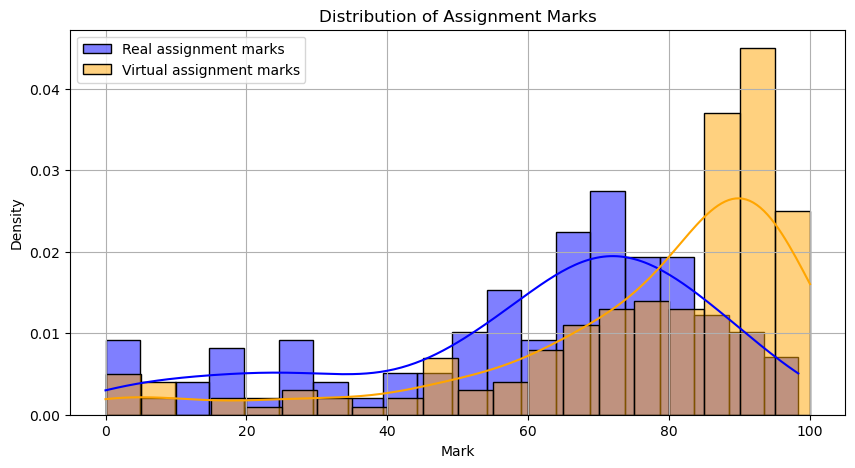

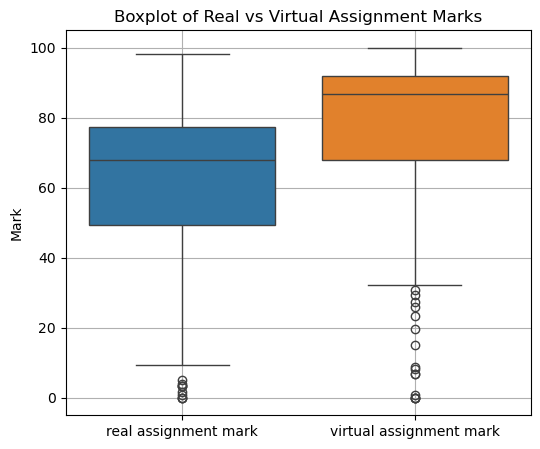

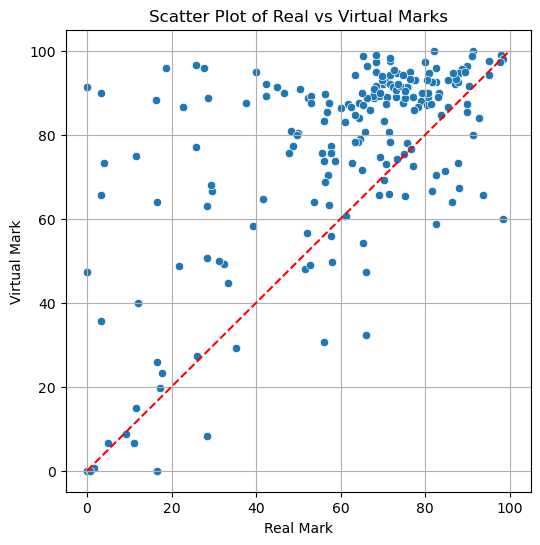

Pearson Correlation: 0.624 (p-value = 5.96e-23)
Paired t-test: t = -10.556, p = 5.69e-21
Mean Absolute Error (MAE): 19.98
Root Mean Squared Error (RMSE): 26.44
Proportion of scores with less than 10 points difference: 31.50%


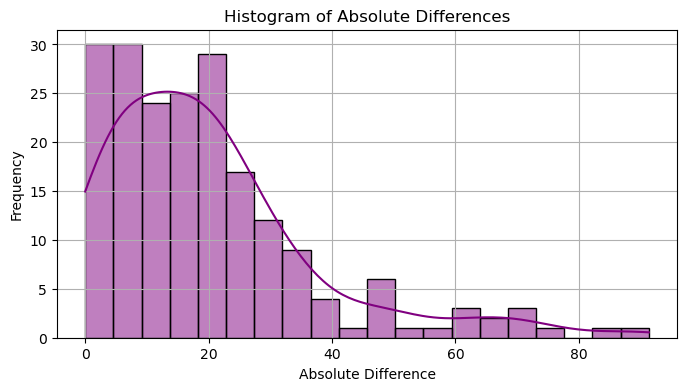

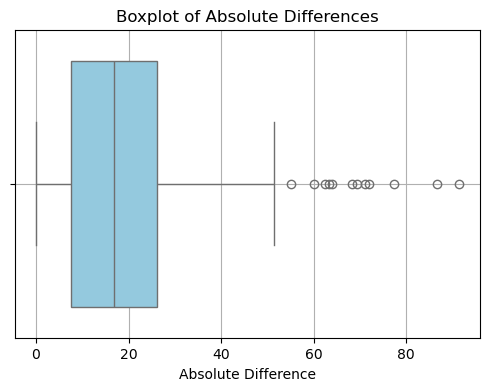

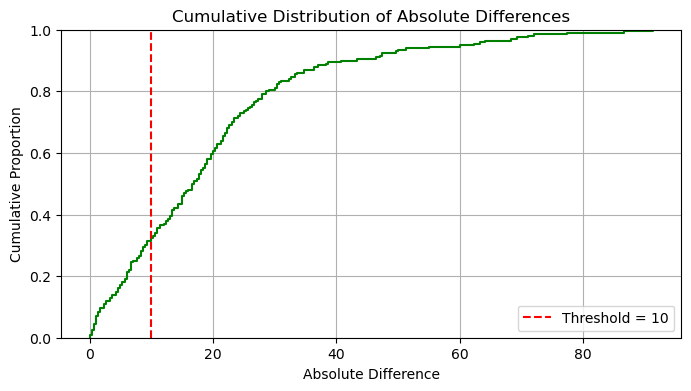

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['real assignment mark'], color='blue', label='Real assignment marks', kde=True, stat="density", bins=20)
sns.histplot(df['virtual assignment mark'], color='orange', label='Virtual assignment marks', kde=True, stat="density", bins=20)
plt.title('Distribution of Assignment Marks')
plt.legend()
plt.xlabel('Mark')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df[['real assignment mark', 'virtual assignment mark']])
plt.title('Boxplot of Real vs Virtual Assignment Marks')
plt.ylabel('Mark')
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='real assignment mark', y='virtual assignment mark', data=df)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # identity line
plt.title('Scatter Plot of Real vs Virtual Marks')
plt.xlabel('Real Mark')
plt.ylabel('Virtual Mark')
plt.grid(True)
plt.show()

# Pearson correlation
corr_coef, p_corr = pearsonr(df['real assignment mark'], df['virtual assignment mark'])

# Paired t-test
t_stat, p_ttest = ttest_rel(df['real assignment mark'], df['virtual assignment mark'])

# Similarity metrics
mae = mean_absolute_error(df['real assignment mark'], df['virtual assignment mark'])
rmse = np.sqrt(mean_squared_error(df['real assignment mark'], df['virtual assignment mark']))

# Print statistical results
print(f"Pearson Correlation: {corr_coef:.3f} (p-value = {p_corr:.3g})")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_ttest:.3g}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# Calculate absolute differences
differences = abs(df['real assignment mark'] - df['virtual assignment mark'])

# Proportion where difference is less than 10
proportion_under_10 = (differences < 10).mean()

print(f"Proportion of scores with less than 10 points difference: {proportion_under_10:.2%}")


# Plot 1: Histogram of Differences
plt.figure(figsize=(8, 4))
sns.histplot(differences, bins=20, kde=True, color='purple')
plt.title('Histogram of Absolute Differences')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Boxplot of Differences
plt.figure(figsize=(6, 4))
sns.boxplot(x=differences, color='skyblue')
plt.title('Boxplot of Absolute Differences')
plt.xlabel('Absolute Difference')
plt.grid(True)
plt.show()

# Plot 3: Cumulative Distribution Plot
plt.figure(figsize=(8, 4))
sns.ecdfplot(differences, color='green')
plt.axvline(10, color='red', linestyle='--', label='Threshold = 10')
plt.title('Cumulative Distribution of Absolute Differences')
plt.xlabel('Absolute Difference')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

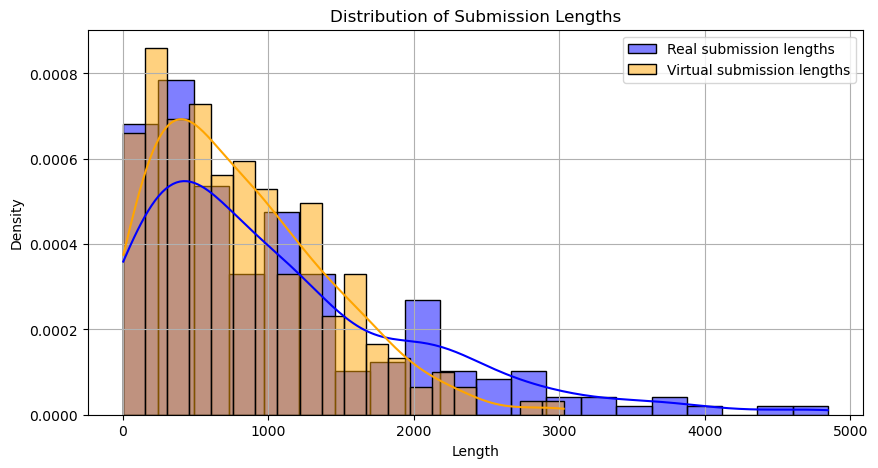

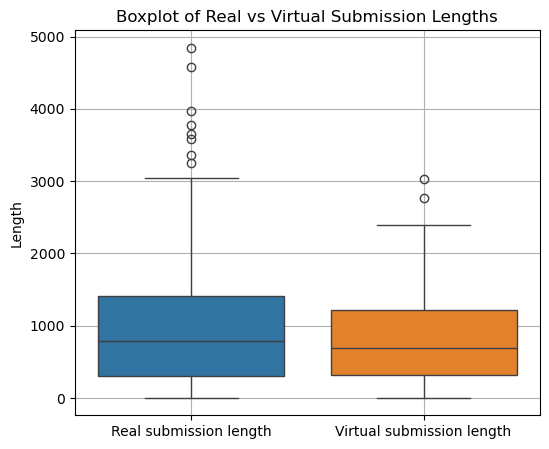

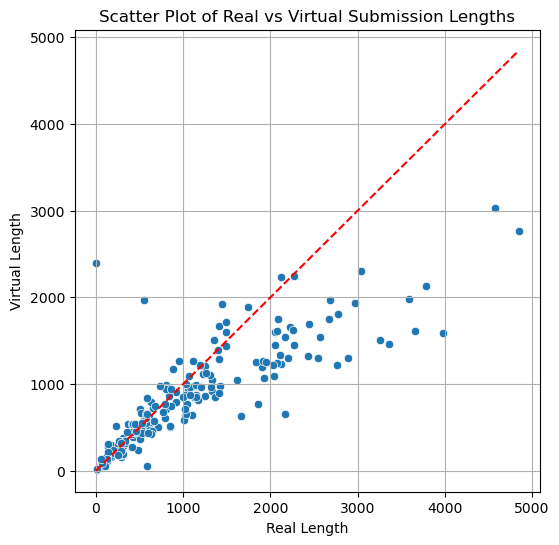

pearsonr Correlation: 0.852 (p-value = 1.39e-57)
Paired t-test: t = 6.157, p = 4.03e-09
Mean Absolute Error (MAE): 335.43
Root Mean Squared Error (RMSE): 587.07
Proportion of submissions with less than 50% difference in length: 83.50%


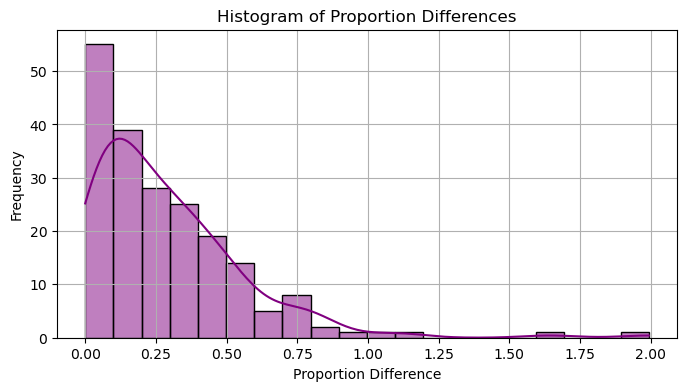

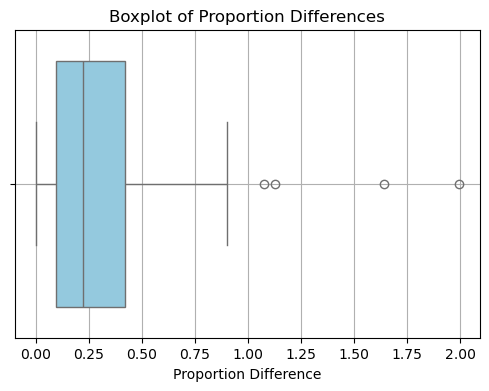

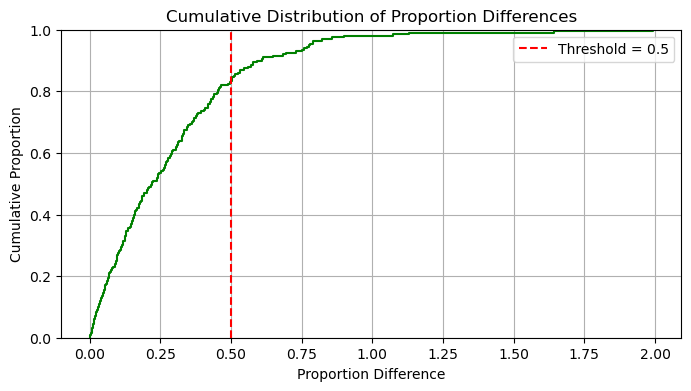


BERT SCORE SEMANTIC SIMILARITY ANALYSIS - STUDENT SUBMISSIONS
Calculating BERT scores for student submissions... (this may take a few minutes)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 94.94 seconds, 2.11 sentences/sec

BERT Score Statistics for Student Submissions:
F1 Score - Mean: 0.8395, Std: 0.0378
Precision - Mean: 0.8352, Std: 0.0393
Recall - Mean: 0.8440, Std: 0.0390

Correlation between BERT F1 and Length Similarity: 0.268 (p-value = 0.000127)


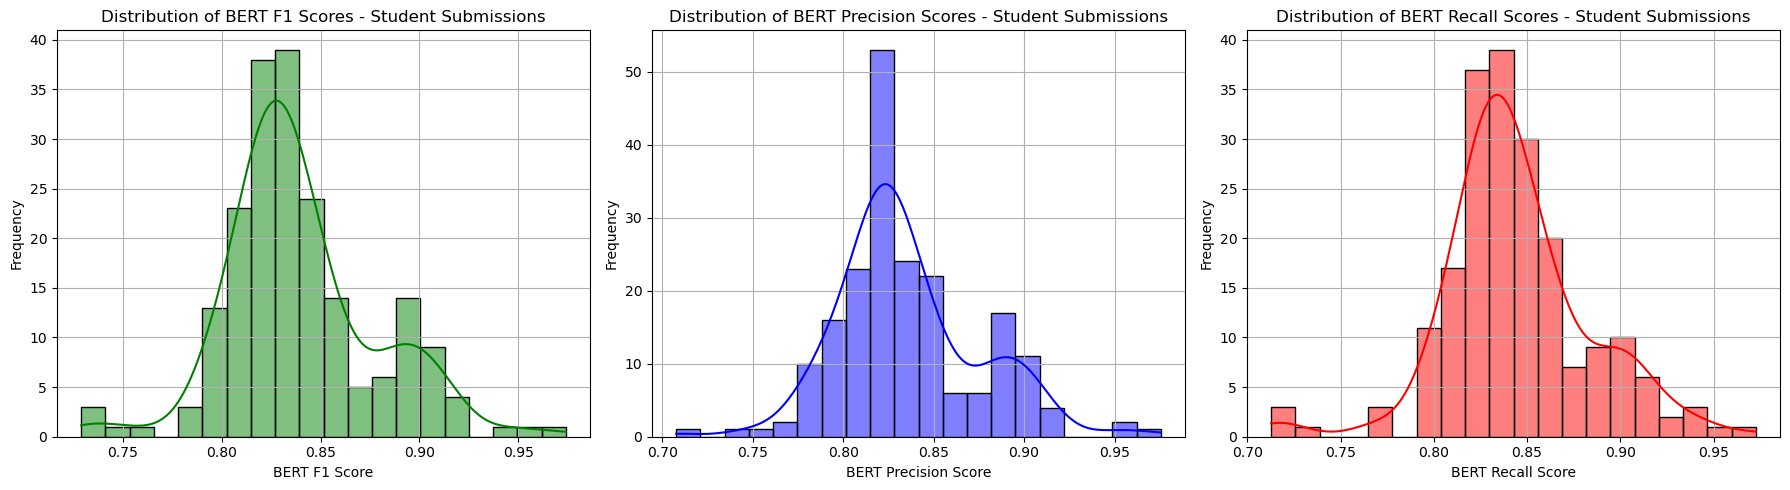

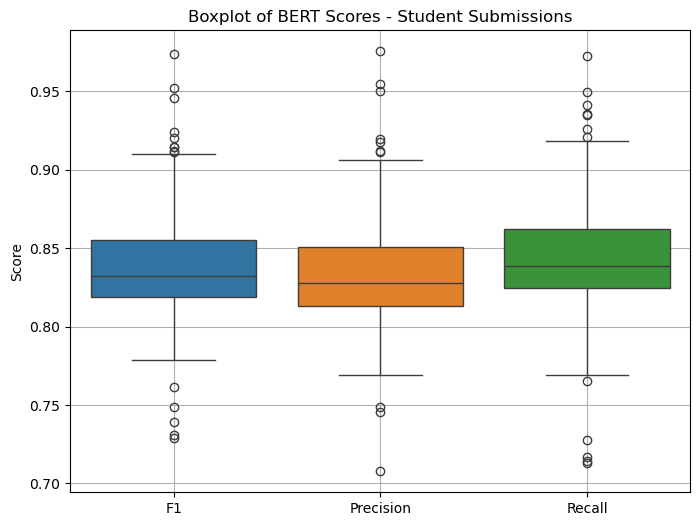

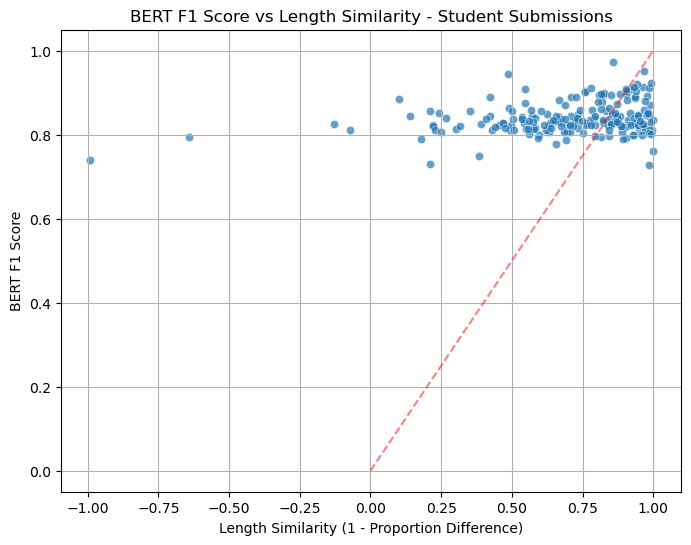

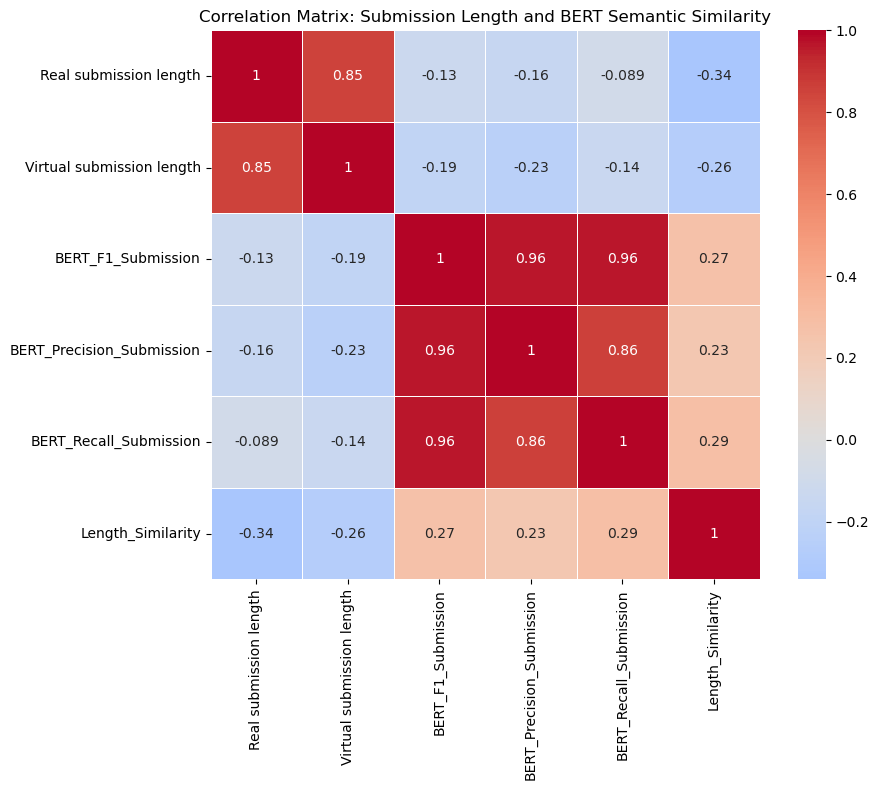

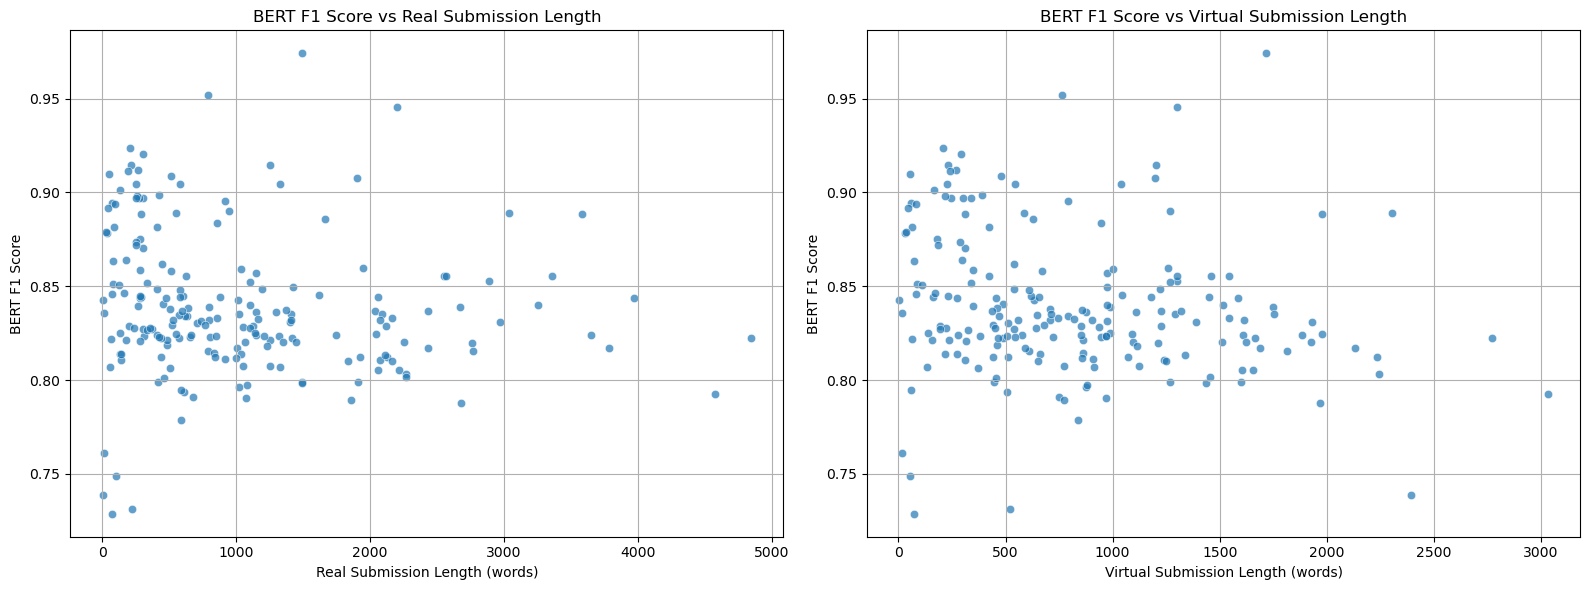

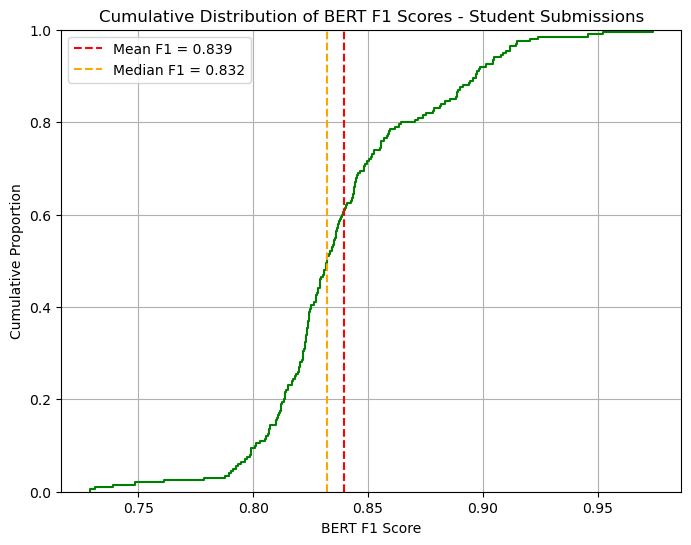


Semantic Similarity Analysis - Student Submissions:
High similarity threshold (75th percentile): 0.856
Low similarity threshold (25th percentile): 0.819
Number of high similarity pairs: 50
Number of low similarity pairs: 50


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

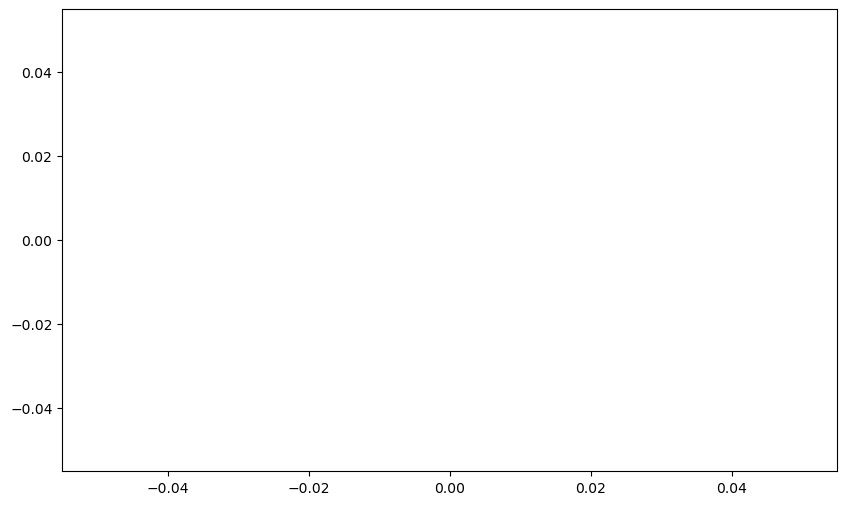

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# For BERT score calculation
from bert_score import score
import torch

def count_words(text):
    return len(text.split())

# Calculate submission lengths
df['Real submission length'] = df['Real student submission'].apply(count_words)
df['Virtual submission length'] = df['Virtual student submission'].apply(count_words)

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['Real submission length'], color='blue', label='Real submission lengths', kde=True, stat="density", bins=20)
sns.histplot(df['Virtual submission length'], color='orange', label='Virtual submission lengths', kde=True, stat="density", bins=20)
plt.title('Distribution of Submission Lengths')
plt.legend()
plt.xlabel('Length')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df[['Real submission length', 'Virtual submission length']])
plt.title('Boxplot of Real vs Virtual Submission Lengths')
plt.ylabel('Length')
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Real submission length', y='Virtual submission length', data=df)
plt.plot([0, df['Real submission length'].max()], [0, df['Real submission length'].max()], color='red', linestyle='--')  # identity line
plt.title('Scatter Plot of Real vs Virtual Submission Lengths')
plt.xlabel('Real Length')
plt.ylabel('Virtual Length')
plt.grid(True)
plt.show()

# Pearson correlation
corr_coef, p_corr = pearsonr(df['Real submission length'], df['Virtual submission length'])

# Paired t-test
t_stat, p_ttest = ttest_rel(df['Real submission length'], df['Virtual submission length'])

# Similarity metrics
mae = mean_absolute_error(df['Real submission length'], df['Virtual submission length'])
rmse = np.sqrt(mean_squared_error(df['Real submission length'], df['Virtual submission length']))

# Print statistical results
print(f"pearsonr Correlation: {corr_coef:.3f} (p-value = {p_corr:.3g})")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_ttest:.3g}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate proportion differences
proportion_differences = abs(df['Real submission length'] - df['Virtual submission length']) / ((df['Real submission length'] + df['Virtual submission length']) / 2)

# Proportion where difference is less than 50%
threshold = 0.5
proportion_under_50_percent = (proportion_differences < threshold).mean()
print(f"Proportion of submissions with less than 50% difference in length: {proportion_under_50_percent:.2%}")

# Plot 1: Histogram of Proportion Differences
plt.figure(figsize=(8, 4))
sns.histplot(proportion_differences, bins=20, kde=True, color='purple')
plt.title('Histogram of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Boxplot of Proportion Differences
plt.figure(figsize=(6, 4))
sns.boxplot(x=proportion_differences, color='skyblue')
plt.title('Boxplot of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.grid(True)
plt.show()

# Plot 3: Cumulative Distribution Plot
plt.figure(figsize=(8, 4))
sns.ecdfplot(proportion_differences, color='green')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.1f}')
plt.title('Cumulative Distribution of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# BERT SCORE SEMANTIC SIMILARITY ANALYSIS FOR STUDENT SUBMISSIONS
# =============================================================================

print("\n" + "="*60)
print("BERT SCORE SEMANTIC SIMILARITY ANALYSIS - STUDENT SUBMISSIONS")
print("="*60)

# Convert to lists for BERT score calculation
real_submissions = df['Real student submission'].tolist()
virtual_submissions = df['Virtual student submission'].tolist()

# Calculate BERT scores
print("Calculating BERT scores for student submissions... (this may take a few minutes)")
P, R, F1 = score(virtual_submissions, real_submissions, lang='en', verbose=True)

# Convert to numpy arrays for easier manipulation
bert_precision = P.numpy()
bert_recall = R.numpy()
bert_f1 = F1.numpy()

# Add BERT scores to dataframe
df['BERT_Precision_Submission'] = bert_precision
df['BERT_Recall_Submission'] = bert_recall
df['BERT_F1_Submission'] = bert_f1

# Print BERT score statistics
print(f"\nBERT Score Statistics for Student Submissions:")
print(f"F1 Score - Mean: {bert_f1.mean():.4f}, Std: {bert_f1.std():.4f}")
print(f"Precision - Mean: {bert_precision.mean():.4f}, Std: {bert_precision.std():.4f}")
print(f"Recall - Mean: {bert_recall.mean():.4f}, Std: {bert_recall.std():.4f}")

# Correlation between BERT F1 and length similarity
length_similarity = 1 - proportion_differences  # Convert difference to similarity
bert_length_corr, bert_length_p = pearsonr(bert_f1, length_similarity)
print(f"\nCorrelation between BERT F1 and Length Similarity: {bert_length_corr:.3f} (p-value = {bert_length_p:.3g})")

# =============================================================================
# BERT SCORE VISUALIZATIONS FOR STUDENT SUBMISSIONS
# =============================================================================

# 1. Distribution of BERT F1 Scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score Distribution
sns.histplot(bert_f1, bins=20, kde=True, color='green', ax=axes[0])
axes[0].set_title('Distribution of BERT F1 Scores - Student Submissions')
axes[0].set_xlabel('BERT F1 Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Precision Distribution
sns.histplot(bert_precision, bins=20, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Distribution of BERT Precision Scores - Student Submissions')
axes[1].set_xlabel('BERT Precision Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Recall Distribution
sns.histplot(bert_recall, bins=20, kde=True, color='red', ax=axes[2])
axes[2].set_title('Distribution of BERT Recall Scores - Student Submissions')
axes[2].set_xlabel('BERT Recall Score')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 2. Boxplot of BERT Scores
plt.figure(figsize=(8, 6))
bert_scores_df = pd.DataFrame({
    'F1': bert_f1,
    'Precision': bert_precision,
    'Recall': bert_recall
})
sns.boxplot(data=bert_scores_df)
plt.title('Boxplot of BERT Scores - Student Submissions')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# 3. Scatter plot: BERT F1 vs Length Similarity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=length_similarity, y=bert_f1, alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', alpha=0.5)  # identity line
plt.title('BERT F1 Score vs Length Similarity - Student Submissions')
plt.xlabel('Length Similarity (1 - Proportion Difference)')
plt.ylabel('BERT F1 Score')
plt.grid(True)
plt.show()

# 4. Correlation matrix heatmap
correlation_data = df[['Real submission length', 'Virtual submission length', 
                      'BERT_F1_Submission', 'BERT_Precision_Submission', 'BERT_Recall_Submission']].copy()
correlation_data['Length_Similarity'] = length_similarity

corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Submission Length and BERT Semantic Similarity')
plt.tight_layout()
plt.show()

# 5. BERT F1 Score vs Submission Length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 vs Real Length
sns.scatterplot(x='Real submission length', y='BERT_F1_Submission', data=df, ax=axes[0], alpha=0.7)
axes[0].set_title('BERT F1 Score vs Real Submission Length')
axes[0].set_xlabel('Real Submission Length (words)')
axes[0].set_ylabel('BERT F1 Score')
axes[0].grid(True)

# F1 vs Virtual Length
sns.scatterplot(x='Virtual submission length', y='BERT_F1_Submission', data=df, ax=axes[1], alpha=0.7)
axes[1].set_title('BERT F1 Score vs Virtual Submission Length')
axes[1].set_xlabel('Virtual Submission Length (words)')
axes[1].set_ylabel('BERT F1 Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 6. Cumulative Distribution of BERT F1 Scores
plt.figure(figsize=(8, 6))
sns.ecdfplot(bert_f1, color='green')
plt.axvline(bert_f1.mean(), color='red', linestyle='--', 
            label=f'Mean F1 = {bert_f1.mean():.3f}')
plt.axvline(np.median(bert_f1), color='orange', linestyle='--', 
            label=f'Median F1 = {np.median(bert_f1):.3f}')
plt.title('Cumulative Distribution of BERT F1 Scores - Student Submissions')
plt.xlabel('BERT F1 Score')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

# 7. High vs Low Semantic Similarity Analysis
high_similarity_threshold = np.percentile(bert_f1, 75)  # Top 25%
low_similarity_threshold = np.percentile(bert_f1, 25)   # Bottom 25%

high_sim_mask = bert_f1 >= high_similarity_threshold
low_sim_mask = bert_f1 <= low_similarity_threshold

print(f"\nSemantic Similarity Analysis - Student Submissions:")
print(f"High similarity threshold (75th percentile): {high_similarity_threshold:.3f}")
print(f"Low similarity threshold (25th percentile): {low_similarity_threshold:.3f}")
print(f"Number of high similarity pairs: {high_sim_mask.sum()}")
print(f"Number of low similarity pairs: {low_sim_mask.sum()}")

# Compare length differences for high vs low semantic similarity
high_sim_length_diff = proportion_differences[high_sim_mask]
low_sim_length_diff = proportion_differences[low_sim_mask]

plt.figure(figsize=(10, 6))
sns.boxplot(data=[high_sim_length_diff, low_sim_length_diff])
plt.xticks([0, 1], ['High Semantic Similarity', 'Low Semantic Similarity'])
plt.ylabel('Length Proportion Difference')
plt.title('Length Differences for High vs Low Semantic Similarity Groups - Student Submissions')
plt.grid(True)
plt.show()

# Statistical test for length differences between high and low semantic similarity groups
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(high_sim_length_diff, low_sim_length_diff, alternative='two-sided')
print(f"Mann-Whitney U test (length diff high vs low semantic similarity): U = {stat:.2f}, p = {p_value:.3g}")

print(f"\nMean length difference - High semantic similarity: {high_sim_length_diff.mean():.3f}")
print(f"Mean length difference - Low semantic similarity: {low_sim_length_diff.mean():.3f}")

# 8. Quality Assessment Based on BERT Scores
# Define quality categories based on BERT F1 scores
excellent_threshold = 0.9
good_threshold = 0.8
fair_threshold = 0.6

excellent_mask = bert_f1 >= excellent_threshold
good_mask = (bert_f1 >= good_threshold) & (bert_f1 < excellent_threshold)
fair_mask = (bert_f1 >= fair_threshold) & (bert_f1 < good_threshold)
poor_mask = bert_f1 < fair_threshold

quality_counts = {
    'Excellent (≥0.9)': excellent_mask.sum(),
    'Good (0.8-0.9)': good_mask.sum(),
    'Fair (0.6-0.8)': fair_mask.sum(),
    'Poor (<0.6)': poor_mask.sum()
}

# Pie chart of quality distribution
plt.figure(figsize=(8, 8))
plt.pie(quality_counts.values(), labels=quality_counts.keys(), autopct='%1.1f%%', 
        colors=['darkgreen', 'green', 'orange', 'red'])
plt.title('Quality Distribution Based on BERT F1 Semantic Similarity\nStudent Submissions')
plt.show()

# 9. Length vs Semantic Quality Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Length distribution by quality category
quality_labels = []
length_data = []
for label, mask in [('Excellent', excellent_mask), ('Good', good_mask), 
                   ('Fair', fair_mask), ('Poor', poor_mask)]:
    if mask.sum() > 0:  # Only include categories with data
        quality_labels.append(label)
        length_data.append(df['Real submission length'][mask])

if length_data:
    axes[0, 0].boxplot(length_data, labels=quality_labels)
    axes[0, 0].set_title('Real Submission Length by Semantic Quality')
    axes[0, 0].set_ylabel('Length (words)')
    axes[0, 0].grid(True)
    axes[0, 0].tick_params(axis='x', rotation=45)

# Virtual submission lengths by quality
virtual_length_data = []
for label, mask in [('Excellent', excellent_mask), ('Good', good_mask), 
                   ('Fair', fair_mask), ('Poor', poor_mask)]:
    if mask.sum() > 0:
        virtual_length_data.append(df['Virtual submission length'][mask])

if virtual_length_data:
    axes[0, 1].boxplot(virtual_length_data, labels=quality_labels)
    axes[0, 1].set_title('Virtual Submission Length by Semantic Quality')
    axes[0, 1].set_ylabel('Length (words)')
    axes[0, 1].grid(True)
    axes[0, 1].tick_params(axis='x', rotation=45)

# Scatter plot with quality color coding
colors = ['red' if score < fair_threshold else 'orange' if score < good_threshold 
          else 'green' if score < excellent_threshold else 'darkgreen' 
          for score in bert_f1]

axes[1, 0].scatter(df['Real submission length'], df['Virtual submission length'], 
                  c=colors, alpha=0.6)
axes[1, 0].plot([0, df['Real submission length'].max()], 
               [0, df['Real submission length'].max()], 'k--', alpha=0.5)
axes[1, 0].set_xlabel('Real Submission Length')
axes[1, 0].set_ylabel('Virtual Submission Length')
axes[1, 0].set_title('Length Comparison Colored by Semantic Quality')
axes[1, 0].grid(True)

# BERT F1 distribution with quality thresholds
axes[1, 1].hist(bert_f1, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(excellent_threshold, color='darkgreen', linestyle='--', 
                  label=f'Excellent (≥{excellent_threshold})')
axes[1, 1].axvline(good_threshold, color='green', linestyle='--', 
                  label=f'Good (≥{good_threshold})')
axes[1, 1].axvline(fair_threshold, color='orange', linestyle='--', 
                  label=f'Fair (≥{fair_threshold})')
axes[1, 1].set_xlabel('BERT F1 Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('BERT F1 Score Distribution with Quality Thresholds')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Final summary
print(f"\n" + "="*60)
print("SUMMARY STATISTICS - STUDENT SUBMISSIONS")
print("="*60)
print(f"Total number of submission pairs: {len(df)}")
print(f"Average BERT F1 semantic similarity: {bert_f1.mean():.3f} ± {bert_f1.std():.3f}")
print(f"Proportion with F1 ≥ 0.9 (excellent similarity): {excellent_mask.mean():.2%}")
print(f"Proportion with F1 ≥ 0.8 (good similarity): {(bert_f1 >= good_threshold).mean():.2%}")
print(f"Proportion with F1 ≥ 0.6 (fair similarity): {(bert_f1 >= fair_threshold).mean():.2%}")
print(f"Proportion with F1 < 0.6 (poor similarity): {poor_mask.mean():.2%}")
print(f"Correlation between semantic and length similarity: {bert_length_corr:.3f}")

# Additional insights
print(f"\nLength Analysis by Semantic Quality:")
for label, mask in [('Excellent', excellent_mask), ('Good', good_mask), 
                   ('Fair', fair_mask), ('Poor', poor_mask)]:
    if mask.sum() > 0:
        mean_length_diff = proportion_differences[mask].mean()
        print(f"{label} semantic quality - Mean length difference: {mean_length_diff:.3f}")

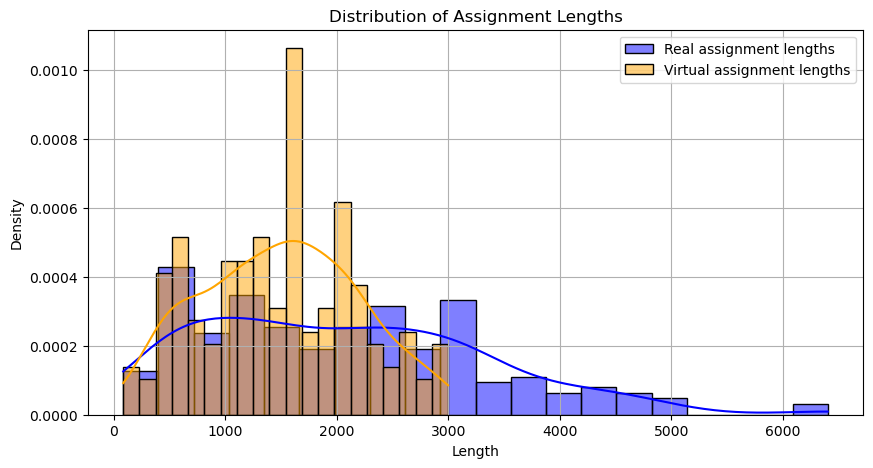

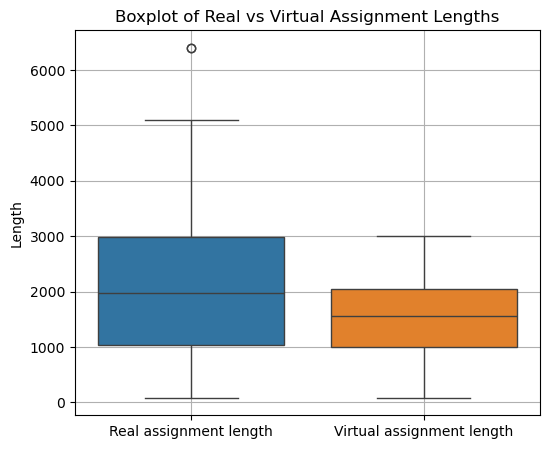

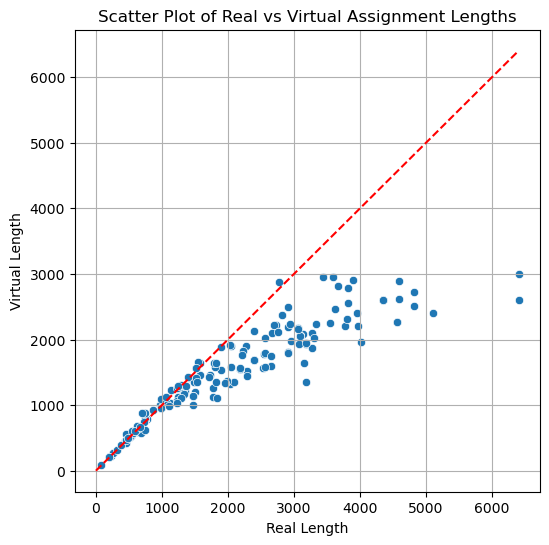

pearsonr Correlation: 0.931 (p-value = 1.01e-88)
Paired t-test: t = 11.878, p = 6.06e-25
Mean Absolute Error (MAE): 586.65
Root Mean Squared Error (RMSE): 882.30
Proportion of assignments with less than 10% difference in length: 33.50%


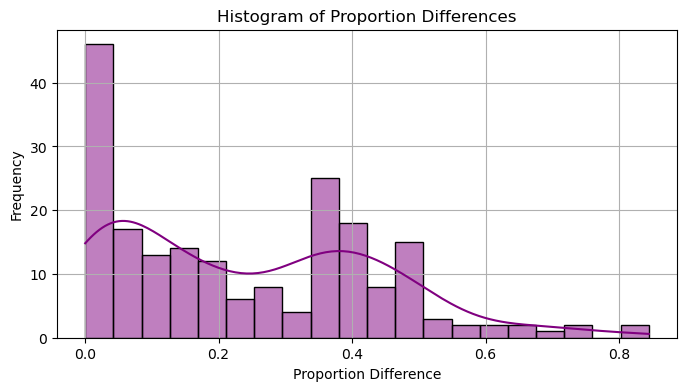

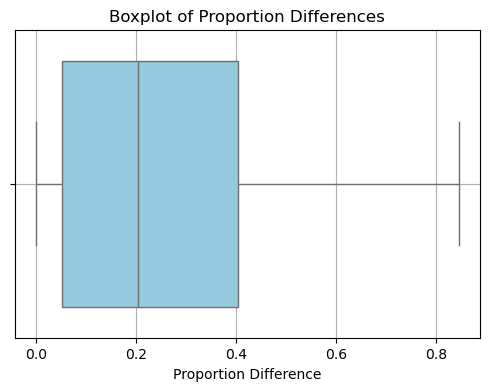

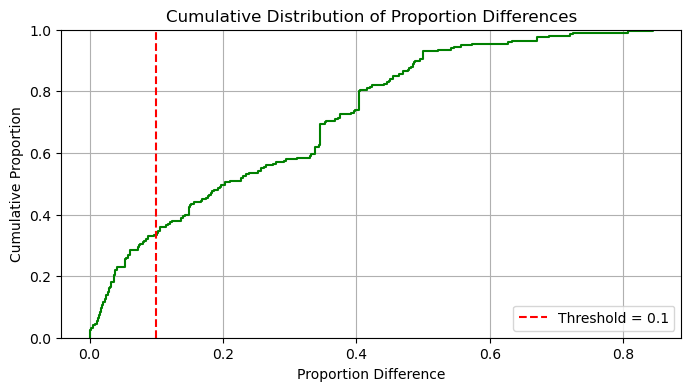


BERT SCORE SEMANTIC SIMILARITY ANALYSIS
Calculating BERT scores... (this may take a few minutes)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 42.27 seconds, 4.73 sentences/sec

BERT Score Statistics:
F1 Score - Mean: 0.8594, Std: 0.0196
Precision - Mean: 0.8518, Std: 0.0213
Recall - Mean: 0.8672, Std: 0.0192

Correlation between BERT F1 and Length Similarity: 0.272 (p-value = 9.48e-05)


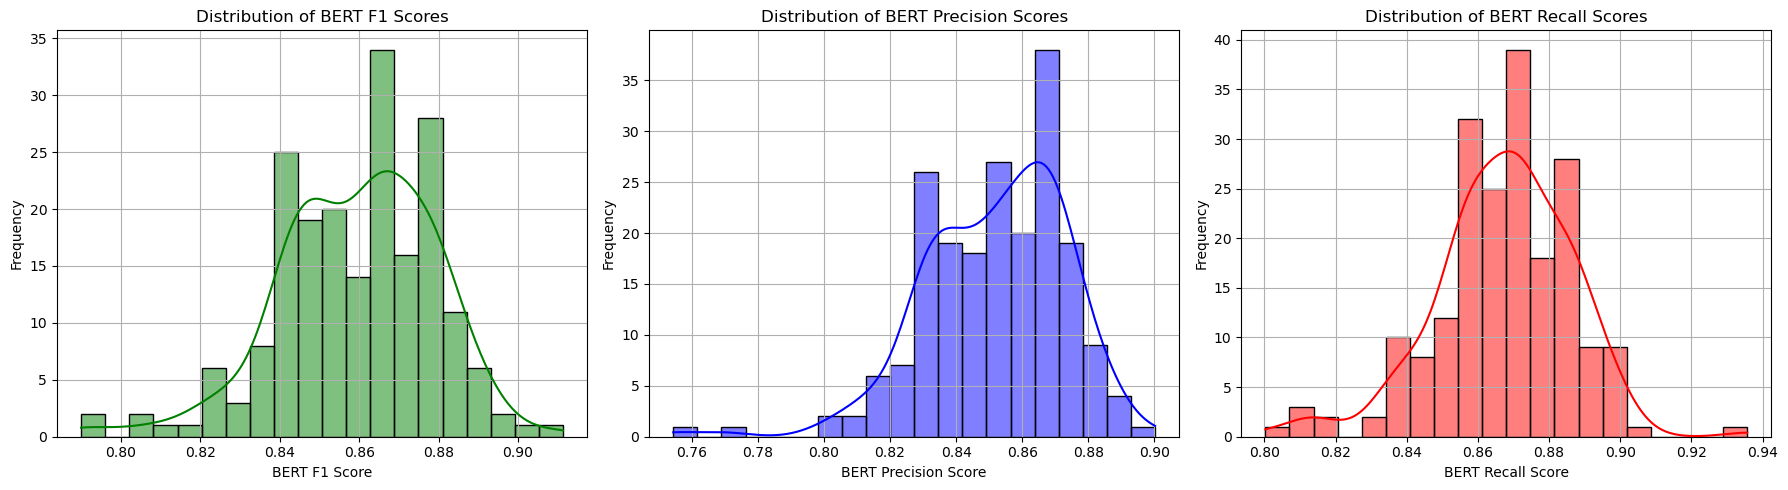

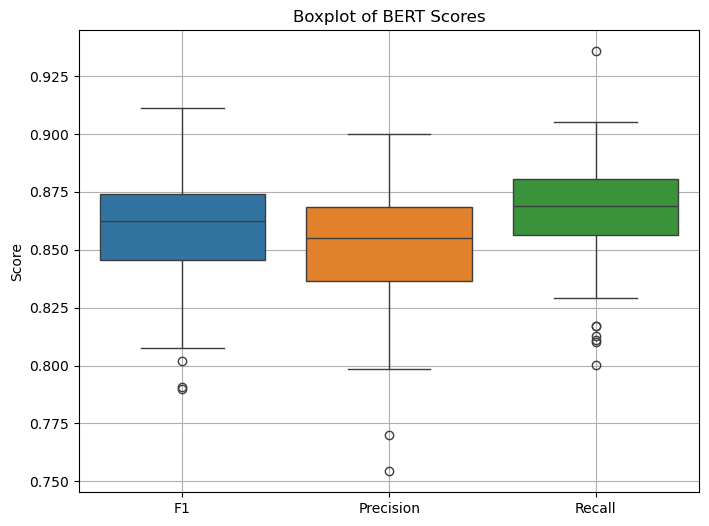

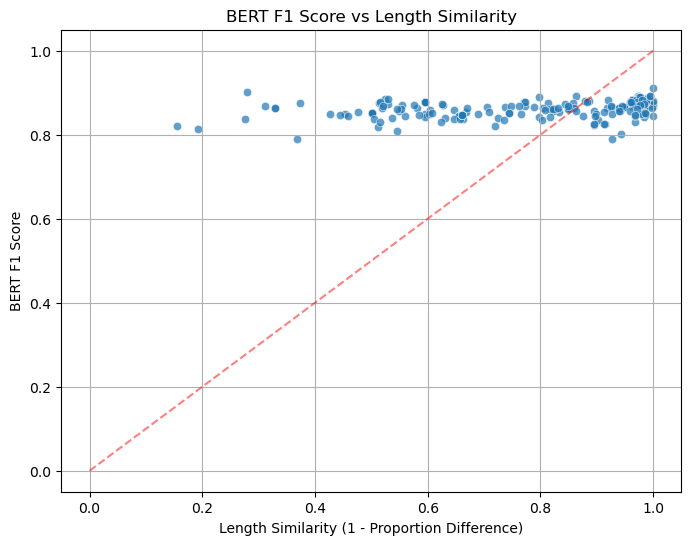

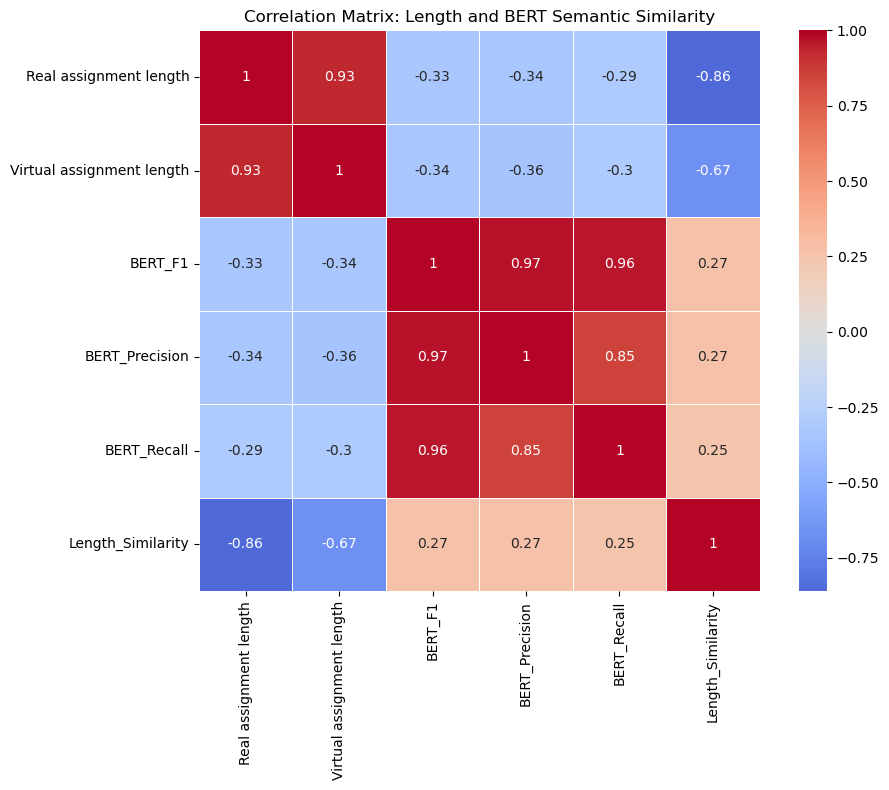

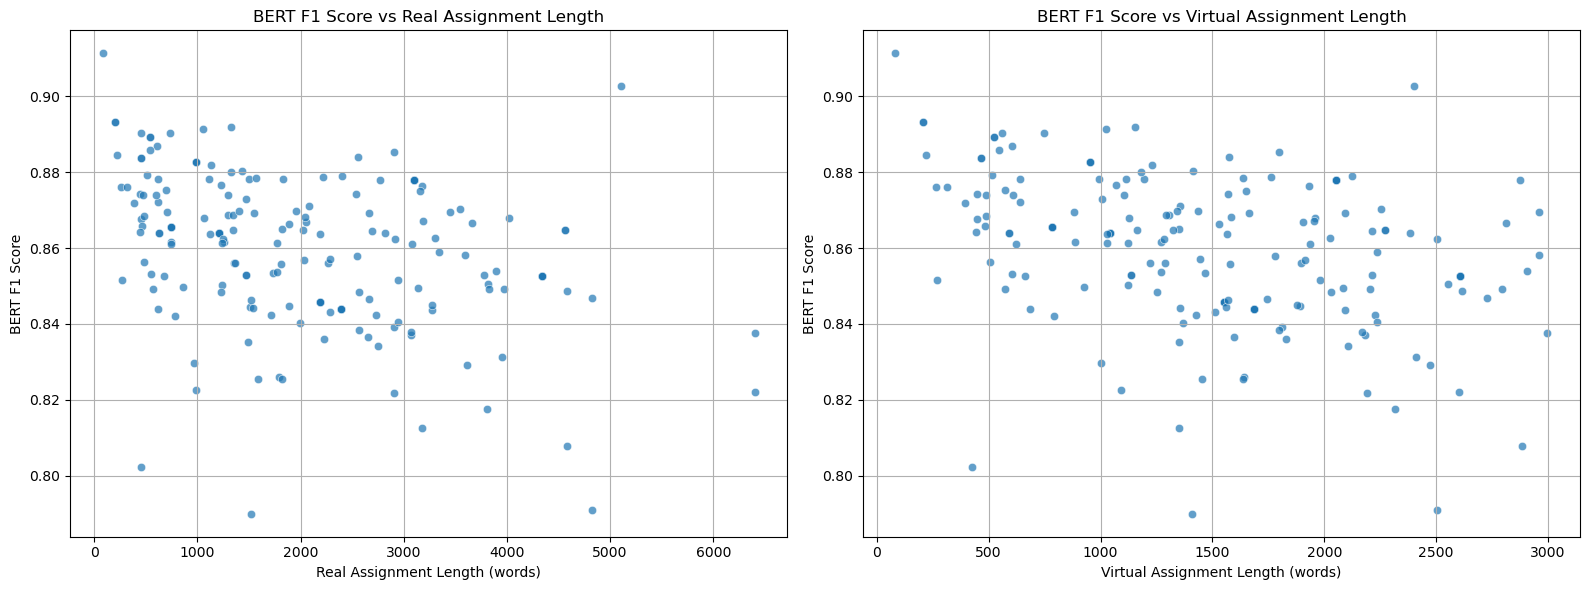

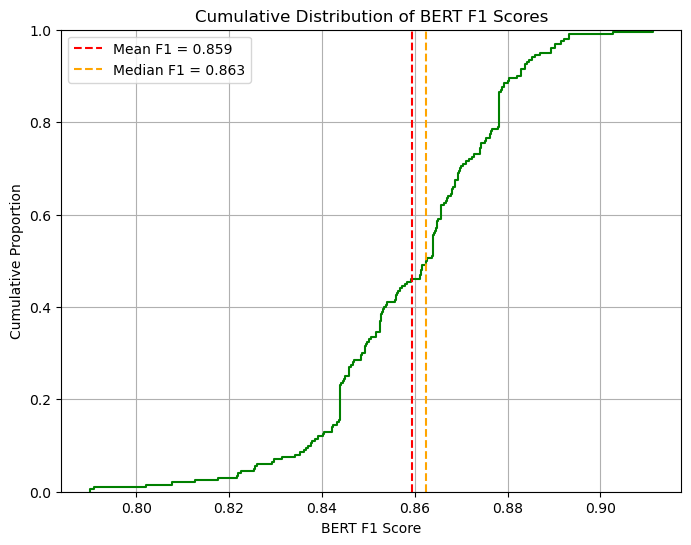


Semantic Similarity Analysis:
High similarity threshold (75th percentile): 0.874
Low similarity threshold (25th percentile): 0.846
Number of high similarity pairs: 50
Number of low similarity pairs: 50


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

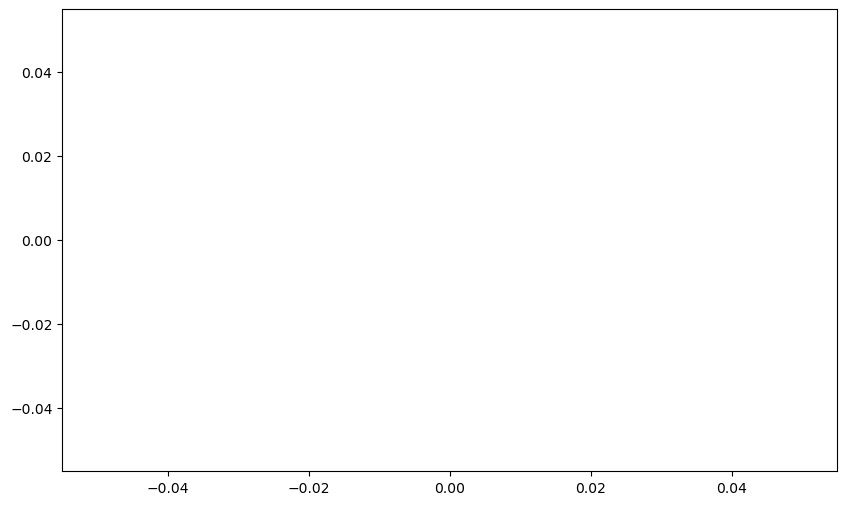

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# For BERT score calculation
from bert_score import score
import torch

def count_words(text):
    return len(text.split())

# Calculate assignment lengths
df['Real assignment length'] = df['Assignment description'].apply(count_words)
df['Virtual assignment length'] = df['Virtual assignment description'].apply(count_words)

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['Real assignment length'], color='blue', label='Real assignment lengths', kde=True, stat="density", bins=20)
sns.histplot(df['Virtual assignment length'], color='orange', label='Virtual assignment lengths', kde=True, stat="density", bins=20)
plt.title('Distribution of Assignment Lengths')
plt.legend()
plt.xlabel('Length')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df[['Real assignment length', 'Virtual assignment length']])
plt.title('Boxplot of Real vs Virtual Assignment Lengths')
plt.ylabel('Length')
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Real assignment length', y='Virtual assignment length', data=df)
plt.plot([0, df['Real assignment length'].max()], [0, df['Real assignment length'].max()], color='red', linestyle='--')  # identity line
plt.title('Scatter Plot of Real vs Virtual Assignment Lengths')
plt.xlabel('Real Length')
plt.ylabel('Virtual Length')
plt.grid(True)
plt.show()

# Pearson correlation
corr_coef, p_corr = pearsonr(df['Real assignment length'], df['Virtual assignment length'])

# Paired t-test
t_stat, p_ttest = ttest_rel(df['Real assignment length'], df['Virtual assignment length'])

# Similarity metrics
mae = mean_absolute_error(df['Real assignment length'], df['Virtual assignment length'])
rmse = np.sqrt(mean_squared_error(df['Real assignment length'], df['Virtual assignment length']))

# Print statistical results
print(f"pearsonr Correlation: {corr_coef:.3f} (p-value = {p_corr:.3g})")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_ttest:.3g}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate proportion differences
proportion_differences = abs(df['Real assignment length'] - df['Virtual assignment length']) / ((df['Real assignment length'] + df['Virtual assignment length']) / 2)

# Proportion where difference is less than 10%
threshold = 0.1
proportion_under_10_percent = (proportion_differences < threshold).mean()
print(f"Proportion of assignments with less than 10% difference in length: {proportion_under_10_percent:.2%}")

# Plot 1: Histogram of Proportion Differences
plt.figure(figsize=(8, 4))
sns.histplot(proportion_differences, bins=20, kde=True, color='purple')
plt.title('Histogram of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Boxplot of Proportion Differences
plt.figure(figsize=(6, 4))
sns.boxplot(x=proportion_differences, color='skyblue')
plt.title('Boxplot of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.grid(True)
plt.show()

# Plot 3: Cumulative Distribution Plot
plt.figure(figsize=(8, 4))
sns.ecdfplot(proportion_differences, color='green')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.1f}')
plt.title('Cumulative Distribution of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# BERT SCORE SEMANTIC SIMILARITY ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("BERT SCORE SEMANTIC SIMILARITY ANALYSIS")
print("="*60)

# Convert to lists for BERT score calculation
real_descriptions = df['Assignment description'].tolist()
virtual_descriptions = df['Virtual assignment description'].tolist()

# Calculate BERT scores
print("Calculating BERT scores... (this may take a few minutes)")
P, R, F1 = score(virtual_descriptions, real_descriptions, lang='en', verbose=True)

# Convert to numpy arrays for easier manipulation
bert_precision = P.numpy()
bert_recall = R.numpy()
bert_f1 = F1.numpy()

# Add BERT scores to dataframe
df['BERT_Precision'] = bert_precision
df['BERT_Recall'] = bert_recall
df['BERT_F1'] = bert_f1

# Print BERT score statistics
print(f"\nBERT Score Statistics:")
print(f"F1 Score - Mean: {bert_f1.mean():.4f}, Std: {bert_f1.std():.4f}")
print(f"Precision - Mean: {bert_precision.mean():.4f}, Std: {bert_precision.std():.4f}")
print(f"Recall - Mean: {bert_recall.mean():.4f}, Std: {bert_recall.std():.4f}")

# Correlation between BERT F1 and length similarity
length_similarity = 1 - proportion_differences  # Convert difference to similarity
bert_length_corr, bert_length_p = pearsonr(bert_f1, length_similarity)
print(f"\nCorrelation between BERT F1 and Length Similarity: {bert_length_corr:.3f} (p-value = {bert_length_p:.3g})")

# =============================================================================
# BERT SCORE VISUALIZATIONS
# =============================================================================

# 1. Distribution of BERT F1 Scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score Distribution
sns.histplot(bert_f1, bins=20, kde=True, color='green', ax=axes[0])
axes[0].set_title('Distribution of BERT F1 Scores')
axes[0].set_xlabel('BERT F1 Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Precision Distribution
sns.histplot(bert_precision, bins=20, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Distribution of BERT Precision Scores')
axes[1].set_xlabel('BERT Precision Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Recall Distribution
sns.histplot(bert_recall, bins=20, kde=True, color='red', ax=axes[2])
axes[2].set_title('Distribution of BERT Recall Scores')
axes[2].set_xlabel('BERT Recall Score')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 2. Boxplot of BERT Scores
plt.figure(figsize=(8, 6))
bert_scores_df = pd.DataFrame({
    'F1': bert_f1,
    'Precision': bert_precision,
    'Recall': bert_recall
})
sns.boxplot(data=bert_scores_df)
plt.title('Boxplot of BERT Scores')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# 3. Scatter plot: BERT F1 vs Length Similarity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=length_similarity, y=bert_f1, alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', alpha=0.5)  # identity line
plt.title('BERT F1 Score vs Length Similarity')
plt.xlabel('Length Similarity (1 - Proportion Difference)')
plt.ylabel('BERT F1 Score')
plt.grid(True)
plt.show()

# 4. Correlation matrix heatmap
correlation_data = df[['Real assignment length', 'Virtual assignment length', 
                      'BERT_F1', 'BERT_Precision', 'BERT_Recall']].copy()
correlation_data['Length_Similarity'] = length_similarity

corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Length and BERT Semantic Similarity')
plt.tight_layout()
plt.show()

# 5. BERT F1 Score vs Assignment Length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 vs Real Length
sns.scatterplot(x='Real assignment length', y='BERT_F1', data=df, ax=axes[0], alpha=0.7)
axes[0].set_title('BERT F1 Score vs Real Assignment Length')
axes[0].set_xlabel('Real Assignment Length (words)')
axes[0].set_ylabel('BERT F1 Score')
axes[0].grid(True)

# F1 vs Virtual Length
sns.scatterplot(x='Virtual assignment length', y='BERT_F1', data=df, ax=axes[1], alpha=0.7)
axes[1].set_title('BERT F1 Score vs Virtual Assignment Length')
axes[1].set_xlabel('Virtual Assignment Length (words)')
axes[1].set_ylabel('BERT F1 Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 6. Cumulative Distribution of BERT F1 Scores
plt.figure(figsize=(8, 6))
sns.ecdfplot(bert_f1, color='green')
plt.axvline(bert_f1.mean(), color='red', linestyle='--', 
            label=f'Mean F1 = {bert_f1.mean():.3f}')
plt.axvline(np.median(bert_f1), color='orange', linestyle='--', 
            label=f'Median F1 = {np.median(bert_f1):.3f}')
plt.title('Cumulative Distribution of BERT F1 Scores')
plt.xlabel('BERT F1 Score')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

# 7. High vs Low Semantic Similarity Analysis
high_similarity_threshold = np.percentile(bert_f1, 75)  # Top 25%
low_similarity_threshold = np.percentile(bert_f1, 25)   # Bottom 25%

high_sim_mask = bert_f1 >= high_similarity_threshold
low_sim_mask = bert_f1 <= low_similarity_threshold

print(f"\nSemantic Similarity Analysis:")
print(f"High similarity threshold (75th percentile): {high_similarity_threshold:.3f}")
print(f"Low similarity threshold (25th percentile): {low_similarity_threshold:.3f}")
print(f"Number of high similarity pairs: {high_sim_mask.sum()}")
print(f"Number of low similarity pairs: {low_sim_mask.sum()}")

# Compare length differences for high vs low semantic similarity
high_sim_length_diff = proportion_differences[high_sim_mask]
low_sim_length_diff = proportion_differences[low_sim_mask]

plt.figure(figsize=(10, 6))
sns.boxplot(data=[high_sim_length_diff, low_sim_length_diff])
plt.xticks([0, 1], ['High Semantic Similarity', 'Low Semantic Similarity'])
plt.ylabel('Length Proportion Difference')
plt.title('Length Differences for High vs Low Semantic Similarity Groups')
plt.grid(True)
plt.show()

# Statistical test for length differences between high and low semantic similarity groups
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(high_sim_length_diff, low_sim_length_diff)
print(f"Mann-Whitney U test (length diff high vs low semantic similarity): U = {stat:.2f}, p = {p_value:.3g}")

print(f"\nMean length difference - High semantic similarity: {high_sim_length_diff.mean():.3f}")
print(f"Mean length difference - Low semantic similarity: {low_sim_length_diff.mean():.3f}")

# Final summary
print(f"\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Total number of assignment pairs: {len(df)}")
print(f"Average BERT F1 semantic similarity: {bert_f1.mean():.3f} ± {bert_f1.std():.3f}")
print(f"Proportion with F1 > 0.8 (high similarity): {(bert_f1 > 0.8).mean():.2%}")
print(f"Proportion with F1 < 0.6 (low similarity): {(bert_f1 < 0.6).mean():.2%}")
print(f"Correlation between semantic and length similarity: {bert_length_corr:.3f}")

In [ ]:
df.to_csv('../Data/FIT2021 S1/resemblance.csv', index=False)

In [59]:
df.columns

Index(['source_folder', 'unit_name', 'assignment_name',
       'Real student submission name', 'Assignment description',
       'Real student submission', 'Num_of_Tokens_description',
       'Num_of_Tokens_submission', 'Num_of_Tokens_total',
       'Virtual assignment description', 'Virtual student submission',
       '1 LLM mark of virtual student submission',
       '2 LLM mark of virtual student submission',
       '3 LLM mark of virtual student submission', '1 virtual assignment mark',
       '2 virtual assignment mark', '3 virtual assignment mark',
       '1 marker LLM', '2 marker LLM', '3 marker LLM',
       '1 LLM mark of real student submission',
       '2 LLM mark of real student submission',
       '3 LLM mark of real student submission', '1 real assignment mark',
       '2 real assignment mark', '3 real assignment mark',
       'real assignment mark', 'virtual assignment mark',
       'Real submission length', 'Virtual submission length',
       'BERT_Precision_Submission', 

In [62]:
try:

    # --- Plot 1: Submission Length ---
    
    # Prepare data for the first plot
    length_data = pd.concat([
        pd.DataFrame({'Length': df['Real submission length'], 'Category': 'Real Submission'}),
        pd.DataFrame({'Length': df['Virtual submission length'], 'Category': 'Virtual Submission'}),
        pd.DataFrame({'Length': mimicry['Virtual submission length'], 'Category': 'Mimicry Virtual Submission'})
    ])
    
    # Create the first violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Category', y='Length', data=length_data, inner='box')
    plt.title('Comparison of Submission Lengths')
    plt.xlabel('Submission Type')
    plt.ylabel('Submission Length')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('submission_length_comparison.png')
    print("Generated 'submission_length_comparison.png'")
    plt.clf()

    # --- Plot 2: Submission Mark ---
    
    # Prepare data for the second plot
    mark_data = pd.concat([
        pd.DataFrame({'Mark': df['real assignment mark'], 'Category': 'Real Submission'}),
        pd.DataFrame({'Mark': df['virtual assignment mark'], 'Category': 'Virtual Submission'}),
        pd.DataFrame({'Mark': mimicry['virtual assignment mark'], 'Category': 'Mimicry Virtual Submission'})
    ])

    # Create the second violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Category', y='Mark', data=mark_data, inner='box')
    plt.title('Comparison of Submission Marks')
    plt.xlabel('Submission Type')
    plt.ylabel('Submission Mark')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('submission_mark_comparison.png')
    print("Generated 'submission_mark_comparison.png'")
    plt.clf()

except FileNotFoundError:
    print("Error: 'df.csv' or 'mimicry.csv' not found.")
    print("Please make sure the files are in the correct directory and named correctly.")
except KeyError as e:
    print(f"Error: A column required for plotting was not found. Missing column: {e}")

Generated 'submission_length_comparison.png'
Generated 'submission_mark_comparison.png'


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

Successfully generated figure with colored subplots and saved it as 'comparison_subplots_color.png'


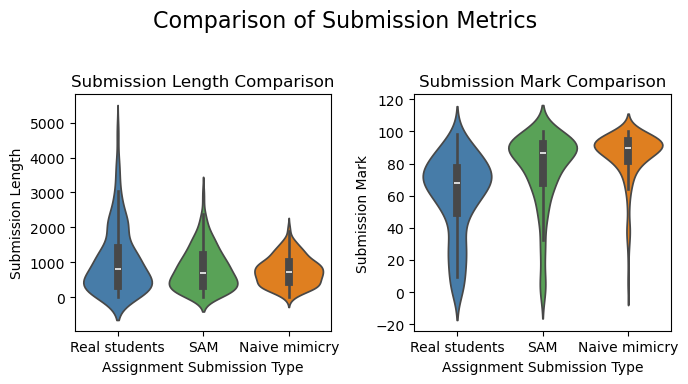

In [79]:
try:
    # --- Setup the Figure and Subplots ---
    # Create a figure with two subplots arranged side-by-side (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(7, 4))
    fig.suptitle('Comparison of Submission Metrics', fontsize=16)

    # Define a color palette for the three categories.
    # The order of colors will match the order of data concatenation below.
    # Blue for Real, Green for Virtual, Orange for Mimicry.
    color_palette = ['#377eb8', '#4daf4a', '#ff7f00']


    # --- Plot 1: Submission Length Comparison ---

    # Prepare the combined dataframe for the length plot
    length_data = pd.concat([
        pd.DataFrame({'Length': df['Real submission length'], 'Category': 'Real students'}),
        pd.DataFrame({'Length': df['Virtual submission length'], 'Category': 'SAM'}),
        pd.DataFrame({'Length': mimicry['Virtual submission length'], 'Category': 'Naive mimicry'})
    ])

    # Create the violin plot on the first subplot (axes[0]) using the defined palette
    sns.violinplot(ax=axes[0], x='Category', y='Length', data=length_data, inner='box', palette=color_palette)
    axes[0].set_title('Submission Length Comparison')
    axes[0].set_xlabel('Assignment Submission Type')
    axes[0].set_ylabel('Submission Length')


    # --- Plot 2: Submission Mark Comparison ---

    # Prepare the combined dataframe for the mark plot
    mark_data = pd.concat([
        pd.DataFrame({'Mark': df['real assignment mark'], 'Category': 'Real students'}),
        pd.DataFrame({'Mark': df['virtual assignment mark'], 'Category': 'SAM'}),
        pd.DataFrame({'Mark': mimicry['virtual assignment mark'], 'Category': 'Naive mimicry'})
    ])

    # Create the violin plot on the second subplot (axes[1]) using the defined palette
    sns.violinplot(ax=axes[1], x='Category', y='Mark', data=mark_data, inner='box', palette=color_palette)
    axes[1].set_title('Submission Mark Comparison')
    axes[1].set_xlabel('Assignment Submission Type')
    axes[1].set_ylabel('Submission Mark')


    # --- Final Touches and Display ---

    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the figure to a file, which will also display it in this environment.
    # The new filename reflects the color update.
    plt.savefig('comparison_subplots_color.png')

    print("Successfully generated figure with colored subplots and saved it as 'comparison_subplots_color.png'")


except FileNotFoundError:
    print("Error: Could not find 'df.csv' or 'mimicry.csv'.")
    print("Please make sure these files are named correctly and are in the same directory as the script.")
except KeyError as e:
    print(f"Error: A column name required for plotting was not found: {e}")
    print("Please check that the column names in your files match those in the script.")

In [77]:
annotation = pd.read_csv('../Data/FIT2021 S1/annotation_dataset.csv', header=0)

In [78]:
annotation

source_folder  \
0      C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
1      C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
2      C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
3      C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
4      C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
...                                         ...   
45121  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
45122  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
45123  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
45124  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
45125  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   

                                               unit_name  \
0            FIT9132 Introduction to databases - S1 2021   
1                       FIT5196 Data wrangling - S1 2021   
2      FIT3047 Industry experience studio project 1 -...   
3        FIT1006 Business information analysis - S1 2021   
4           FIT5197 Statistical data modelling - S1 2021   
...                                                  ...   
45121                FIT2094-FIT3171 Databases - S1 2021   
45122                FIT4165 Computer networks - S1 2021   
45123  FIT3047 Industry experience studio project 1 -...   
45124             FIT5136 Software engineering - S1 2021   
45125       FIT3162 Computer science project 2 - S1 2021   

                                         assignment_name  \
0      FIT9132_S1_2021-Assignment 2A - SQL Database C...   
1      FIT5196_S1_2021-Assessment 3 Data Integration ...   
2      FIT3047_S1_2021-Iteration 1 Retrospective Subm...   
3      FIT1006_S1_2021-FIT1006 Written Assignment (We...   
4      FIT5197_S1_2021-Assignment 1 (weight 20 %)-832...   
...                                                  ...   
45121  FIT2094-FIT3171_S1_2021-Assignment 2A - SQL Da...   
45122  FIT4165_S1_2021-ASSIGNMENT SUBMISSION LINK (We...   
45123  FIT3047_S1_2021-System Overview Report Submiss...   
45124  FIT5136_S1_2021-Assignment 5 Testing (Weight 5...   
45125  FIT3162_S1_2021-Team Management Report Submiss...   

                            Real student submission name  \
0                     Editya Dea_12823058_T1-cb-schm.txt   
1                  Njo Tricia_13229185_29564441_ass3.txt   
2      Team 36-Kaing Raymond_12524427_FIT3047 2021S1 ...   
3      Bhadauria Lavanya_12227896_Bhadauria_32495986.txt   
4          Zhang Junjie_12383828_FIT5197_A1_32173660.txt   
...                                                  ...   
45121               Chong Herman_12875401_T1-cb-schm.txt   
45122  Tay Tiong_12941149_28859413-Assignment-RFPResp...   
45123  Team 56-Verde Alexander_12064407_System Overvi...   
45124  FIT5136 Team 60-Wei Yifan_13248460_FIT5136_Tea...   
45125  FIT3161 MA B 9-Kan Kelvin_13148291_MA_B_9 Team...   

                                  Assignment description  \
0      \n\n==================== Page 1 ==============...   
1      \n\n==================== Page 1 ==============...   
2      \n\n==================== Page 1 ==============...   
3      \n\n==================== Page 1 ==============...   
4      # Notebook Metadata\nkernelspec:\n  display_na...   
...                                                  ...   
45121  \n\n==================== Page 1 ==============...   
45122  \n\n==================== Page 1 ==============...   
45123  \n\n==================== Page 1 ==============...   
45124  \n\n==================== Page 1 ==============...   
45125  \n\n==================== Page 1 ==============...   

                                 Real student submission  \
0      --****PLEASE ENTER YOUR DETAILS BELOW****\n--T...   
1      \n\n==================== Page 1 ==============...   
2      \n\n==================== Page 1 ==============...   
3      \n\n==================== Page 1 ==============...   
4      # Notebook Metadata\nkernelspec:\n  display_na...   
...                                                  ...   
45121  --****PLEASE ENTER YOUR DETAILS BELOW****\n--T...   
45122  \n\n==================== Page 1 ==============... 

In [142]:
df = pd.read_csv('../Data/FIT2021 S1/all_submissions.csv', header=0)

In [143]:
smallest_indices = df.nsmallest(35500, 'Num_of_Tokens_total').index

# 保持原顺序筛选，并 reset index
df = df.loc[smallest_indices].sort_index().reset_index(drop=True)

In [685]:
# df_structure = pd.read_csv('../Data/FIT2021 S1/folder_structure.csv', header=0)

In [536]:
len(df)

45126

In [658]:
len(df)

9998

In [140]:
target_sample_size = 10000

# Calculate the size of each group and its proportion
group_sizes = df.groupby(['unit_name', 'assignment_name']).size()
proportions = group_sizes / len(df)

# Calculate the number of samples to take from each group, rounding to the nearest integer
sample_counts = (proportions * target_sample_size).round().astype(int)

# Perform stratified sampling using groupby and apply
df = df.groupby(['unit_name', 'assignment_name'], group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), sample_counts[x.name]), random_state=42)
).reset_index(drop=True)


counts_df = (
    df.groupby(['unit_name', 'assignment_name'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=True)
)

counts_df

unit_name  \
75                 FIT3173 Software security - S1 2021   
97        FIT5086 Organisational informatics - S1 2021   
35      FIT3039-FIT3040 Studio project 1 & 2 - S1 2021   
142  FIT5222 Planning and automated reasoning - S1 ...   
140      FIT5217 Natural language processing - S1 2021   
..                                                 ...   
83   FIT4005-FIT5125-FIT5143 IT research methods S1...   
84   FIT4005-FIT5125-FIT5143 IT research methods S1...   
30                 FIT2094-FIT3171 Databases - S1 2021   
32                 FIT2094-FIT3171 Databases - S1 2021   
31                 FIT2094-FIT3171 Databases - S1 2021   

                                       assignment_name  count  
75   FIT3173_S1_2021-Assignment 1 (weight 20%)-8265000      1  
97   FIT5086_S1_2021-Assignment 2A - OI in Depth - ...      1  
35   FIT3039-FIT3040_S1_2021-Group Assignment 2 Pro...      2  
142                                                 A1      2  
140  FIT5217_S1_2021-Assignment 1 - Computational M...      3  
..                                                 ...    ...  
83   FIT4005-FIT5125-FIT5143_S1_2021-Assignment 1 W...    239  
84   FIT4005-FIT5125-FIT5143_S1_2021-Assignment 3 W...    379  
30   FIT2094-FIT3171_S1_2021-Assignment 1A - Concep...    440  
32   FIT2094-FIT3171_S1_2021-Assignment 2A - SQL Da...    699  
31   FIT2094-FIT3171_S1_2021-Assignment 1B - Full D...    811  

[154 rows x 3 columns]

In [141]:
df.describe()

Num_of_Tokens_description  Num_of_Tokens_submission  \
count                9993.000000               9993.000000   
mean                 3395.736040               1833.110753   
std                  1861.020208               1541.754240   
min                   143.500000                  5.000000   
25%                  1960.250000                699.500000   
50%                  3285.750000               1321.250000   
75%                  4729.500000               2601.250000   
max                  9309.500000               8374.000000   

       Num_of_Tokens_total  
count          9993.000000  
mean           5228.846793  
std            2193.558517  
min             456.500000  
25%            3753.000000  
50%            5167.250000  
75%            6927.250000  
max            9489.250000

In [665]:
test = annotation[~pd.isna(annotation['Virtual student submission'])].reset_index(drop=True)

In [666]:
smallest_indices = test.nsmallest(8000, 'Num_of_Tokens_total').index

# 保持原顺序筛选，并 reset index
test = test.loc[smallest_indices].sort_index().reset_index(drop=True)

In [705]:
len(test['unit_name'].unique())

59

In [702]:
counts_df = (
    test.groupby(['unit_name', 'assignment_name'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=True)
)

counts_df

unit_name  \
143  FIT5222 Planning and automated reasoning - S1 ...   
35      FIT3039-FIT3040 Studio project 1 & 2 - S1 2021   
48   FIT3048 Industry experience studio project 2 -...   
132       FIT5197 Statistical data modelling - S1 2021   
142      FIT5217 Natural language processing - S1 2021   
..                                                 ...   
29    FIT2093 Introduction to cyber security - S1 2021   
7                   FIT1050 Web fundamentals - S1 2021   
30                 FIT2094-FIT3171 Databases - S1 2021   
31                 FIT2094-FIT3171 Databases - S1 2021   
32                 FIT2094-FIT3171 Databases - S1 2021   

                                       assignment_name  count  
143                                                 A1      2  
35   FIT3039-FIT3040_S1_2021-Group Assignment 2 Pro...      2  
48   FIT3048_S1_2021-Iteration 4 Retrospective Subm...      3  
132  FIT5197_S1_2021-Assignment 2 (weight 30 %)-832...      3  
142  FIT5217_S1_2021-Assignment 2 - Neural Models f...      3  
..                                                 ...    ...  
29   FIT2093_S1_2021-Assignment 2 report submission...    304  
7    FIT1050_S1_2021-Assignment 2 Website Redesign ...    343  
30   FIT2094-FIT3171_S1_2021-Assignment 1A - Concep...    346  
31   FIT2094-FIT3171_S1_2021-Assignment 1B - Full D...    649  
32   FIT2094-FIT3171_S1_2021-Assignment 2A - SQL Da...    800  

[155 rows x 3 columns]

In [694]:
test_submission_values = test['Real student submission'].unique()

# 从 df 中选择 'Real student submission' 的值不在 test_submission_values 中的行
different_rows_df = df[~df['Real student submission'].isin(test_submission_values)]

# 从结果中选取前2000行
result_df = different_rows_df.head(2000)

In [68]:
source_folder = r"C:\Users\kqia0008\D\Dean\Data\FIT2021 S1"

def load_assignment_description(row):
    """
    Load assignment description from file for each row
    """
    unit_name = row['Unit name']
    assignment_desc_file = row['Assignment description file']
    
    # Construct the file path
    desc_file_path = os.path.join(source_folder, unit_name, assignment_desc_file)
    
    # Read assignment description content
    try:
        with open(desc_file_path, 'r', encoding='utf-8') as f:
            assignment_description = f.read()
    except Exception as e:
        print(f"Error reading assignment description file {desc_file_path}: {e}")
        assignment_description = ""
    
    return assignment_description

# Add the new column by applying the function to each row
df_structure['Assignment description'] = df_structure.apply(load_assignment_description, axis=1)

print(f"Successfully added assignment descriptions to {len(df_structure)} rows")

# Display basic statistics about the loaded descriptions
non_empty_descriptions = df_structure['Assignment description'].str.len() > 0
print(f"Descriptions loaded successfully: {non_empty_descriptions.sum()}/{len(df_structure)}")
print(f"Empty descriptions: {(~non_empty_descriptions).sum()}")

# Show a sample of the data with the new column
print("\nSample of data with new column:")
print(df_structure[['Unit name', 'Assignment name', 'Assignment description file', 'Assignment description']].head())

# Optional: Save the updated DataFrame
# df_structure.to_csv('folder_structure_with_descriptions.csv', index=False)
# print("\nUpdated DataFrame saved to 'folder_structure_with_descriptions.csv'")

Successfully added assignment descriptions to 180 rows
Descriptions loaded successfully: 180/180
Empty descriptions: 0

Sample of data with new column:
                                           Unit name  \
0    FIT1006 Business information analysis - S1 2021   
1     FIT1043 Introduction to data science - S1 2021   
2     FIT1043 Introduction to data science - S1 2021   
3     FIT1043 Introduction to data science - S1 2021   
4  FIT1047 Introduction to computer systems, netw...   

                                     Assignment name  \
0  FIT1006_S1_2021-FIT1006 Written Assignment (We...   
1       FIT1043_S1_2021-Assessment 1 Hand-in-8284483   
2       FIT1043_S1_2021-Assessment 2 Hand-in-8284488   
3       FIT1043_S1_2021-Assessment 3 Hand-in-8284493   
4   FIT1047_S1_2021-ASSIGNMENT-2 (Weight15%)-8284786   

               Assignment description file  \
0            FIT1006_2021S1 Assignment.txt   
1  FIT1043 Assignment 1 Specifications.txt   
2  FIT1043 Assignment 2 Specificatio

In [92]:
prompt10 = '''Please try to generate a university assignment description by imitating the theme, objectives, writing style, length and requirement details of the following assignment description.

To do this, let't work this out in a step by step way to be sure we meet all requirements:

Step 1, you need to find out how all questions and goals in the given Assignment descrpition you must imitate;

Step 2, try your best to imitating that the given Assignment descrpition's theme, style and content to generate a virtual assignment description. Remember, you MUST output the complete assignment description no matter how long it will be. You MUST make sure that the assignment description you generate is neither anywhere harder nor easier than the assignment you imitate. You MUST imitating the theme and objectives of the given assignment description, e.g., if the assignment is about generating a database, then you also need to keep the theme and the objectives. You MUST imitating the writing style of the given assignment description. You MUST imitating the length of the given assignment description. You MUST imitating the requirement details of the given assignment description. But you can NOT copy the given assignment description and violating intellectual property.

# Remember, the assignment description you generate MUST keep a similar length as the original one, which is '''

prompt10_2 = ''' words. You must check this before you output.
# You MUST only output the generated assignment description.

[[Start of Assignment description you MUST imitate]]

'''
prompt11 = '''

[[End of Assignment description you MUST imitate]]

# Remember, the assignment description you generate MUST keep a similar length as the original one, which is '''

prompt11_2 = ''' words.


Step 3, find out how all questions and goals in the generated assignment description and check if they equal to the corresponding questions and goals of the given Assignment descrpition you must imitate that you found in step 1. If the assignment you generated is not imitating the original one well, you MUST REGENERATE the assignment description.

Please also count the number of words before you output. If the assignment you generated is either much longer or much shorter than the original one, you MUST REGENERATE the assignment description.

# Be aware
# You MUST only output the generated assignment description, and output the complete assignment description no matter how long it will be.'''

In [93]:
def get_completion7(length, description, model, client_instance=client):
    messages = [
    {"role": "system", "content": "You are a helpful university professor. Let's create a university assignment description step by step to be sure you meet all given requirements"},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt10 + length + prompt10_2 + description + prompt11 + length + prompt11_2, "reasoning_effort":"high", "temperature":0}
    ]
    if model == 'o3-pro-2025-06-10':
        response = client.responses.create(
            model=model,
            input="You are a helpful university professor. Let's create a university assignment description step by step to be sure you meet all given requirements"+prompt10 + length + prompt10_2 + description + prompt11 + length + prompt11_2,
            reasoning={
                "effort": "high"
            }
        )
        return response.output[1].content[0].text
    if model == 'o3-2025-04-16':
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
            
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
        )
        return response.choices[0].message.content

In [96]:
import concurrent.futures
import time
import numpy as np
from openai import OpenAI

def imitate_assignment_description(row_data):
    """
    Process a single row with retry logic
    row_data is a tuple of (index, row) from iterrows()
    """
    index, row = row_data
    max_attempts = 10
    attempts = 0
    
    while attempts < max_attempts:
        try:
            virtual_assignment_description = get_completion7(
                str(len(row['Assignment description'].split())),
                row['Assignment description'],
                virtual_assignment_description_model,
                client
            )
            print(f"Successfully processed row {index}")
            return virtual_assignment_description
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                return np.nan  # Return NaN if all attempts failed

# Initialize client and model
client = OpenAI(api_key=openai.api_key, organization=openai.organization)
virtual_assignment_description_model = 'o3-pro-2025-06-10'#'o3-2025-04-16'

# Initialize the column with NaN
df_structure['Virtual assignment description'] = np.nan

# Prepare data for multithreading - convert to list of (index, row) tuples
row_data_list = list(df_structure.iterrows())

# Process with 200 threads
max_workers = 200
print(f"Starting processing with {max_workers} threads...")

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_index = {
        executor.submit(imitate_assignment_description, row_data): row_data[0] 
        for row_data in row_data_list
    }
    
    # Collect results as they complete
    for future in concurrent.futures.as_completed(future_to_index):
        index = future_to_index[future]
        try:
            result = future.result()
            df_structure.loc[index, 'Virtual assignment description'] = result
        except Exception as e:
            print(f"Thread for row {index} generated an exception: {e}")
            df_structure.loc[index, 'Virtual assignment description'] = np.nan

print("All threads completed!")

# Alternative approach using map() for simpler code:
"""
# Alternative implementation using executor.map()
with concurrent.futures.ThreadPoolExecutor(max_workers=200) as executor:
    results = list(executor.map(imitate_assignment_description, row_data_list))
    
    # Assign results back to dataframe
    for i, result in enumerate(results):
        df_structure.loc[df_structure.index[i], 'Virtual assignment description'] = result
"""

Starting processing with 200 threads...
Successfully processed row 114
Successfully processed row 55
Successfully processed row 170
Successfully processed row 113
Successfully processed row 159
Successfully processed row 153
Successfully processed row 71
Successfully processed row 122
Successfully processed row 178
Successfully processed row 103
Successfully processed row 118
Successfully processed row 66
Successfully processed row 117
Successfully processed row 61
Successfully processed row 120
Successfully processed row 18
Successfully processed row 1
Successfully processed row 124
Successfully processed row 8
Successfully processed row 143
Successfully processed row 141
Successfully processed row 52
Successfully processed row 148
Successfully processed row 13
Successfully processed row 167
Successfully processed row 93
Successfully processed row 26
Successfully processed row 82
Successfully processed row 138
Successfully processed row 135
Successfully processed row 112
Successfully 

"\n# Alternative implementation using executor.map()\nwith concurrent.futures.ThreadPoolExecutor(max_workers=200) as executor:\n    results = list(executor.map(imitate_assignment_description, row_data_list))\n    \n    # Assign results back to dataframe\n    for i, result in enumerate(results):\n        df_structure.loc[df_structure.index[i], 'Virtual assignment description'] = result\n"

In [97]:
df_structure.to_csv('../Data/FIT2021 S1/virtual_assignments.csv', index=False)

In [687]:
df_structure = pd.read_csv('../Data/FIT2021 S1/virtual_assignments.csv', header=0)

In [689]:
df_structure = df_structure.rename(columns={'Unit name': 'unit_name', 'Assignment name': 'assignment_name'})

In [690]:
df = pd.merge(df, df_structure[['unit_name', 'assignment_name', 'Virtual assignment description']], 
              on=['unit_name', 'assignment_name'], how='left')

In [691]:
df

source_folder  \
0     C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
1     C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
2     C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
3     C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
4     C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
...                                        ...   
9995  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
9996  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
9997  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
9998  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
9999  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   

                                              unit_name  \
0       FIT1006 Business information analysis - S1 2021   
1       FIT1006 Business information analysis - S1 2021   
2       FIT1006 Business information analysis - S1 2021   
3       FIT1006 Business information analysis - S1 2021   
4       FIT1006 Business information analysis - S1 2021   
...                                                 ...   
9995  FIT9137 Introduction to computer architecture ...   
9996  FIT9137 Introduction to computer architecture ...   
9997  FIT9137 Introduction to computer architecture ...   
9998  FIT9137 Introduction to computer architecture ...   
9999  FIT9137 Introduction to computer architecture ...   

                                        assignment_name  \
0     FIT1006_S1_2021-FIT1006 Written Assignment (We...   
1     FIT1006_S1_2021-FIT1006 Written Assignment (We...   
2     FIT1006_S1_2021-FIT1006 Written Assignment (We...   
3     FIT1006_S1_2021-FIT1006 Written Assignment (We...   
4     FIT1006_S1_2021-FIT1006 Written Assignment (We...   
...                                                 ...   
9995  FIT9137_S1_2021-Assignment Submission link (We...   
9996  FIT9137_S1_2021-Assignment Submission link (We...   
9997  FIT9137_S1_2021-Assignment Submission link (We...   
9998  FIT9137_S1_2021-Assignment Submission link (We...   
9999  FIT9137_S1_2021-Assignment Submission link (We...   

                           Real student submission name  \
0               Butel Maily_12227851_Butel_32469713.txt   
1              Huang Yizhou_12227927_Huang_32444737.txt   
2                  Li Shengyue_12227983_LI_31574777.txt   
3     Banik Arpita_12227929_Statistical Analysis and...   
4     Bhadauria Lavanya_12227896_Bhadauria_32495986.txt   
...                                                 ...   
9995              Yang Kai_13100938_report_31531415.txt   
9996            Lei Zixuan_13101166_30392020-Report.txt   
9997                Xi Run_13101004_32226004_report.txt   
9998              Xiang Lingxi_13100824_A2_31894666.txt   
9999  Lawrence OShea Dominic_13101128_report_assignm...   

                                 Assignment description  \
0     \n\n==================== Page 1 ==============...   
1     \n\n==================== Page 1 ==============...   
2     \n\n==================== Page 1 ==============...   
3     \n\n==================== Page 1 ==============...   
4     \n\n==================== Page 1 ==============...   
...                                                 ...   
9995  \n\n==================== Page 1 ==============...   
9996  \n\n==================== Page 1 ==============...   
9997  \n\n==================== Page 1 ==============...   
9998  \n\n==================== Page 1 ==============...   
9999  \n\n==================== Page 1 ==============...   

                                Real student submission  \
0     FIT1006 Assignment 1:\nStatistical Analysis an...   
1     \n\n==================== Page 1 ==============...   
2     \n\n==================== Page 1 ==============...   
3     \n\n==================== Page 1 ==============...   
4     \n\n==================== Page 1 ==============...   
...                                                 ...   
9995  \n\n==================== Page 1 ==============...   
9996  Network Configuration and Security Report\nZix...   
9997  \n\n==================== Page 1 ==============...   
9998  

In [565]:
df.to_csv('../Data/FIT2021 S1/SCALEFeedback.csv', index=False)

In [101]:
# annotation['Virtual student submission'] = np.nan
# annotation = pd.merge(annotation, df_structure[['unit_name', 'assignment_name', 'Virtual assignment description']], 
#               on=['unit_name', 'assignment_name'], how='left')

In [102]:
# del annotation['Virtual assignment description_x']

In [103]:
# annotation = annotation.rename(columns={'Virtual assignment description_y': 'Virtual assignment description'})

In [104]:
# annotation.to_csv('../Data/FIT2021 S1/annotation_dataset.csv', index=False)

In [4]:
prompt12 = '''[[Start of Assignment A description]]


'''
prompt13 = '''


[[End of Assignment A description]]

Please act as a virtual student. You need to generate a virtual student submission for Assignment A that has been described above for you. We will also provide Assignment B description and a real student submission for Assignment B to you below, where Assignment A share the same theme, objectives, writing style, length and requirement details as Assignment B.

You job is to try your best to imitating that real student submission's theme, style and content to generate a virtual student submission for Assignment A. You don't need to do anything better or worse than the given student, i.e., you MUST imitate (1). to what extent, (2). how detailed, and (3). how correctly the real student submission answered the assignment description. Thus, your virtual student submission for Assignment B MUST have the same length and the same assignment score as the real student submission for Assignment A. Remember, you MUST output the complete virtual student submission no matter how long it will be.

To do this, let't work this out in a step by step way to be sure we meet all requirements:

Step 1, you need to find how all questions and goals in Assignment A aligns with questions and goals in Assignment B;

Step 2, evaluate the real student's assignment submission for Assignment B that you need to imitate, see how and to what extent each questions and goals in Assignment B are responsed in the real student assignment submission. Give marks to the submission for each questions and goals in the Assignment B rubric. This will give you direction on how and to what mark the virtual submission for Assignment A you generated need to response to all questions and goals in the Assignment A rubric that are corresponding to those questions and goals in the Assignment B rubric.

Step 3, try your best to imitating that real student submission's theme, style and content to generate a virtual student submission for Assignment A. You don't need to do anything better or worse than the given student, i.e., you MUST imitate (1). to what extent, (2). how detailed, and (3). how correctly the real student submission answered the assignment description. Thus, your virtual student submission for Assignment B MUST have the same length and the same assignment score as the real student submission for Assignment A. Remember, your virtual submission length MUST be around the length of the real student submission, which is '''
prompt13_2 = ''' words.

Step 4, evaluate the virtual student's assignment submission you generated for Assignment A, see how and to what extent each questions and goals in Assignment A are responsed. Give marks to the virtual submission you generated for each questions and goals in the Assignment A rubric, and compare with the corresponding marks for real student submission for Assignment B. If you fonud that the mark of your virtual student assignment is not close to the mark of the given real student assignment, then change the virtual student assignment you generated until the mark is very close to the mark of the given real student assignment.


# Be aware
Figures within the Assignment A and B's descriptions and the real student’s submission are excluded from the prompt, so lack of figure is expected.
Tables in the Assignment A and B's descriptions and the real student’s submission are also converted into plain text, in a way which you are able to detect and understand.
The Assignment A and B may require multiple submission files, but some required files may not be included in the real student's submission. The provided student's assignment submission is either the single-submission file or one of the submission files of the student. Thus, you don't need to complement things in your submission if some requried submission are missing from the student assignment submission. You ONLY need to imitate the given student submission as required.

# Be aware
REMEMBER, you ONLY need to output the virtual student's submission to the Assignment A; you MUST not include any of the real student's identity (e.g., name, student ID) and other personal information; you must protect the real student's privacy.

[[Start of Assignment B description]]


'''

prompt14 = '''


[[End of Assignment B description]]


[[Start of the real student's assignment submission for Assignment B that you need to imitate to answer similar assignment Assignment A]]


'''

prompt15 = '''


[[End of the real student's assignment submission for Assignment B that you need to imitate to answer similar assignment Assignment A]]

REMEMBER, you ONLY need to output the virtual student's submission to the Assignment A, and output the complete virtual student's submission no matter how long it will be..'''

In [5]:
def get_completion8(length, descriptionA, descriptionB, submission, model, client_instance=client):
    messages = [
    # {"role": "system", "content": "You are a helpful assistant. Take a deep breath and work on this step by step, to make sure"},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt12 + descriptionA + prompt13 + length + prompt13_2 + descriptionB + prompt14 + submission + prompt15,"reasoning_effort":"high", "temperature":0}
    ]
    if model in ['o3-2025-04-16','o4-mini-2025-04-16']:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content

In [559]:
# annotation2 = annotation

In [697]:
annotation = result_df

In [698]:
%%time
import concurrent.futures
import time
from threading import Lock

# 创建锁用于线程安全的DataFrame更新
df_lock = Lock()

def process_row(index_row_tuple):
    """处理单行数据的函数"""
    index, row = index_row_tuple
    max_attempts = 10
    attempts = 0
    check = True
    while check:
        try:
            # 执行指定的操作
            virtual_submission = get_completion8(
                str(len(row['Real student submission'].split())),
                row['Virtual assignment description'],
                row['Assignment description'],
                row['Real student submission'], 
                # "gpt-4.1-mini-2025-04-14"
                "o4-mini-2025-04-16"
                # "gpt-4.1-2025-04-14"
            )
            
            # 使用锁确保线程安全地更新DataFrame
            with df_lock:
                annotation.at[index, 'Virtual student submission'] = virtual_submission
            check = 'YES' in get_completion12(
                row['Real student submission'], 
                row['Virtual student submission'], 
                # "gpt-4.1-mini-2025-04-14"
                "o4-mini-2025-04-16"
                # "gpt-4.1-2025-04-14"
            )
            if check == False:
                # 操作成功，返回结果
                print(f"Successfully processed row {index}")
                return index, virtual_submission, None
        
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                return index, None, str(e)

num_threads = 200
total_rows = len(annotation)
successful_count = 0
failed_count = 0

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # 提交所有任务并创建future到index的映射
    future_to_index = {
        executor.submit(process_row, (index, row)): index 
        for index, row in annotation.iterrows()
    }
    
    # 收集结果并显示进度
    for i, future in enumerate(concurrent.futures.as_completed(future_to_index)):
        try:
            index, virtual_submission, error = future.result()
            if virtual_submission is not None:
                successful_count += 1
            else:
                failed_count += 1
            
            # 显示进度
            if (i + 1) % 10 == 0 or (i + 1) == total_rows:
                print(f"Progress: {i + 1}/{total_rows} completed")
                
        except Exception as e:
            print(f"Unexpected error: {e}")
            failed_count += 1

print(f"Processing completed. Successfully processed: {successful_count}, Failed: {failed_count}, Total: {total_rows}")

Successfully processed row 101
Successfully processed row 77
Successfully processed row 92
Successfully processed row 214
Successfully processed row 215
Successfully processed row 189
Successfully processed row 204
Successfully processed row 233
Successfully processed row 116
Successfully processed row 187
Progress: 10/2000 completed
Successfully processed row 139
Successfully processed row 148
Successfully processed row 264
Successfully processed row 202
Successfully processed row 212
Successfully processed row 145
Successfully processed row 140
Successfully processed row 33
Successfully processed row 161
Successfully processed row 95
Progress: 20/2000 completed
Successfully processed row 197
Successfully processed row 211
Successfully processed row 186
Successfully processed row 195
Successfully processed row 245
Successfully processed row 185
Successfully processed row 265
Successfully processed row 86
Successfully processed row 5
Successfully processed row 206
Progress: 30/2000 com

In [570]:
# annotation.to_csv('../Data/FIT2021 S1/annotation_dataset.csv', index=False)

In [572]:
# annotation.to_csv('../Data/FIT2021 S1/SCALEFeedback.csv', index=False)

In [699]:
test = pd.concat([test, result_df], ignore_index=True)

In [700]:
test.to_csv('../Data/FIT2021 S1/SCALEFeedback.csv', index=False)

In [706]:
test.describe()

Num_of_Tokens_description  Num_of_Tokens_submission  \
count                10000.00000              10000.000000   
mean                  3079.93730               1723.873700   
std                   1857.07966               1476.408783   
min                    143.50000                  5.000000   
25%                   1549.00000                665.750000   
50%                   2812.00000               1249.000000   
75%                   4597.75000               2303.000000   
max                   9632.25000               8681.000000   

       Num_of_Tokens_total  
count         10000.000000  
mean           4803.811000  
std            2296.603666  
min             456.500000  
25%            3116.000000  
50%            4508.500000  
75%            6729.437500  
max            9812.750000

In [707]:
annotation = test

In [6]:
prompt18 = '''[[Start of real student submission]]

'''

prompt19 = '''[[End of real student submission]]

[[Start of virtual student submission]]

'''

prompt20 = '''[[End of virtual student submission]]

Now your job is to classify whether the student name in the real student submission, if it exists, equals to the student name in the virtual student submission, if it exists.

To do this, you only need to output three lines:

In the first line, outputs the student name in the above real student submission who made the submission. If it doesn't exist, write "Real student name not exist" in this line.

In the second line, outputs the student name in the above virtual student submission who made the submission. If it doesn't exist, write "Virtual student name not exist" in this line.

In the third line, if the first line you outputted is exactly the same as the second line you outputted, which means that the student name in the above real student submission exists and is the same as the student name in the above virtual student submission, only output [[[YES]]] in the third line, else only output [[[NO]]] in the third line.'''

In [7]:
def get_completion12(real, virtual, model, client_instance=client):
    messages = [
    # {"role": "system", "content": "You are a helpful assistant. Take a deep breath and work on this step by step, to make sure"},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt18 + real + prompt19 + virtual + prompt20,"reasoning_effort":"high", "temperature":0}
    ]
    if model in ['o3-2025-04-16','o4-mini-2025-04-16']:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content

In [8]:
df = pd.read_csv("../Data/FIT2021 S1/utility_dataset.csv", header=0)

In [20]:
df['o4-mini privacy'] = ''

In [21]:
%%time
import concurrent.futures
import time
from threading import Lock

# 创建锁用于线程安全的DataFrame更新
df_lock = Lock()

def process_row(index_row_tuple):
    """处理单行数据的函数"""
    index, row = index_row_tuple
    max_attempts = 10
    attempts = 0
    
    while attempts < max_attempts:
        try:
            # 执行指定的操作
            virtual_submission = get_completion12(
                row['Real student submission'], 
                row['Virtual student submission'], 
                # "gpt-4.1-mini-2025-04-14"
                "o4-mini-2025-04-16"
                # "gpt-4.1-2025-04-14"
            )
            
            # 使用锁确保线程安全地更新DataFrame
            with df_lock:
                df.at[index, 'o4-mini privacy'] = virtual_submission
            
            # 操作成功，返回结果
            print(f"Successfully processed row {index}")
            return index, virtual_submission, None
        
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                return index, None, str(e)

num_threads = 200
total_rows = len(df)
successful_count = 0
failed_count = 0

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # 提交所有任务并创建future到index的映射
    future_to_index = {
        executor.submit(process_row, (index, row)): index 
        for index, row in df.iterrows()
    }
    
    # 收集结果并显示进度
    for i, future in enumerate(concurrent.futures.as_completed(future_to_index)):
        try:
            index, virtual_submission, error = future.result()
            if virtual_submission is not None:
                successful_count += 1
            else:
                failed_count += 1
            
            # 显示进度
            if (i + 1) % 10 == 0 or (i + 1) == total_rows:
                print(f"Progress: {i + 1}/{total_rows} completed")
                
        except Exception as e:
            print(f"Unexpected error: {e}")
            failed_count += 1

print(f"Processing completed. Successfully processed: {successful_count}, Failed: {failed_count}, Total: {total_rows}")

Successfully processed row 80
Successfully processed row 55
Successfully processed row 23
Successfully processed row 74
Successfully processed row 86
Successfully processed row 30
Successfully processed row 0
Successfully processed row 164
Successfully processed row 14
Successfully processed row 46
Progress: 10/1000 completed
Successfully processed row 20
Successfully processed row 26
Successfully processed row 9
Successfully processed row 176
Successfully processed row 62
Successfully processed row 6
Successfully processed row 87
Successfully processed row 31
Successfully processed row 7
Successfully processed row 116
Progress: 20/1000 completed
Successfully processed row 47
Successfully processed row 158
Successfully processed row 72
Successfully processed row 35
Successfully processed row 92
Successfully processed row 21
Successfully processed row 177
Successfully processed row 73
Successfully processed row 123
Successfully processed row 174
Progress: 30/1000 completed
Successfully 

In [265]:
df.to_csv('../Data/FIT2021 S1/privacy_withoutvalidation.csv', index=False)

In [22]:
df['privacy_binary'] = df['o4-mini privacy'].apply(lambda x: 'NO' in x)

In [262]:
df['privacy_binary'].value_counts()

privacy_binary
True     991
False      9
Name: count, dtype: int64

In [263]:
df[df['privacy_binary']==False]['o4-mini privacy']

153    Real student name not exist\nVirtual student n...
464    Yen Ting (Andy) Lin\nYen Ting (Andy) Lin\n[[[Y...
722                Ojas Madan  \nOjas Madan  \n[[[YES]]]
830    Sankhe Ayesha Prashant  \nSankhe Ayesha Prasha...
848    Real student name not exist\nVirtual student n...
908    Bing Duan, Wenjie Liu, Weijie Shen, Hao Fu  \n...
915    Real student name not exist\nVirtual student n...
971                Zhenzhen Liu\nZhenzhen Liu\n[[[YES]]]
972                        Yuqi Guo\nYuqi Guo\n[[[YES]]]
Name: o4-mini privacy, dtype: object

In [9]:
prompt13_2 = ''' words.

Step 4, evaluate the virtual student's assignment submission you generated for Assignment A, see how and to what extent each questions and goals in Assignment A are responsed. Give marks to the virtual submission you generated for each questions and goals in the Assignment A rubric, and compare with the corresponding marks for real student submission for Assignment B. If you fonud that the mark of your virtual student assignment is not close to the mark of the given real student assignment, then change the virtual student assignment you generated until the mark is very close to the mark of the given real student assignment.


# Be aware
Figures within the Assignment A and B's descriptions and the real student’s submission are excluded from the prompt, so lack of figure is expected.
Tables in the Assignment A and B's descriptions and the real student’s submission are also converted into plain text, in a way which you are able to detect and understand.
The Assignment A and B may require multiple submission files, but some required files may not be included in the real student's submission. The provided student's assignment submission is either the single-submission file or one of the submission files of the student. Thus, you don't need to complement things in your submission if some requried submission are missing from the student assignment submission. You ONLY need to imitate the given student submission as required.

# Be aware
REMEMBER, you ONLY need to output the virtual student's submission to the Assignment A.

[[Start of Assignment B description]]


'''

In [11]:
%%time
import concurrent.futures
import time
from threading import Lock

# 创建锁用于线程安全的DataFrame更新
df_lock = Lock()

def process_row(index_row_tuple):
    """处理单行数据的函数"""
    index, row = index_row_tuple
    max_attempts = 10
    attempts = 0
    
    while attempts < max_attempts:
        try:
            # 执行指定的操作
            virtual_submission = get_completion8(
                str(len(row['Real student submission'].split())),
                row['Virtual assignment description'],
                row['Assignment description'],
                row['Real student submission'], 
                # "gpt-4.1-mini-2025-04-14"
                "o4-mini-2025-04-16"
                # "gpt-4.1-2025-04-14"
            )
            
            # 使用锁确保线程安全地更新DataFrame
            with df_lock:
                df.at[index, 'Virtual student submission'] = virtual_submission
            
            # 操作成功，返回结果
            print(f"Successfully processed row {index}")
            return index, virtual_submission, None
        
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                return index, None, str(e)

num_threads = 200
total_rows = len(df)
successful_count = 0
failed_count = 0

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # 提交所有任务并创建future到index的映射
    future_to_index = {
        executor.submit(process_row, (index, row)): index 
        for index, row in df.iterrows()
    }
    
    # 收集结果并显示进度
    for i, future in enumerate(concurrent.futures.as_completed(future_to_index)):
        try:
            index, virtual_submission, error = future.result()
            if virtual_submission is not None:
                successful_count += 1
            else:
                failed_count += 1
            
            # 显示进度
            if (i + 1) % 10 == 0 or (i + 1) == total_rows:
                print(f"Progress: {i + 1}/{total_rows} completed")
                
        except Exception as e:
            print(f"Unexpected error: {e}")
            failed_count += 1

print(f"Processing completed. Successfully processed: {successful_count}, Failed: {failed_count}, Total: {total_rows}")

Successfully processed row 88
Successfully processed row 62
Successfully processed row 191
Successfully processed row 51
Error at row 158: Error code: 400 - {'error': {'message': 'Invalid prompt: your prompt was flagged as potentially violating our usage policy. Please try again with a different prompt: https://platform.openai.com/docs/guides/reasoning#advice-on-prompting', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_prompt'}}
Retrying row 158... (Attempt 1/10)
Successfully processed row 70
Successfully processed row 4
Successfully processed row 72
Successfully processed row 73
Successfully processed row 66
Successfully processed row 159
Progress: 10/1000 completed
Successfully processed row 20
Successfully processed row 53
Successfully processed row 69
Successfully processed row 58
Successfully processed row 111
Successfully processed row 122
Successfully processed row 65
Successfully processed row 99
Successfully processed row 52
Successfully processed row 74
Pro

In [17]:
df.to_csv('../Data/FIT2021 S1/privacy_withoutprotection.csv', index=False)

In [16]:
df['privacy_binary'].value_counts()

privacy_binary
True     965
False     35
Name: count, dtype: int64

In [19]:
%%time
import concurrent.futures
import time
from threading import Lock

# 创建锁用于线程安全的DataFrame更新
df_lock = Lock()

def process_row(index_row_tuple):
    """处理单行数据的函数"""
    index, row = index_row_tuple
    max_attempts = 10
    attempts = 0
    check = True
    while check:
        try:
            check = 'YES' in get_completion12(
                row['Real student submission'], 
                row['Virtual student submission'], 
                # "gpt-4.1-mini-2025-04-14"
                "o4-mini-2025-04-16"
                # "gpt-4.1-2025-04-14"
            )
            if check == False:
                return index, df.at[index, 'Virtual student submission'], None
            # 执行指定的操作
            virtual_submission = get_completion8(
                str(len(row['Real student submission'].split())),
                row['Virtual assignment description'],
                row['Assignment description'],
                row['Real student submission'], 
                # "gpt-4.1-mini-2025-04-14"
                "o4-mini-2025-04-16"
                # "gpt-4.1-2025-04-14"
            )
            
            # 使用锁确保线程安全地更新DataFrame
            with df_lock:
                df.at[index, 'Virtual student submission'] = virtual_submission
            
            # 操作成功，返回结果
            print(f"Successfully processed row {index}")
            return index, virtual_submission, None
        
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                return index, None, str(e)

num_threads = 200
total_rows = len(df)
successful_count = 0
failed_count = 0

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # 提交所有任务并创建future到index的映射
    future_to_index = {
        executor.submit(process_row, (index, row)): index 
        for index, row in df.iterrows()
    }
    
    # 收集结果并显示进度
    for i, future in enumerate(concurrent.futures.as_completed(future_to_index)):
        try:
            index, virtual_submission, error = future.result()
            if virtual_submission is not None:
                successful_count += 1
            else:
                failed_count += 1
            
            # 显示进度
            if (i + 1) % 10 == 0 or (i + 1) == total_rows:
                print(f"Progress: {i + 1}/{total_rows} completed")
                
        except Exception as e:
            print(f"Unexpected error: {e}")
            failed_count += 1

print(f"Processing completed. Successfully processed: {successful_count}, Failed: {failed_count}, Total: {total_rows}")

Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot unpack non-iterable NoneType object
Unexpected error: cannot

In [24]:
df['privacy_binary'].value_counts()

privacy_binary
True     989
False     11
Name: count, dtype: int64

In [25]:
df.to_csv('../Data/FIT2021 S1/privacy_withoutpromptprotect.csv', index=False)

In [10]:
# df = pd.read_csv('../Data/FIT2021 S1/naive_mimicry.csv', header=0)
# annotation = df

In [54]:
df = pd.read_csv('../Data/FIT2021 S1/resemblance.csv', header=0)
annotation = df

In [171]:
df_structure = pd.read_csv('../Data/FIT2021 S1/virtual_assignments.csv', header=0)

In [172]:
df_structure

unit_name  \
0      FIT1006 Business information analysis - S1 2021   
1       FIT1043 Introduction to data science - S1 2021   
2       FIT1043 Introduction to data science - S1 2021   
3       FIT1043 Introduction to data science - S1 2021   
4    FIT1047 Introduction to computer systems, netw...   
..                                                 ...   
175        FIT9132 Introduction to databases - S1 2021   
176        FIT9132 Introduction to databases - S1 2021   
177  FIT9136 Algorithms and programming foundations...   
178  FIT9136 Algorithms and programming foundations...   
179  FIT9137 Introduction to computer architecture ...   

                                       assignment_name  \
0    FIT1006_S1_2021-FIT1006 Written Assignment (We...   
1         FIT1043_S1_2021-Assessment 1 Hand-in-8284483   
2         FIT1043_S1_2021-Assessment 2 Hand-in-8284488   
3         FIT1043_S1_2021-Assessment 3 Hand-in-8284493   
4     FIT1047_S1_2021-ASSIGNMENT-2 (Weight15%)-8284786   
..                                                 ...   
175  FIT9132_S1_2021-Assignment 2A - SQL Database C...   
176  FIT9132_S1_2021-Assignment 2B - SQL Queries (1...   
177                                                 A1   
178                                                 A2   
179  FIT9137_S1_2021-Assignment Submission link (We...   

                           Assignment description file  Num_of_Tokens  \
0                        FIT1006_2021S1 Assignment.txt        2622.00   
1              FIT1043 Assignment 1 Specifications.txt        3624.00   
2              FIT1043 Assignment 2 Specifications.txt        4232.33   
3              FIT1043 Assignment 3 Specifications.txt        3434.00   
4                     FIT1047-Assignment-2-S1-2021.txt        6736.00   
..                                                 ...            ...   
175                                           2A 1.txt       13896.33   
176                                           2B 1.txt        7312.00   
177                                           A1 1.txt        6799.33   
178                                           A2 1.txt        6802.00   
179  FIT9137_Assignment_2_Sem-1_2021_Specifications...        3698.00   

                                Assignment description  \
0    \n\n==================== Page 1 ==============...   
1    \n\n==================== Page 1 ==============...   
2    \n\n==================== Page 1 ==============...   
3    \n\n==================== Page 1 ==============...   
4    \n\n==================== Page 1 ==============...   
..                                                 ...   
175  \n\n==================== Page 1 ==============...   
176  \n\n==================== Page 1 ==============...   
177  # Notebook Metadata\nkernelspec:\n  display_na...   
178  \n\n==================== Page 1 ==============...   
179  \n\n==================== Page 1 ==============...   

                        Virtual assignment description  
0    ==================== Page 1 ==================...  
1    ==================== Page 1 ==================...  
2    ==================== Page 1 ==================...  
3    ==================== Page 1 ==================...  
4    ==================== Page 1 ==================...  
..                                                 ...  
175  ==================== Page 1 ==================...  
176  ==================== Page 1 ==================...  
177  [[Start of Generated Assignment Description]]\...  
178  ==================== Page 1 ==================...  
179  ==================== Page 1 ==================...  

[180 rows x 6 columns]

In [173]:
prompt10 = '''Please try to generate a university assignment description by imitating the following assignment description.

# You MUST only output the generated assignment description.

[[Start of Assignment description you MUST imitate]]

'''
prompt11 = '''

[[End of Assignment description you MUST imitate]]

# You MUST only output the generated assignment description.'''

In [174]:
def get_completion7(length, description, model, client_instance=client):
    messages = [
    {"role": "system", "content": "You are a helpful university professor. Let's create a university assignment description step by step to be sure you meet all given requirements"},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt10 + description + prompt11, "reasoning_effort":"high", "temperature":0}
    ]
    if model == 'o3-pro-2025-06-10':
        response = client.responses.create(
            model=model,
            input="You are a helpful university professor. Let's create a university assignment description step by step to be sure you meet all given requirements"+prompt10 + length + prompt10_2 + description + prompt11 + length + prompt11_2,
            reasoning={
                "effort": "high"
            }
        )
        return response.output[1].content[0].text
    if model == 'o3-2025-04-16':
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
            
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
        )
        return response.choices[0].message.content

In [175]:
import concurrent.futures
import time
import numpy as np
from openai import OpenAI

def imitate_assignment_description(row_data):
    """
    Process a single row with retry logic
    row_data is a tuple of (index, row) from iterrows()
    """
    index, row = row_data
    max_attempts = 10
    attempts = 0
    
    while attempts < max_attempts:
        try:
            virtual_assignment_description = get_completion7(
                str(len(row['Assignment description'].split())),
                row['Assignment description'],
                virtual_assignment_description_model,
                client
            )
            print(f"Successfully processed row {index}")
            return virtual_assignment_description
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                return np.nan  # Return NaN if all attempts failed

# Initialize client and model
client = OpenAI(api_key=openai.api_key, organization=openai.organization)
virtual_assignment_description_model = 'o3-pro-2025-06-10'#'o3-2025-04-16'

# Initialize the column with NaN
df_structure['Virtual assignment description'] = np.nan

# Prepare data for multithreading - convert to list of (index, row) tuples
row_data_list = list(df_structure.iterrows())

# Process with 200 threads
max_workers = 200
print(f"Starting processing with {max_workers} threads...")

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_index = {
        executor.submit(imitate_assignment_description, row_data): row_data[0] 
        for row_data in row_data_list
    }
    
    # Collect results as they complete
    for future in concurrent.futures.as_completed(future_to_index):
        index = future_to_index[future]
        try:
            result = future.result()
            df_structure.loc[index, 'Virtual assignment description'] = result
        except Exception as e:
            print(f"Thread for row {index} generated an exception: {e}")
            df_structure.loc[index, 'Virtual assignment description'] = np.nan

print("All threads completed!")

# Alternative approach using map() for simpler code:
"""
# Alternative implementation using executor.map()
with concurrent.futures.ThreadPoolExecutor(max_workers=200) as executor:
    results = list(executor.map(imitate_assignment_description, row_data_list))
    
    # Assign results back to dataframe
    for i, result in enumerate(results):
        df_structure.loc[df_structure.index[i], 'Virtual assignment description'] = result
"""

Starting processing with 200 threads...
Successfully processed row 18
Successfully processed row 130
Successfully processed row 34
Successfully processed row 17
Successfully processed row 91
Successfully processed row 46
Successfully processed row 76
Successfully processed row 30
Successfully processed row 87
Successfully processed row 47
Successfully processed row 86
Successfully processed row 67
Successfully processed row 89
Successfully processed row 79
Successfully processed row 44
Successfully processed row 146
Successfully processed row 83
Successfully processed row 9
Successfully processed row 48
Successfully processed row 151
Successfully processed row 149
Successfully processed row 78
Successfully processed row 85
Successfully processed row 77
Successfully processed row 39
Successfully processed row 127
Successfully processed row 36
Successfully processed row 28
Successfully processed row 26
Successfully processed row 150
Successfully processed row 7
Successfully processed row

"\n# Alternative implementation using executor.map()\nwith concurrent.futures.ThreadPoolExecutor(max_workers=200) as executor:\n    results = list(executor.map(imitate_assignment_description, row_data_list))\n    \n    # Assign results back to dataframe\n    for i, result in enumerate(results):\n        df_structure.loc[df_structure.index[i], 'Virtual assignment description'] = result\n"

In [176]:
df_structure.to_csv('../Data/FIT2021 S1/naive_assignments.csv', index=False)

In [687]:
# df_structure = pd.read_csv('../Data/FIT2021 S1/naive_assignments.csv', header=0)

In [177]:
df_structure = df_structure.rename(columns={'Unit name': 'unit_name', 'Assignment name': 'assignment_name'})

In [178]:
df = pd.merge(df, df_structure[['unit_name', 'assignment_name', 'Virtual assignment description']], 
              on=['unit_name', 'assignment_name'], how='left')

In [11]:
df

source_folder  \
0    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
1    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
2    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
3    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
4    C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
..                                        ...   
195  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
196  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
197  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
198  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   
199  C:\Users\kqia0008\D\Dean\Data\FIT2021 S1   

                                             unit_name  \
0      FIT1006 Business information analysis - S1 2021   
1       FIT1043 Introduction to data science - S1 2021   
2       FIT1043 Introduction to data science - S1 2021   
3       FIT1043 Introduction to data science - S1 2021   
4    FIT1047 Introduction to computer systems, netw...   
..                                                 ...   
195      FIT9130 Systems analysis and design - S1 2021   
196        FIT9132 Introduction to databases - S1 2021   
197  FIT9136 Algorithms and programming foundations...   
198  FIT9136 Algorithms and programming foundations...   
199  FIT9137 Introduction to computer architecture ...   

                                       assignment_name  \
0    FIT1006_S1_2021-FIT1006 Written Assignment (We...   
1         FIT1043_S1_2021-Assessment 1 Hand-in-8284483   
2         FIT1043_S1_2021-Assessment 2 Hand-in-8284488   
3         FIT1043_S1_2021-Assessment 3 Hand-in-8284493   
4     FIT1047_S1_2021-ASSIGNMENT-2 (Weight15%)-8284786   
..                                                 ...   
195  FIT9130_S1_2021-Assessment 3 Design Specificat...   
196  FIT9132_S1_2021-Assignment 2B - SQL Queries (1...   
197                                                 A1   
198                                                 A2   
199  FIT9137_S1_2021-Assignment Submission link (We...   

                          Real student submission name  \
0                 Xu Hongrui_12228003_Xu_31837956 .txt   
1    Khodabocus Mohamed_12266352_FIT 1043 Assignmen...   
2    Akif Muhammad_12678806_31275036_MuhammadAbdull...   
3          Khoo Shi_13078717_30147492_Assignment 3.txt   
4      Atyam Mithun_13130161_ATYAM_MITHUN_32481845.txt   
..                                                 ...   
195           Chen Zejia_13138072_9130_Assignment3.txt   
196              Jiang Mingkan_13110572_mh_queries.txt   
197                Wang Huangjin_12567350_32189222.txt   
198             Akula Umasree_13028615_A2_31363660.txt   
199              Xiang Lingxi_13100824_A2_31894666.txt   

                                Assignment description  \
0    \n\n==================== Page 1 ==============...   
1    \n\n==================== Page 1 ==============...   
2    \n\n==================== Page 1 ==============...   
3    \n\n==================== Page 1 ==============...   
4    \n\n==================== Page 1 ==============...   
..                                                 ...   
195  \n\n==================== Page 1 ==============...   
196  \n\n==================== Page 1 ==============...   
197  # Notebook Metadata\nkernelspec:\n  display_na...   
198  \n\n==================== Page 1 ==============...   
199  \n\n==================== Page 1 ==============...   

                               Real student submission  \
0    \n\n==================== Page 1 ==============...   
1    # Notebook Metadata\nkernelspec:\n  display_na...   
2    # Notebook Metadata\nkernelspec:\n  display_na...   
3    \n\n==================== Page 1 ==============...   
4    \n\n==================== Page 1 ==============...   
..                                                 ...   
195  \n\n==================== Page 1 ==============...   
196  --****PLEASE ENTER YOUR DETAILS BELOW****\n--m...   
197  \n\n==================== Page 1 ==============...   
198  #!/usr/bin/env python\n# coding: utf-8\n\n# In...   
199  \n\n========

In [ ]:
del df['Virtual assignment description_x']

In [16]:
df = df.rename(columns={'Virtual assignment description_y': 'Virtual assignment description'})
df['Virtual student submission'] = np.nan

In [21]:
annotation = df

In [18]:
df.to_csv('../Data/FIT2021 S1/naive_mimicry.csv', index=False)

In [19]:
prompt12 = '''[[Start of Assignment A description]]


'''
prompt13 = '''


[[End of Assignment A description]]

Please act as a virtual student. You need to generate a virtual student submission for Assignment A that has been described above for you. We will also provide Assignment B description and a real student submission for Assignment B to you below, where Assignment A share the same theme, objectives, writing style, length and requirement details as Assignment B.

You job is to try your best to imitating that real student submission and content to generate a virtual student submission for Assignment A

# Be aware
Figures within the Assignment A and B's descriptions and the real student’s submission are excluded from the prompt, so lack of figure is expected.
Tables in the Assignment A and B's descriptions and the real student’s submission are also converted into plain text, in a way which you are able to detect and understand.
The Assignment A and B may require multiple submission files, but some required files may not be included in the real student's submission. The provided student's assignment submission is either the single-submission file or one of the submission files of the student. Thus, you don't need to complement things in your submission if some requried submission are missing from the student assignment submission. You ONLY need to imitate the given student submission as required.

# Be aware
REMEMBER, you ONLY need to output the virtual student's submission to the Assignment A.

[[Start of Assignment B description]]


'''

prompt14 = '''


[[End of Assignment B description]]


[[Start of the real student's assignment submission for Assignment B that you need to imitate to answer similar assignment Assignment A]]


'''

prompt15 = '''


[[End of the real student's assignment submission for Assignment B that you need to imitate to answer similar assignment Assignment A]]

REMEMBER, you ONLY need to output the virtual student's submission to the Assignment A.'''

In [20]:
def get_completion8(length, descriptionA, descriptionB, submission, model, client_instance=client):
    messages = [
    # {"role": "system", "content": "You are a helpful assistant. Take a deep breath and work on this step by step, to make sure"},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt12 + descriptionA + prompt13 + descriptionB + prompt14 + submission + prompt15,"reasoning_effort":"high", "temperature":0}
    ]
    if model in ['o3-2025-04-16','o4-mini-2025-04-16']:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content

In [22]:
%%time
import concurrent.futures
import time
from threading import Lock

# 创建锁用于线程安全的DataFrame更新
df_lock = Lock()

def process_row(index_row_tuple):
    """处理单行数据的函数"""
    index, row = index_row_tuple
    max_attempts = 10
    attempts = 0
    while attempts < max_attempts:
        try:
            # 执行指定的操作
            virtual_submission = get_completion8(
                str(len(row['Real student submission'].split())),
                row['Virtual assignment description'],
                row['Assignment description'],
                row['Real student submission'], 
                # "gpt-4.1-mini-2025-04-14"
                "o4-mini-2025-04-16"
                # "gpt-4.1-2025-04-14"
            )
            
            # 使用锁确保线程安全地更新DataFrame
            with df_lock:
                annotation.at[index, 'Virtual student submission'] = virtual_submission
                return index, virtual_submission, None
        
        except Exception as e:
            print(f"Error at row {index}: {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)  # 添加短暂延迟，避免频繁请求
            else:
                print(f"Max attempts reached for row {index}. Moving to next row.")
                return index, None, str(e)

num_threads = 200
total_rows = len(annotation)
successful_count = 0
failed_count = 0

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # 提交所有任务并创建future到index的映射
    future_to_index = {
        executor.submit(process_row, (index, row)): index 
        for index, row in annotation.iterrows()
    }
    
    # 收集结果并显示进度
    for i, future in enumerate(concurrent.futures.as_completed(future_to_index)):
        try:
            index, virtual_submission, error = future.result()
            if virtual_submission is not None:
                successful_count += 1
            else:
                failed_count += 1
            
            # 显示进度
            if (i + 1) % 10 == 0 or (i + 1) == total_rows:
                print(f"Progress: {i + 1}/{total_rows} completed")
                
        except Exception as e:
            print(f"Unexpected error: {e}")
            failed_count += 1

print(f"Processing completed. Successfully processed: {successful_count}, Failed: {failed_count}, Total: {total_rows}")

Progress: 10/200 completed
Progress: 20/200 completed
Progress: 30/200 completed
Progress: 40/200 completed
Progress: 50/200 completed
Progress: 60/200 completed
Progress: 70/200 completed
Progress: 80/200 completed
Progress: 90/200 completed
Progress: 100/200 completed
Progress: 110/200 completed
Progress: 120/200 completed
Progress: 130/200 completed
Progress: 140/200 completed
Progress: 150/200 completed
Progress: 160/200 completed
Progress: 170/200 completed
Progress: 180/200 completed
Progress: 190/200 completed
Progress: 200/200 completed
Processing completed. Successfully processed: 200, Failed: 0, Total: 200
CPU times: total: 391 ms
Wall time: 2min 10s


In [24]:
df = annotation

In [25]:
df.to_csv('../Data/FIT2021 S1/naive_mimicry.csv', index=False)

In [38]:
prompt4 = '''[[Start of assignment description]]
'''
prompt5 =  '''[[End of assignment description]]

[[Start of the student's assignment submission]]'''
prompt6 = '''[[End of the student's assignment submission]]

Please act as a virtual tutor. Your goal is to generate educational feedback for the given student’s assignment submission of the given assignment.
# Be aware
Figures within the assignment description and the student’s submission are excluded from the prompt, so lack of figure is not the student’s fault.
Tables in the assignment description and student’s submission are also converted into plain text, in a way which you are able to detect and understand.
The assignment may require multiple submission files, but some required files may not be included here. The provided student's assignment submission is either the single-submission file or one of the submission files of the student. The student's real personal information (name, student ID) are also removed or changed from the submission. Thus, you don't need to comment on the missing parts/files of the student submission.

Finally, your feedback MUST be less than 300 words.'''

In [39]:
prompt9 = '''
[[End of the student's assignment submission]]

You are evaluating a student's assignment submission based on the provided assignment description and any rubric included. Please give a score out of 100, along with a brief justification based on how well the student met the expectations of the assignment.

Important Instructions:

Do not penalize the student for any missing figures in either the assignment description or the student's submission. All figures have been excluded from the materials provided to you.

Tables from both the assignment description and the student's submission have been converted into descriptive text. You can assume that all essential tabular information is still present and comprehensible.

The assignment may require multiple submission files. However, only one submission file (or a subset of files) from the student has been provided. If you notice that a required component seems to be missing, do not deduct marks for it — the absence is due to partial file inclusion during data conversion, not the student's fault.

Instructions for Evaluation:

Think step by step when evaluating the submission. Carefully consider how well the student addressed the requirements of the assignment and followed any rubric included.

Provide a brief explanation of the strengths and weaknesses of the submission.

# Be careful
At the very end of your response, you MUST clearly indicate the final mark in the following format (on a new line by itself):
[[mark]]
where mark is the total score out of 100, an integer ranging from 0 to 100. For example, if your decision of the student's assignment submission's score based on the provided assignment description and any rubric included is i, then you must output in the end:
[[i]]
where i is an integer ranging from 0 to 100, i.e., your your decision of the student's assignment submission's score based on the provided assignment description and any rubric included.'''

In [41]:
def get_completion5(description, submission, model, client_instance=client):
    messages = [
#     {"role": "system", "content": "You are a helpful assistant."},
    # You're a helpful assistant.
    # Let's work this out in a step by step way to be sure we have the right answer.
    # Take a deep breath and work on this step by step, this is very important to my career.
    {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt9}
    ]
    if model in ['o3-2025-04-16', 'o4-mini-2025-04-16']:
        messages = [
                #     {"role": "system", "content": "You are a helpful assistant."},
                    # You're a helpful assistant.
                    # Let's work this out in a step by step way to be sure we have the right answer.
                    # Take a deep breath and work on this step by step, this is very important to my career.
        {"role": "user", "content": prompt4 + description + prompt5 + submission + prompt9, "reasoning_effort":"high", "temperature":0.01}
        ]
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content
    else:
        response = client_instance.chat.completions.create(
            model=model,
            messages=messages,
    #         max_tokens=50,
            temperature=0.01,  # default 1, between 0 and 2. 越大越随机
            top_p=1,  # default 1, between 0 and 2. 越大越多样
            n=1,  # 产生几个候选回答
            presence_penalty=0,  # 主题的重复度 default 0, between -2 and 2. 控制围绕主题程度，越大越可能谈论新主题。
            frequency_penalty=0,  # 重复度惩罚因子 default 0, between -2 and 2. 减少重复生成的字。
            user=prompt_cache_key # I don't know why user is not replaced and prompt_cache_key is not usable???
            # prompt_cache_key=prompt_cache_key
        )
        return response.choices[0].message.content

In [42]:
import concurrent.futures
import threading
import time
import pandas as pd
import numpy as np
from openai import OpenAI

# Thread-safe lock for DataFrame updates
df_lock = threading.Lock()

def get_completion_for_model(assignment_desc, submission, model, client):
    """Get completion from appropriate model client"""
    if 'gemini' in model:
        return get_completion6(assignment_desc, submission, model, client)
    else:
        return get_completion5(assignment_desc, submission, model, client)

def process_single_task(args):
    """Process a single marking task"""
    (index, row, model_num, model, task_type, 
     openai_client, gemini_client) = args
    
    max_attempts = 10
    
    # Determine column names and input data based on task type and model
    if task_type == 'virtual':
        mark_col = f'{model_num} virtual assignment mark'
        llm_mark_col = f'{model_num} LLM mark of virtual student submission'
        assignment_desc = row['Virtual assignment description']
        submission = row['Virtual student submission']
    else:  # real
        mark_col = f'{model_num} real assignment mark'
        llm_mark_col = f'{model_num} LLM mark of real student submission'
        assignment_desc = row['Assignment description']
        submission = row['Real student submission']
    
    marker_col = f'{model_num} marker LLM'
    
    # Skip if already processed
    if not pd.isna(row[mark_col]):
        return None
    
    # Determine which client to use
    client = gemini_client if 'gemini' in model else openai_client
    
    attempts = 0
    while attempts < max_attempts:
        try:
            # Get the completion
            mark = get_completion_for_model(assignment_desc, submission, model, client)
            
            # Thread-safe DataFrame update
            with df_lock:
                df.at[index, llm_mark_col] = mark
                df.at[index, marker_col] = model
            
            return (index, model_num, task_type, mark, model)
            
        except Exception as e:
            print(f"Error at row {index}, model {model_num} ({task_type}): {e}")
            attempts += 1
            if attempts < max_attempts:
                print(f"Retrying row {index}, model {model_num} ({task_type})... (Attempt {attempts}/{max_attempts})")
                time.sleep(1)
            else:
                print(f"Max attempts reached for row {index}, model {model_num} ({task_type}). Skipping.")
                return None

def get_marks_multithreaded(i, j, model1, model2, model3, max_workers=200):
    """Process marks using multithreading"""
    
    # Initialize clients
    openai_client = OpenAI(api_key=openai.api_key, organization=openai.organization)
    # Assuming gemini_client is already initialized globally
    
    # Prepare all tasks
    tasks = []
    for index, row in df.iloc[i:j].iterrows():
        # Model 1: Both real and virtual submissions
        tasks.append((index, row, 1, model1, 'real', openai_client, gemini_client))
        tasks.append((index, row, 1, model1, 'virtual', openai_client, gemini_client))
        
        # Model 2: Both real and virtual submissions
        tasks.append((index, row, 2, model2, 'real', openai_client, gemini_client))
        tasks.append((index, row, 2, model2, 'virtual', openai_client, gemini_client))
        
        # Model 3: Both real and virtual submissions
        tasks.append((index, row, 3, model3, 'real', openai_client, gemini_client))
        tasks.append((index, row, 3, model3, 'virtual', openai_client, gemini_client))
    
    print(f"Processing {len(tasks)} tasks with {max_workers} threads...")
    
    # Process with thread pool
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_task = {executor.submit(process_single_task, task): task for task in tasks}
        
        completed_count = 0
        # Process completed tasks
        for future in concurrent.futures.as_completed(future_to_task):
            task = future_to_task[future]
            try:
                result = future.result()
                if result:
                    index, model_num, task_type, mark, model = result
                    completed_count += 1
                    if completed_count % 50 == 0:  # Progress update every 50 completions
                        print(f"Completed {completed_count}/{len(tasks)} tasks")
            except Exception as e:
                index, _, model_num, model, task_type, _, _ = task
                print(f"Task failed for row {index}, model {model_num} ({task_type}, {model}): {e}")

def process_batch_with_multithreading():
    """Main processing function with multithreading"""
    
    for i in range(100):
        print(f"\n=== Processing batch {i} ===")
        
        # Process marks with multithreading
        get_marks_multithreaded(0, 200, 'o3-2025-04-16', 'o4-mini-2025-04-16', 'gpt-4.1-2025-04-14')
        
        # Extract marks (this part remains sequential as it's fast)
        print("Extracting marks...")
        with df_lock:  # Ensure thread safety during bulk operations
            df['1 real assignment mark'] = df['1 LLM mark of real student submission'].apply(extract_mark)
            df['1 virtual assignment mark'] = df['1 LLM mark of virtual student submission'].apply(extract_mark)
            df['2 real assignment mark'] = df['2 LLM mark of real student submission'].apply(extract_mark)
            df['2 virtual assignment mark'] = df['2 LLM mark of virtual student submission'].apply(extract_mark)
            df['3 real assignment mark'] = df['3 LLM mark of real student submission'].apply(extract_mark)
            df['3 virtual assignment mark'] = df['3 LLM mark of virtual student submission'].apply(extract_mark)
            
            # Calculate averages
            df['real assignment mark'] = df.apply(
                lambda row: np.mean([row['1 real assignment mark'], row['2 real assignment mark'], row['3 real assignment mark']]) 
                if not any(pd.isna([row['1 real assignment mark'], row['2 real assignment mark'], row['3 real assignment mark']])) 
                else np.nan, axis=1
            )
            
            df['virtual assignment mark'] = df.apply(
                lambda row: np.mean([row['1 virtual assignment mark'], row['2 virtual assignment mark'], row['3 virtual assignment mark']]) 
                if not any(pd.isna([row['1 virtual assignment mark'], row['2 virtual assignment mark'], row['3 virtual assignment mark']])) 
                else np.nan, axis=1
            )
            
            # Check for invalid rows
            invalid_rows = df[df['real assignment mark'].isnull() | df['virtual assignment mark'].isnull()]
            print(f"Invalid rows: {len(invalid_rows)}")
            
            if len(invalid_rows) == 0:
                print("All rows processed successfully!")
                break

def get_marks_row_parallel(i, j, model1, model2, model3, max_workers=200):
    """Process marks with row-level parallelization"""
    
    openai_client = OpenAI(api_key=openai.api_key, organization=openai.organization)
    models = (model1, model2, model3)
    
    # Prepare tasks (one per row)
    tasks = []
    for index, row in df.iloc[i:j].iterrows():
        tasks.append((index, row, models, openai_client, gemini_client))
    
    print(f"Processing {len(tasks)} rows with {max_workers} threads...")
    
    # Process with thread pool
    with concurrent.futures.ThreadPoolExecutor(max_workers=min(max_workers, len(tasks))) as executor:
        future_to_task = {executor.submit(process_single_row_all_tasks, task): task for task in tasks}
        
        completed_rows = 0
        for future in concurrent.futures.as_completed(future_to_task):
            try:
                results = future.result()
                completed_rows += 1
                
                # Update DataFrame with all results from this row
                with df_lock:
                    for index, llm_col, marker_col, mark, model in results:
                        df.at[index, llm_col] = mark
                        df.at[index, marker_col] = model
                
                if completed_rows % 20 == 0:  # Progress update every 20 rows
                    print(f"Completed {completed_rows}/{len(tasks)} rows")
                    
            except Exception as e:
                print(f"Row processing failed: {e}")

In [43]:
process_batch_with_multithreading()


=== Processing batch 0 ===
Processing 1200 tasks with 200 threads...
Completed 50/1200 tasks
Completed 100/1200 tasks
Completed 150/1200 tasks
Completed 200/1200 tasks
Completed 250/1200 tasks
Completed 300/1200 tasks
Completed 350/1200 tasks
Completed 400/1200 tasks
Completed 450/1200 tasks
Completed 500/1200 tasks
Completed 550/1200 tasks
Completed 600/1200 tasks
Completed 650/1200 tasks
Completed 700/1200 tasks
Completed 750/1200 tasks
Completed 800/1200 tasks
Completed 850/1200 tasks
Completed 900/1200 tasks
Completed 950/1200 tasks
Completed 1000/1200 tasks
Completed 1050/1200 tasks
Completed 1100/1200 tasks
Completed 1150/1200 tasks
Completed 1200/1200 tasks
Extracting marks...
Invalid rows: 66

=== Processing batch 1 ===
Processing 1200 tasks with 200 threads...
Completed 50/1200 tasks
Extracting marks...
Invalid rows: 23

=== Processing batch 2 ===
Processing 1200 tasks with 200 threads...
Extracting marks...
Invalid rows: 13

=== Processing batch 3 ===
Processing 1200 tasks w

In [44]:
df.to_csv('../Data/FIT2021 S1/mimicry_resemblance.csv', index=False)

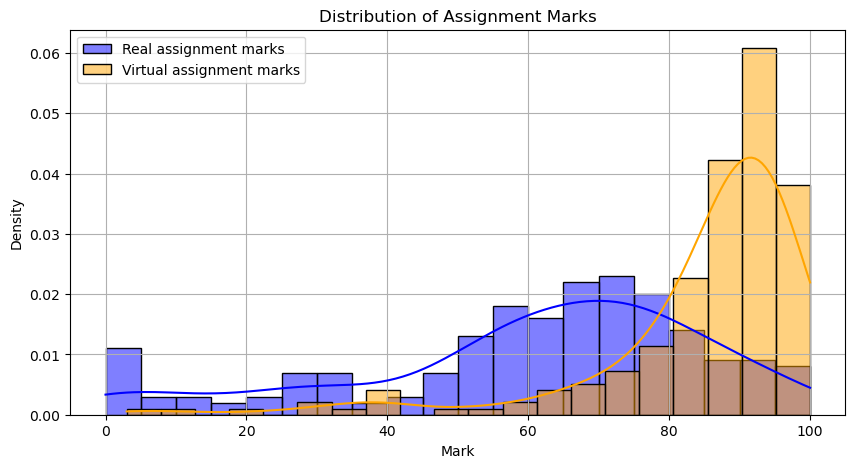

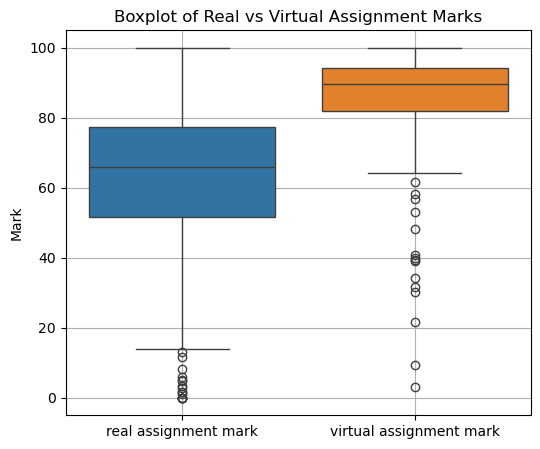

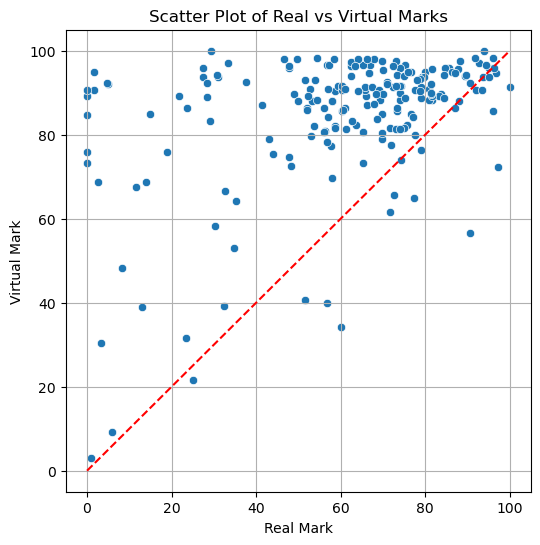

Pearson Correlation: 0.421 (p-value = 5.58e-10)
Paired t-test: t = -14.830, p = 5.29e-34
Mean Absolute Error (MAE): 26.09
Root Mean Squared Error (RMSE): 33.59
Proportion of scores with less than 10 points difference: 24.50%


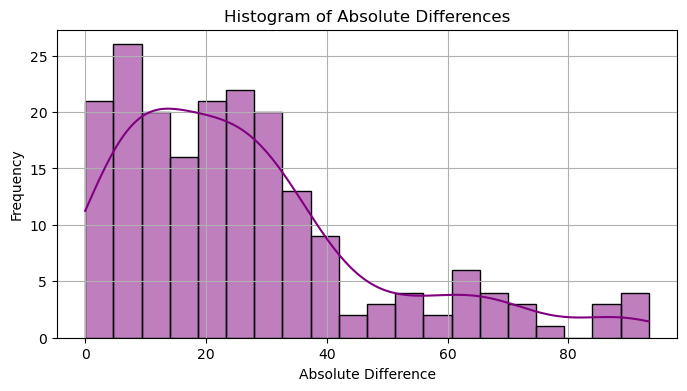

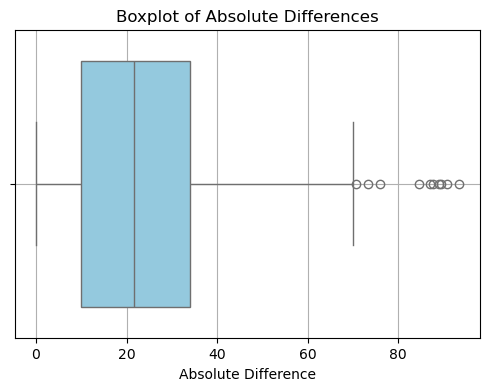

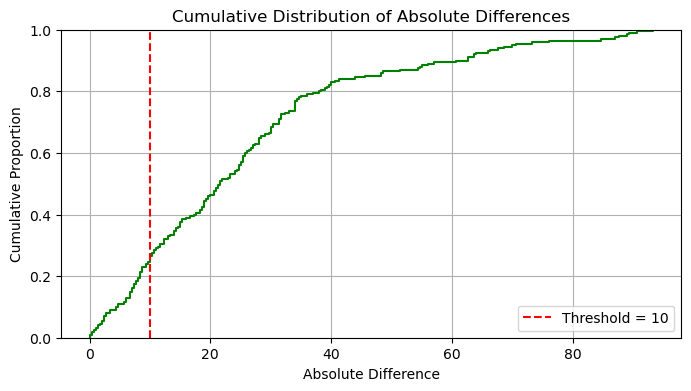

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['real assignment mark'], color='blue', label='Real assignment marks', kde=True, stat="density", bins=20)
sns.histplot(df['virtual assignment mark'], color='orange', label='Virtual assignment marks', kde=True, stat="density", bins=20)
plt.title('Distribution of Assignment Marks')
plt.legend()
plt.xlabel('Mark')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df[['real assignment mark', 'virtual assignment mark']])
plt.title('Boxplot of Real vs Virtual Assignment Marks')
plt.ylabel('Mark')
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='real assignment mark', y='virtual assignment mark', data=df)
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # identity line
plt.title('Scatter Plot of Real vs Virtual Marks')
plt.xlabel('Real Mark')
plt.ylabel('Virtual Mark')
plt.grid(True)
plt.show()

# Pearson correlation
corr_coef, p_corr = pearsonr(df['real assignment mark'], df['virtual assignment mark'])

# Paired t-test
t_stat, p_ttest = ttest_rel(df['real assignment mark'], df['virtual assignment mark'])

# Similarity metrics
mae = mean_absolute_error(df['real assignment mark'], df['virtual assignment mark'])
rmse = np.sqrt(mean_squared_error(df['real assignment mark'], df['virtual assignment mark']))

# Print statistical results
print(f"Pearson Correlation: {corr_coef:.3f} (p-value = {p_corr:.3g})")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_ttest:.3g}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# Calculate absolute differences
differences = abs(df['real assignment mark'] - df['virtual assignment mark'])

# Proportion where difference is less than 10
proportion_under_10 = (differences < 10).mean()

print(f"Proportion of scores with less than 10 points difference: {proportion_under_10:.2%}")


# Plot 1: Histogram of Differences
plt.figure(figsize=(8, 4))
sns.histplot(differences, bins=20, kde=True, color='purple')
plt.title('Histogram of Absolute Differences')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Boxplot of Differences
plt.figure(figsize=(6, 4))
sns.boxplot(x=differences, color='skyblue')
plt.title('Boxplot of Absolute Differences')
plt.xlabel('Absolute Difference')
plt.grid(True)
plt.show()

# Plot 3: Cumulative Distribution Plot
plt.figure(figsize=(8, 4))
sns.ecdfplot(differences, color='green')
plt.axvline(10, color='red', linestyle='--', label='Threshold = 10')
plt.title('Cumulative Distribution of Absolute Differences')
plt.xlabel('Absolute Difference')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

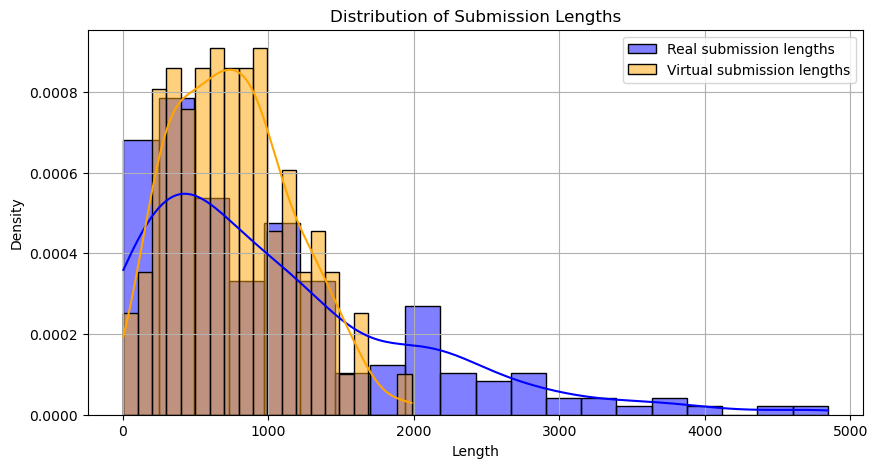

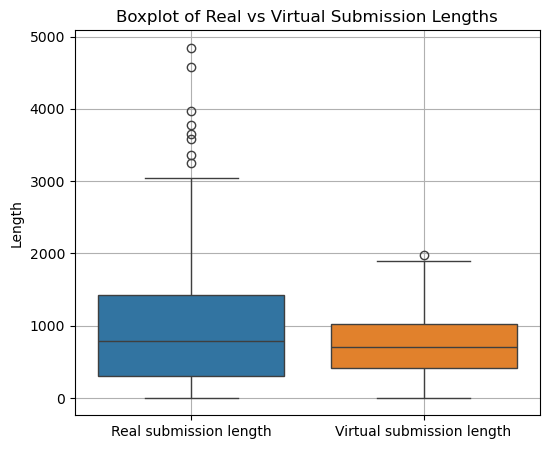

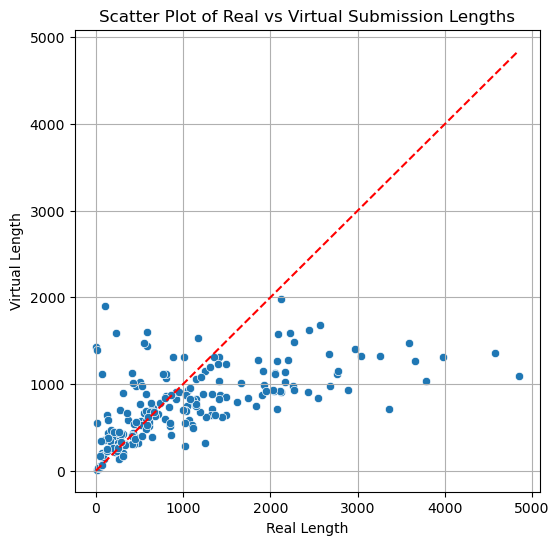

pearsonr Correlation: 0.598 (p-value = 8.24e-21)
Paired t-test: t = 5.350, p = 2.41e-07
Mean Absolute Error (MAE): 524.86
Root Mean Squared Error (RMSE): 829.10
Proportion of submissions with less than 50% difference in length: 55.00%


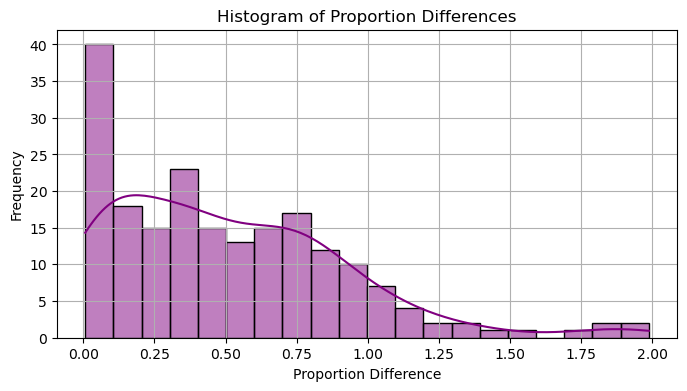

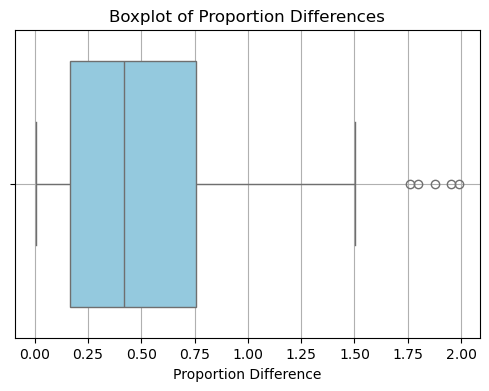

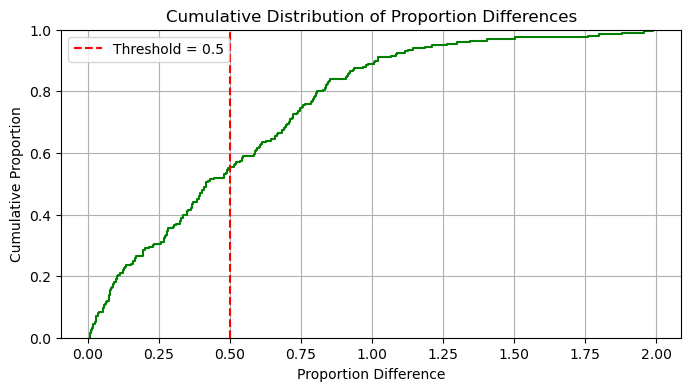


BERT SCORE SEMANTIC SIMILARITY ANALYSIS - STUDENT SUBMISSIONS
Calculating BERT scores for student submissions... (this may take a few minutes)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 56.84 seconds, 3.52 sentences/sec

BERT Score Statistics for Student Submissions:
F1 Score - Mean: 0.8185, Std: 0.0359
Precision - Mean: 0.8119, Std: 0.0406
Recall - Mean: 0.8255, Std: 0.0343

Correlation between BERT F1 and Length Similarity: 0.401 (p-value = 3.98e-09)


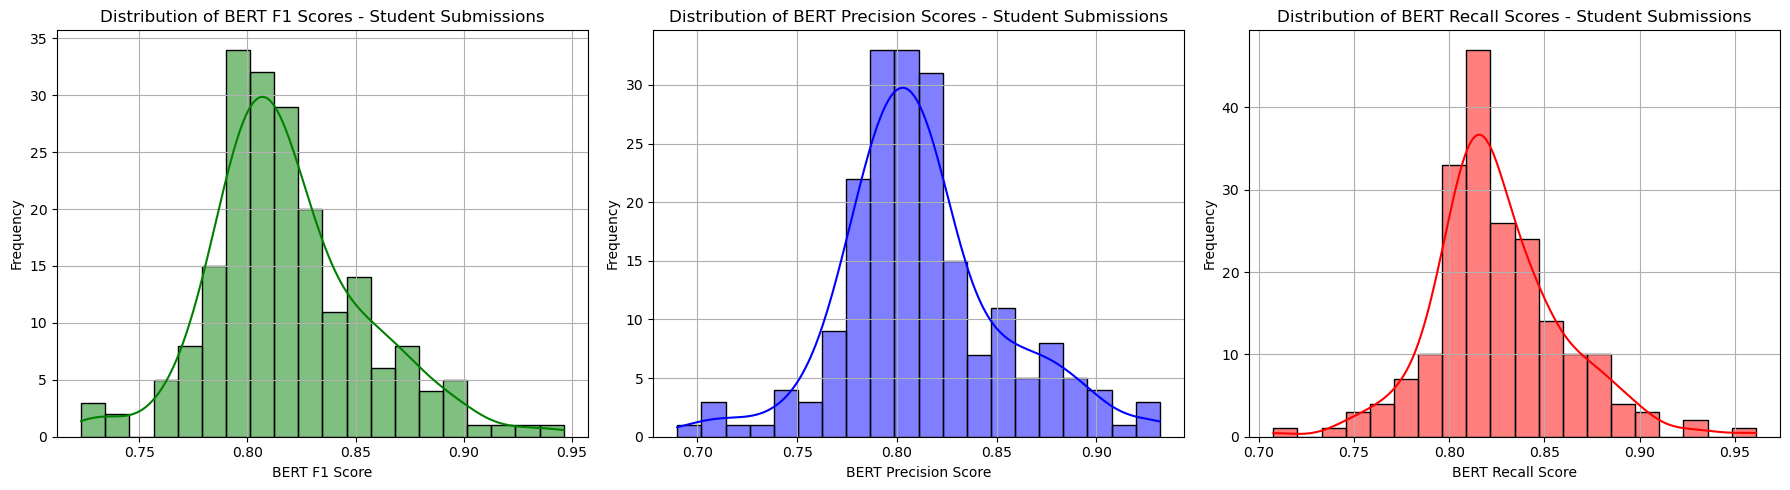

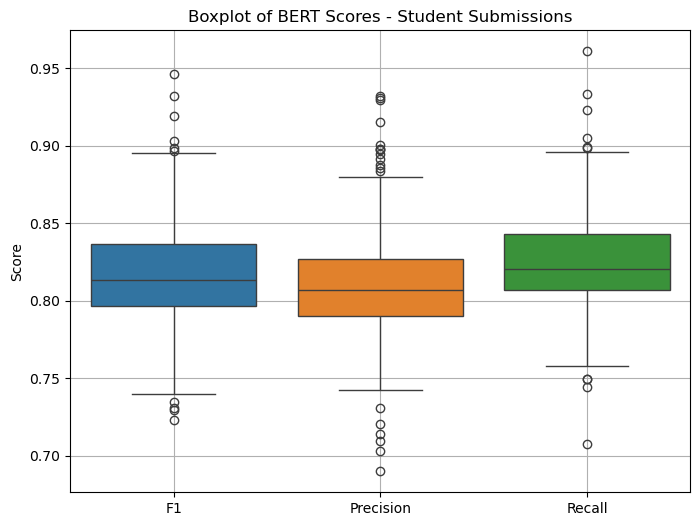

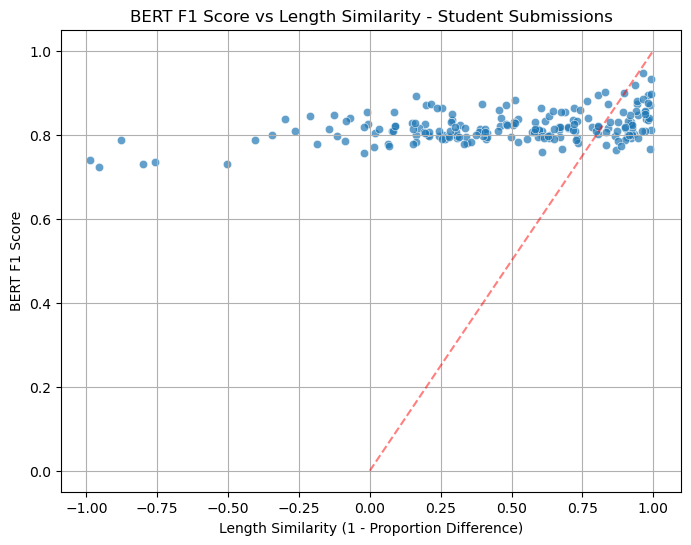

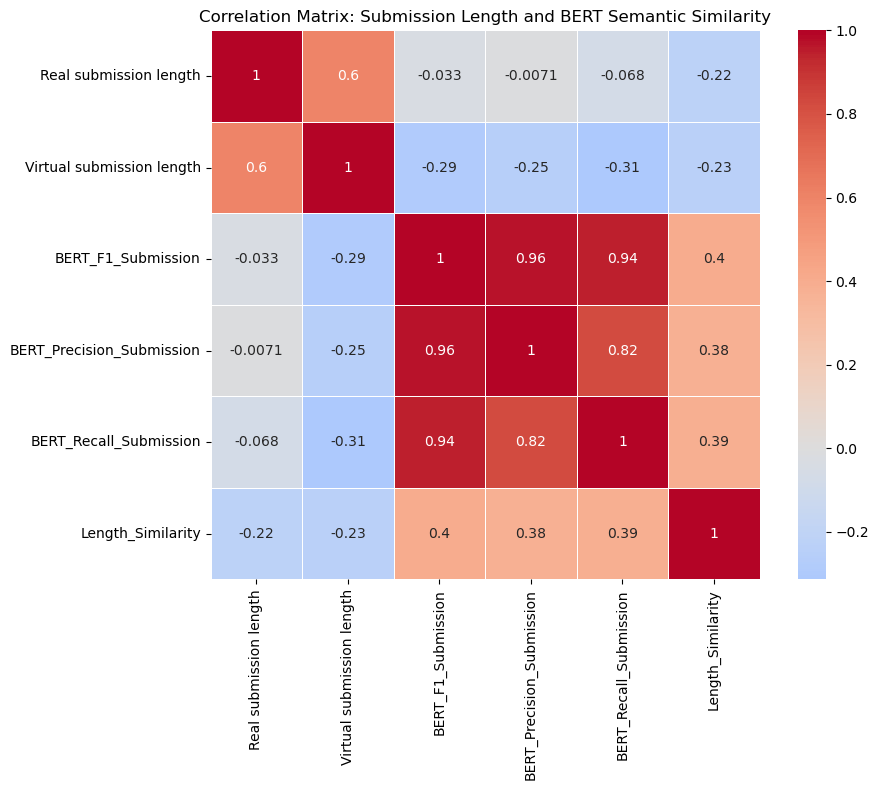

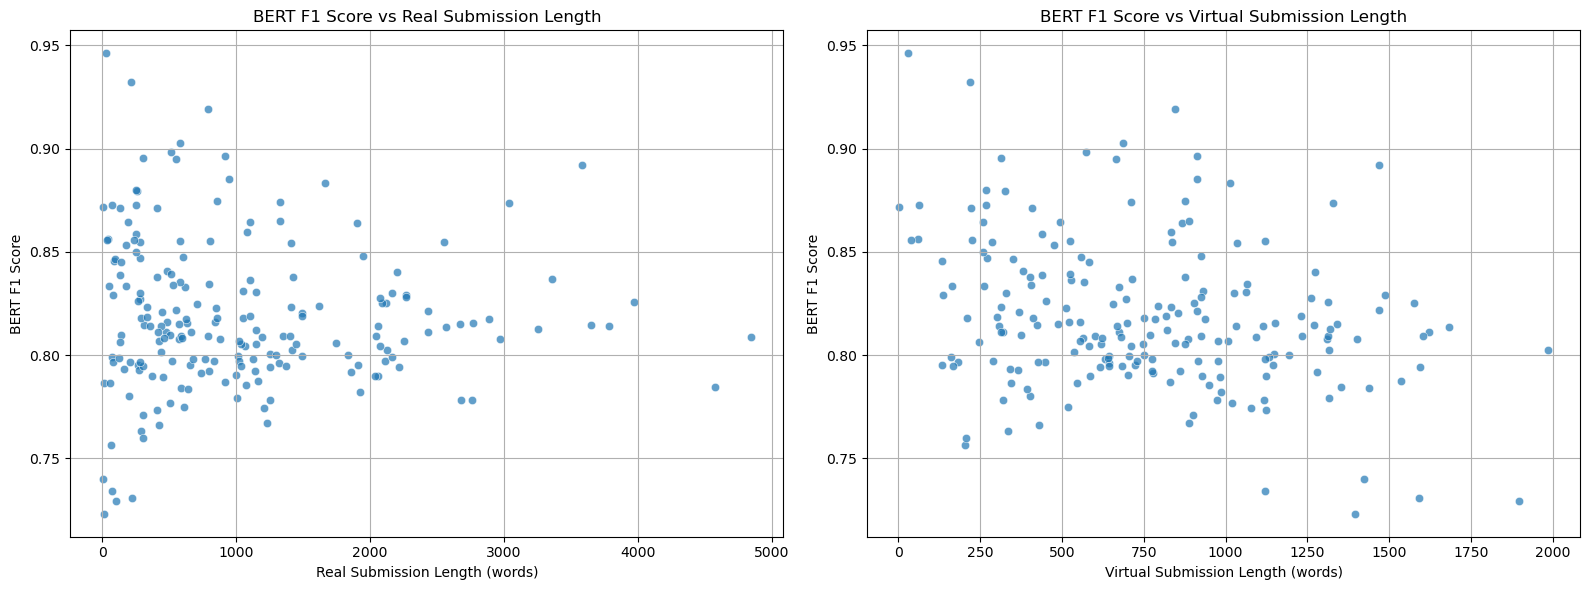

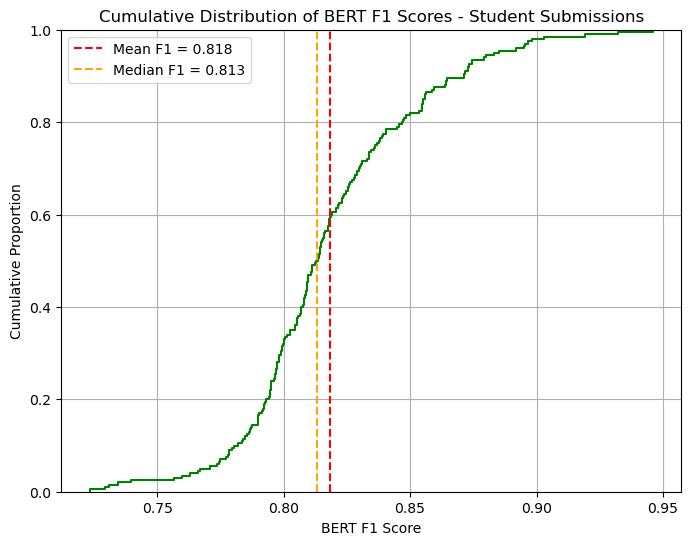


Semantic Similarity Analysis - Student Submissions:
High similarity threshold (75th percentile): 0.836
Low similarity threshold (25th percentile): 0.797
Number of high similarity pairs: 50
Number of low similarity pairs: 50


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

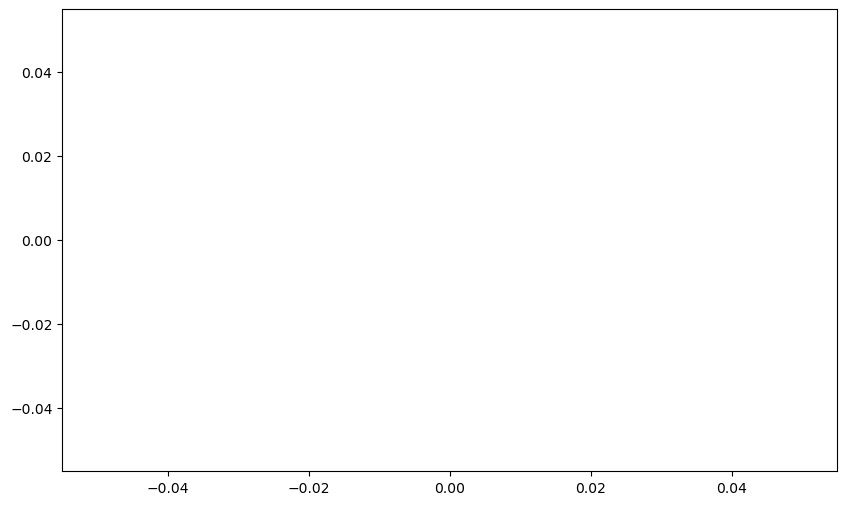

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# For BERT score calculation
from bert_score import score
import torch

def count_words(text):
    return len(text.split())

# Calculate submission lengths
df['Real submission length'] = df['Real student submission'].apply(count_words)
df['Virtual submission length'] = df['Virtual student submission'].apply(count_words)

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['Real submission length'], color='blue', label='Real submission lengths', kde=True, stat="density", bins=20)
sns.histplot(df['Virtual submission length'], color='orange', label='Virtual submission lengths', kde=True, stat="density", bins=20)
plt.title('Distribution of Submission Lengths')
plt.legend()
plt.xlabel('Length')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df[['Real submission length', 'Virtual submission length']])
plt.title('Boxplot of Real vs Virtual Submission Lengths')
plt.ylabel('Length')
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Real submission length', y='Virtual submission length', data=df)
plt.plot([0, df['Real submission length'].max()], [0, df['Real submission length'].max()], color='red', linestyle='--')  # identity line
plt.title('Scatter Plot of Real vs Virtual Submission Lengths')
plt.xlabel('Real Length')
plt.ylabel('Virtual Length')
plt.grid(True)
plt.show()

# Pearson correlation
corr_coef, p_corr = pearsonr(df['Real submission length'], df['Virtual submission length'])

# Paired t-test
t_stat, p_ttest = ttest_rel(df['Real submission length'], df['Virtual submission length'])

# Similarity metrics
mae = mean_absolute_error(df['Real submission length'], df['Virtual submission length'])
rmse = np.sqrt(mean_squared_error(df['Real submission length'], df['Virtual submission length']))

# Print statistical results
print(f"pearsonr Correlation: {corr_coef:.3f} (p-value = {p_corr:.3g})")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_ttest:.3g}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate proportion differences
proportion_differences = abs(df['Real submission length'] - df['Virtual submission length']) / ((df['Real submission length'] + df['Virtual submission length']) / 2)

# Proportion where difference is less than 50%
threshold = 0.5
proportion_under_50_percent = (proportion_differences < threshold).mean()
print(f"Proportion of submissions with less than 50% difference in length: {proportion_under_50_percent:.2%}")

# Plot 1: Histogram of Proportion Differences
plt.figure(figsize=(8, 4))
sns.histplot(proportion_differences, bins=20, kde=True, color='purple')
plt.title('Histogram of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Boxplot of Proportion Differences
plt.figure(figsize=(6, 4))
sns.boxplot(x=proportion_differences, color='skyblue')
plt.title('Boxplot of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.grid(True)
plt.show()

# Plot 3: Cumulative Distribution Plot
plt.figure(figsize=(8, 4))
sns.ecdfplot(proportion_differences, color='green')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.1f}')
plt.title('Cumulative Distribution of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# BERT SCORE SEMANTIC SIMILARITY ANALYSIS FOR STUDENT SUBMISSIONS
# =============================================================================

print("\n" + "="*60)
print("BERT SCORE SEMANTIC SIMILARITY ANALYSIS - STUDENT SUBMISSIONS")
print("="*60)

# Convert to lists for BERT score calculation
real_submissions = df['Real student submission'].tolist()
virtual_submissions = df['Virtual student submission'].tolist()

# Calculate BERT scores
print("Calculating BERT scores for student submissions... (this may take a few minutes)")
P, R, F1 = score(virtual_submissions, real_submissions, lang='en', verbose=True)

# Convert to numpy arrays for easier manipulation
bert_precision = P.numpy()
bert_recall = R.numpy()
bert_f1 = F1.numpy()

# Add BERT scores to dataframe
df['BERT_Precision_Submission'] = bert_precision
df['BERT_Recall_Submission'] = bert_recall
df['BERT_F1_Submission'] = bert_f1

# Print BERT score statistics
print(f"\nBERT Score Statistics for Student Submissions:")
print(f"F1 Score - Mean: {bert_f1.mean():.4f}, Std: {bert_f1.std():.4f}")
print(f"Precision - Mean: {bert_precision.mean():.4f}, Std: {bert_precision.std():.4f}")
print(f"Recall - Mean: {bert_recall.mean():.4f}, Std: {bert_recall.std():.4f}")

# Correlation between BERT F1 and length similarity
length_similarity = 1 - proportion_differences  # Convert difference to similarity
bert_length_corr, bert_length_p = pearsonr(bert_f1, length_similarity)
print(f"\nCorrelation between BERT F1 and Length Similarity: {bert_length_corr:.3f} (p-value = {bert_length_p:.3g})")

# =============================================================================
# BERT SCORE VISUALIZATIONS FOR STUDENT SUBMISSIONS
# =============================================================================

# 1. Distribution of BERT F1 Scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score Distribution
sns.histplot(bert_f1, bins=20, kde=True, color='green', ax=axes[0])
axes[0].set_title('Distribution of BERT F1 Scores - Student Submissions')
axes[0].set_xlabel('BERT F1 Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Precision Distribution
sns.histplot(bert_precision, bins=20, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Distribution of BERT Precision Scores - Student Submissions')
axes[1].set_xlabel('BERT Precision Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Recall Distribution
sns.histplot(bert_recall, bins=20, kde=True, color='red', ax=axes[2])
axes[2].set_title('Distribution of BERT Recall Scores - Student Submissions')
axes[2].set_xlabel('BERT Recall Score')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 2. Boxplot of BERT Scores
plt.figure(figsize=(8, 6))
bert_scores_df = pd.DataFrame({
    'F1': bert_f1,
    'Precision': bert_precision,
    'Recall': bert_recall
})
sns.boxplot(data=bert_scores_df)
plt.title('Boxplot of BERT Scores - Student Submissions')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# 3. Scatter plot: BERT F1 vs Length Similarity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=length_similarity, y=bert_f1, alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', alpha=0.5)  # identity line
plt.title('BERT F1 Score vs Length Similarity - Student Submissions')
plt.xlabel('Length Similarity (1 - Proportion Difference)')
plt.ylabel('BERT F1 Score')
plt.grid(True)
plt.show()

# 4. Correlation matrix heatmap
correlation_data = df[['Real submission length', 'Virtual submission length', 
                      'BERT_F1_Submission', 'BERT_Precision_Submission', 'BERT_Recall_Submission']].copy()
correlation_data['Length_Similarity'] = length_similarity

corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Submission Length and BERT Semantic Similarity')
plt.tight_layout()
plt.show()

# 5. BERT F1 Score vs Submission Length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 vs Real Length
sns.scatterplot(x='Real submission length', y='BERT_F1_Submission', data=df, ax=axes[0], alpha=0.7)
axes[0].set_title('BERT F1 Score vs Real Submission Length')
axes[0].set_xlabel('Real Submission Length (words)')
axes[0].set_ylabel('BERT F1 Score')
axes[0].grid(True)

# F1 vs Virtual Length
sns.scatterplot(x='Virtual submission length', y='BERT_F1_Submission', data=df, ax=axes[1], alpha=0.7)
axes[1].set_title('BERT F1 Score vs Virtual Submission Length')
axes[1].set_xlabel('Virtual Submission Length (words)')
axes[1].set_ylabel('BERT F1 Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 6. Cumulative Distribution of BERT F1 Scores
plt.figure(figsize=(8, 6))
sns.ecdfplot(bert_f1, color='green')
plt.axvline(bert_f1.mean(), color='red', linestyle='--', 
            label=f'Mean F1 = {bert_f1.mean():.3f}')
plt.axvline(np.median(bert_f1), color='orange', linestyle='--', 
            label=f'Median F1 = {np.median(bert_f1):.3f}')
plt.title('Cumulative Distribution of BERT F1 Scores - Student Submissions')
plt.xlabel('BERT F1 Score')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

# 7. High vs Low Semantic Similarity Analysis
high_similarity_threshold = np.percentile(bert_f1, 75)  # Top 25%
low_similarity_threshold = np.percentile(bert_f1, 25)   # Bottom 25%

high_sim_mask = bert_f1 >= high_similarity_threshold
low_sim_mask = bert_f1 <= low_similarity_threshold

print(f"\nSemantic Similarity Analysis - Student Submissions:")
print(f"High similarity threshold (75th percentile): {high_similarity_threshold:.3f}")
print(f"Low similarity threshold (25th percentile): {low_similarity_threshold:.3f}")
print(f"Number of high similarity pairs: {high_sim_mask.sum()}")
print(f"Number of low similarity pairs: {low_sim_mask.sum()}")

# Compare length differences for high vs low semantic similarity
high_sim_length_diff = proportion_differences[high_sim_mask]
low_sim_length_diff = proportion_differences[low_sim_mask]

plt.figure(figsize=(10, 6))
sns.boxplot(data=[high_sim_length_diff, low_sim_length_diff])
plt.xticks([0, 1], ['High Semantic Similarity', 'Low Semantic Similarity'])
plt.ylabel('Length Proportion Difference')
plt.title('Length Differences for High vs Low Semantic Similarity Groups - Student Submissions')
plt.grid(True)
plt.show()

# Statistical test for length differences between high and low semantic similarity groups
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(high_sim_length_diff, low_sim_length_diff, alternative='two-sided')
print(f"Mann-Whitney U test (length diff high vs low semantic similarity): U = {stat:.2f}, p = {p_value:.3g}")

print(f"\nMean length difference - High semantic similarity: {high_sim_length_diff.mean():.3f}")
print(f"Mean length difference - Low semantic similarity: {low_sim_length_diff.mean():.3f}")

# 8. Quality Assessment Based on BERT Scores
# Define quality categories based on BERT F1 scores
excellent_threshold = 0.9
good_threshold = 0.8
fair_threshold = 0.6

excellent_mask = bert_f1 >= excellent_threshold
good_mask = (bert_f1 >= good_threshold) & (bert_f1 < excellent_threshold)
fair_mask = (bert_f1 >= fair_threshold) & (bert_f1 < good_threshold)
poor_mask = bert_f1 < fair_threshold

quality_counts = {
    'Excellent (≥0.9)': excellent_mask.sum(),
    'Good (0.8-0.9)': good_mask.sum(),
    'Fair (0.6-0.8)': fair_mask.sum(),
    'Poor (<0.6)': poor_mask.sum()
}

# Pie chart of quality distribution
plt.figure(figsize=(8, 8))
plt.pie(quality_counts.values(), labels=quality_counts.keys(), autopct='%1.1f%%', 
        colors=['darkgreen', 'green', 'orange', 'red'])
plt.title('Quality Distribution Based on BERT F1 Semantic Similarity\nStudent Submissions')
plt.show()

# 9. Length vs Semantic Quality Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Length distribution by quality category
quality_labels = []
length_data = []
for label, mask in [('Excellent', excellent_mask), ('Good', good_mask), 
                   ('Fair', fair_mask), ('Poor', poor_mask)]:
    if mask.sum() > 0:  # Only include categories with data
        quality_labels.append(label)
        length_data.append(df['Real submission length'][mask])

if length_data:
    axes[0, 0].boxplot(length_data, labels=quality_labels)
    axes[0, 0].set_title('Real Submission Length by Semantic Quality')
    axes[0, 0].set_ylabel('Length (words)')
    axes[0, 0].grid(True)
    axes[0, 0].tick_params(axis='x', rotation=45)

# Virtual submission lengths by quality
virtual_length_data = []
for label, mask in [('Excellent', excellent_mask), ('Good', good_mask), 
                   ('Fair', fair_mask), ('Poor', poor_mask)]:
    if mask.sum() > 0:
        virtual_length_data.append(df['Virtual submission length'][mask])

if virtual_length_data:
    axes[0, 1].boxplot(virtual_length_data, labels=quality_labels)
    axes[0, 1].set_title('Virtual Submission Length by Semantic Quality')
    axes[0, 1].set_ylabel('Length (words)')
    axes[0, 1].grid(True)
    axes[0, 1].tick_params(axis='x', rotation=45)

# Scatter plot with quality color coding
colors = ['red' if score < fair_threshold else 'orange' if score < good_threshold 
          else 'green' if score < excellent_threshold else 'darkgreen' 
          for score in bert_f1]

axes[1, 0].scatter(df['Real submission length'], df['Virtual submission length'], 
                  c=colors, alpha=0.6)
axes[1, 0].plot([0, df['Real submission length'].max()], 
               [0, df['Real submission length'].max()], 'k--', alpha=0.5)
axes[1, 0].set_xlabel('Real Submission Length')
axes[1, 0].set_ylabel('Virtual Submission Length')
axes[1, 0].set_title('Length Comparison Colored by Semantic Quality')
axes[1, 0].grid(True)

# BERT F1 distribution with quality thresholds
axes[1, 1].hist(bert_f1, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(excellent_threshold, color='darkgreen', linestyle='--', 
                  label=f'Excellent (≥{excellent_threshold})')
axes[1, 1].axvline(good_threshold, color='green', linestyle='--', 
                  label=f'Good (≥{good_threshold})')
axes[1, 1].axvline(fair_threshold, color='orange', linestyle='--', 
                  label=f'Fair (≥{fair_threshold})')
axes[1, 1].set_xlabel('BERT F1 Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('BERT F1 Score Distribution with Quality Thresholds')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Final summary
print(f"\n" + "="*60)
print("SUMMARY STATISTICS - STUDENT SUBMISSIONS")
print("="*60)
print(f"Total number of submission pairs: {len(df)}")
print(f"Average BERT F1 semantic similarity: {bert_f1.mean():.3f} ± {bert_f1.std():.3f}")
print(f"Proportion with F1 ≥ 0.9 (excellent similarity): {excellent_mask.mean():.2%}")
print(f"Proportion with F1 ≥ 0.8 (good similarity): {(bert_f1 >= good_threshold).mean():.2%}")
print(f"Proportion with F1 ≥ 0.6 (fair similarity): {(bert_f1 >= fair_threshold).mean():.2%}")
print(f"Proportion with F1 < 0.6 (poor similarity): {poor_mask.mean():.2%}")
print(f"Correlation between semantic and length similarity: {bert_length_corr:.3f}")

# Additional insights
print(f"\nLength Analysis by Semantic Quality:")
for label, mask in [('Excellent', excellent_mask), ('Good', good_mask), 
                   ('Fair', fair_mask), ('Poor', poor_mask)]:
    if mask.sum() > 0:
        mean_length_diff = proportion_differences[mask].mean()
        print(f"{label} semantic quality - Mean length difference: {mean_length_diff:.3f}")

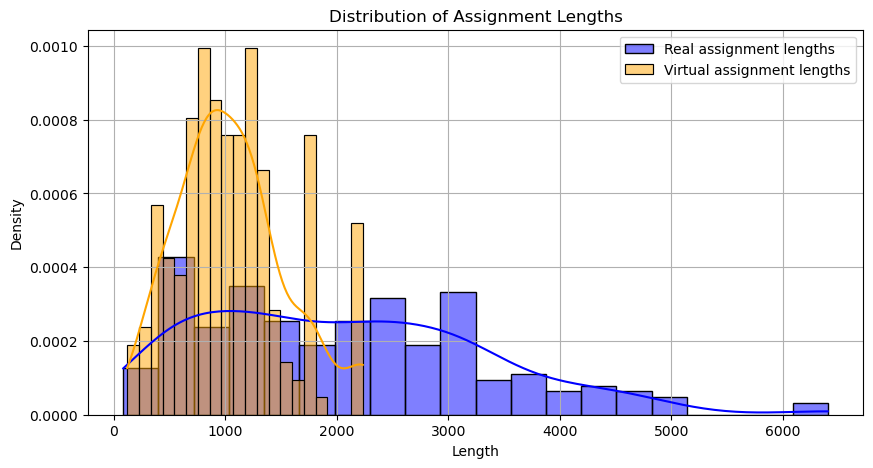

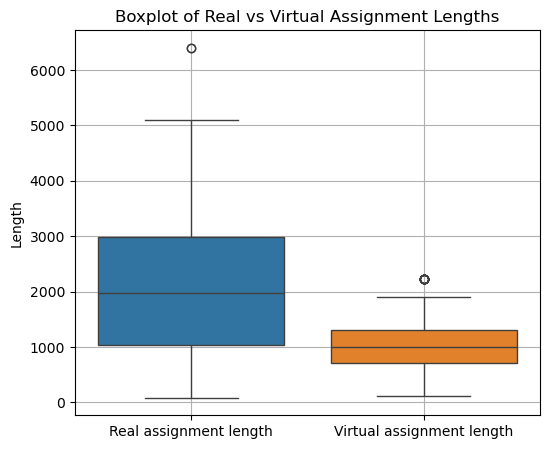

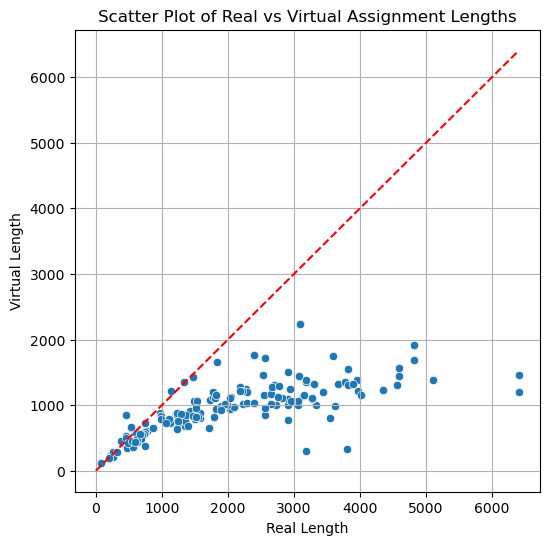

pearsonr Correlation: 0.656 (p-value = 5.41e-26)
Paired t-test: t = 13.930, p = 3.11e-31
Mean Absolute Error (MAE): 1018.21
Root Mean Squared Error (RMSE): 1432.82
Proportion of assignments with less than 10% difference in length: 11.00%


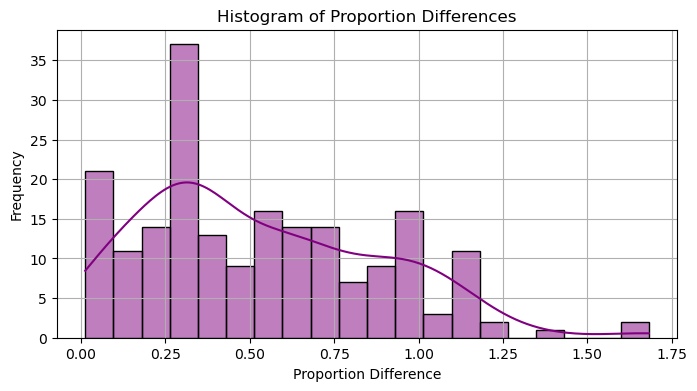

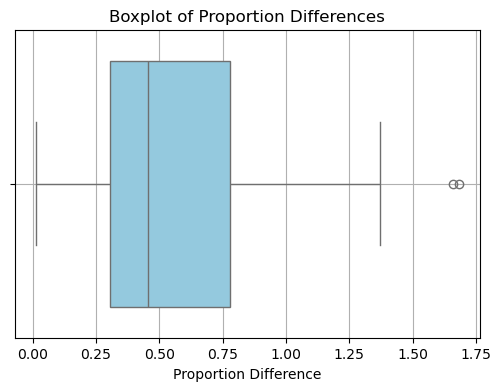

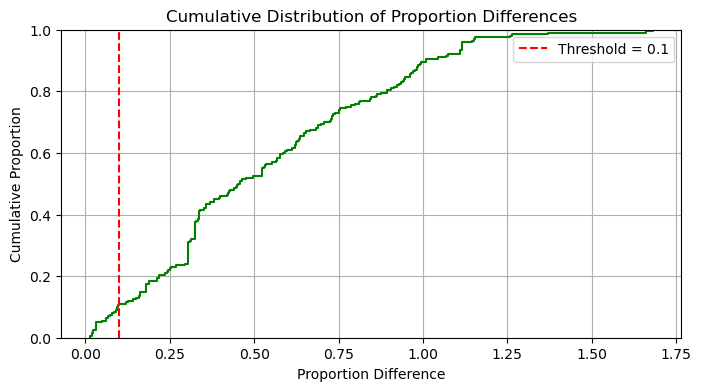


BERT SCORE SEMANTIC SIMILARITY ANALYSIS
Calculating BERT scores... (this may take a few minutes)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 38.63 seconds, 5.18 sentences/sec

BERT Score Statistics:
F1 Score - Mean: 0.8745, Std: 0.0276
Precision - Mean: 0.8689, Std: 0.0284
Recall - Mean: 0.8803, Std: 0.0274

Correlation between BERT F1 and Length Similarity: 0.224 (p-value = 0.0014)


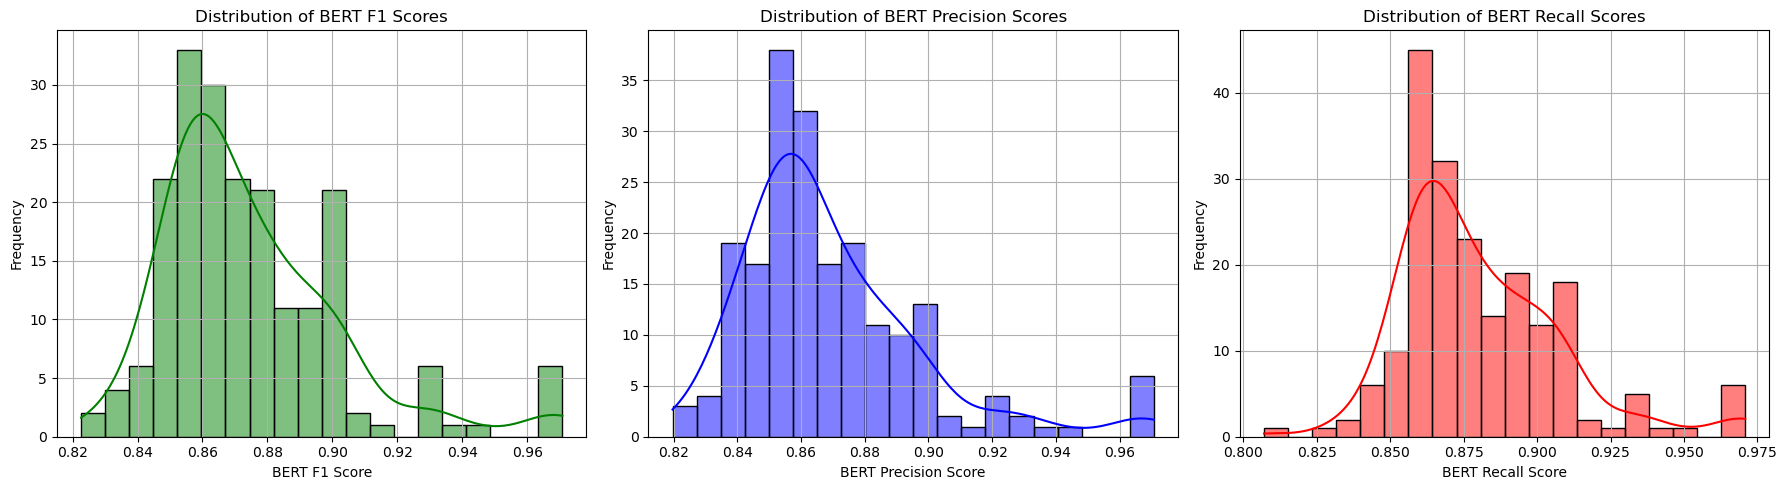

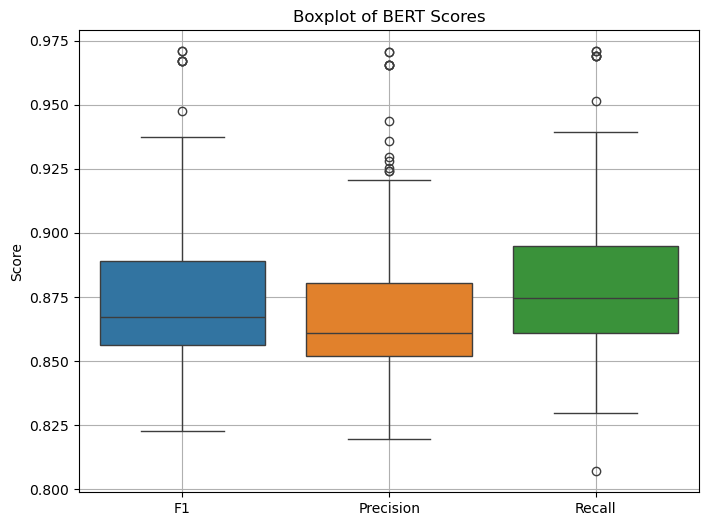

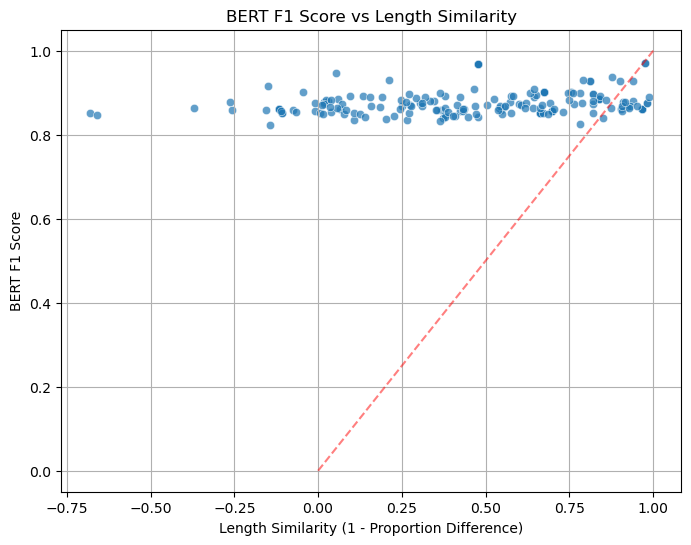

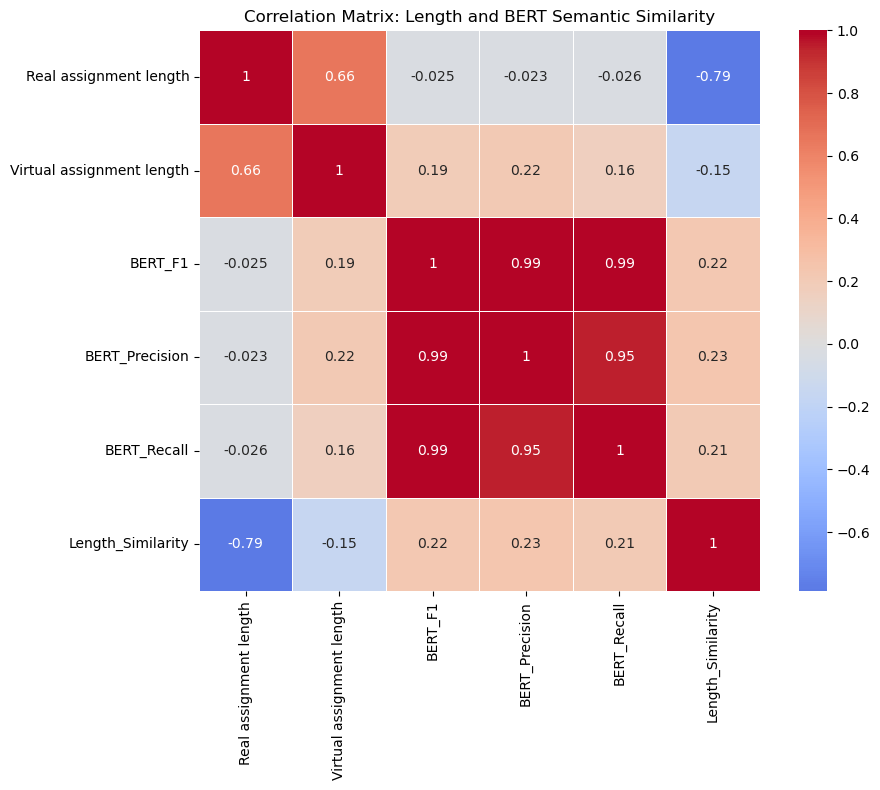

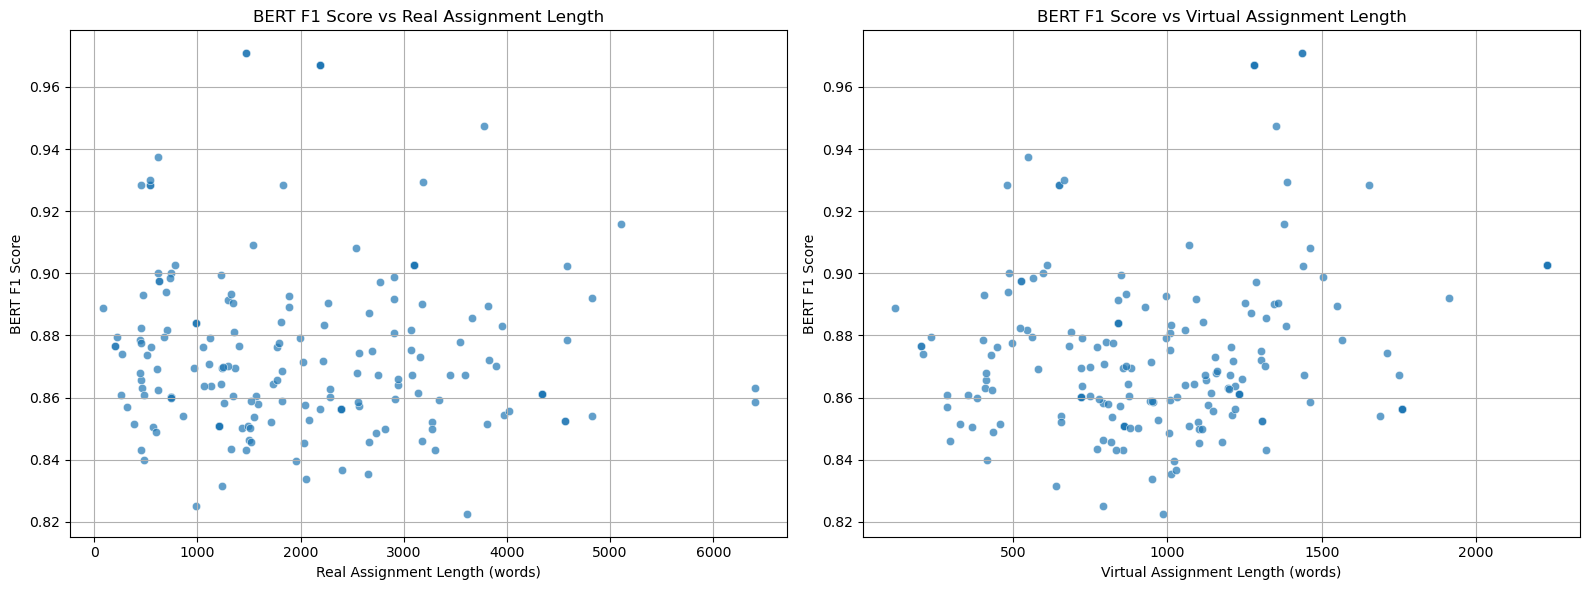

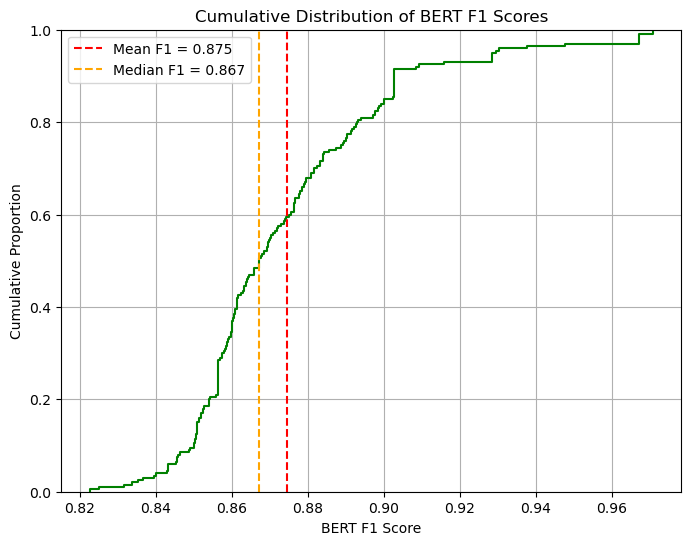


Semantic Similarity Analysis:
High similarity threshold (75th percentile): 0.889
Low similarity threshold (25th percentile): 0.856
Number of high similarity pairs: 50
Number of low similarity pairs: 57


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

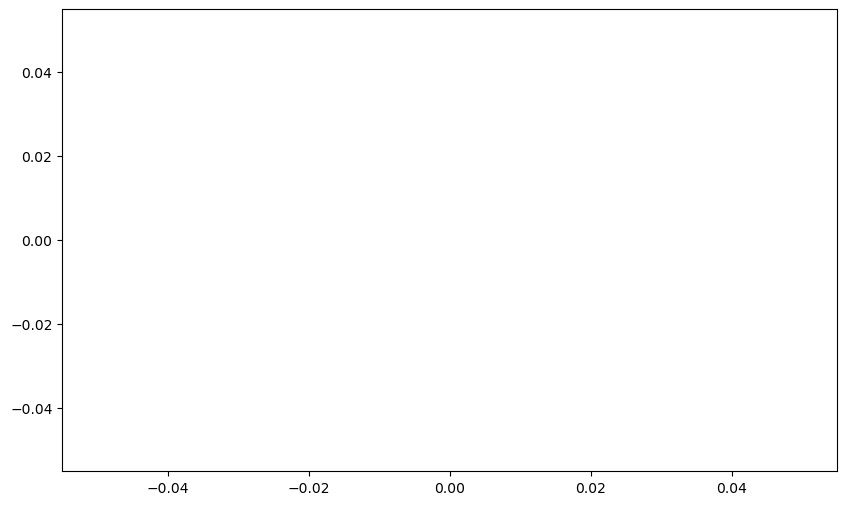

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# For BERT score calculation
from bert_score import score
import torch

def count_words(text):
    return len(text.split())

# Calculate assignment lengths
df['Real assignment length'] = df['Assignment description'].apply(count_words)
df['Virtual assignment length'] = df['Virtual assignment description'].apply(count_words)

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['Real assignment length'], color='blue', label='Real assignment lengths', kde=True, stat="density", bins=20)
sns.histplot(df['Virtual assignment length'], color='orange', label='Virtual assignment lengths', kde=True, stat="density", bins=20)
plt.title('Distribution of Assignment Lengths')
plt.legend()
plt.xlabel('Length')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df[['Real assignment length', 'Virtual assignment length']])
plt.title('Boxplot of Real vs Virtual Assignment Lengths')
plt.ylabel('Length')
plt.grid(True)
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Real assignment length', y='Virtual assignment length', data=df)
plt.plot([0, df['Real assignment length'].max()], [0, df['Real assignment length'].max()], color='red', linestyle='--')  # identity line
plt.title('Scatter Plot of Real vs Virtual Assignment Lengths')
plt.xlabel('Real Length')
plt.ylabel('Virtual Length')
plt.grid(True)
plt.show()

# Pearson correlation
corr_coef, p_corr = pearsonr(df['Real assignment length'], df['Virtual assignment length'])

# Paired t-test
t_stat, p_ttest = ttest_rel(df['Real assignment length'], df['Virtual assignment length'])

# Similarity metrics
mae = mean_absolute_error(df['Real assignment length'], df['Virtual assignment length'])
rmse = np.sqrt(mean_squared_error(df['Real assignment length'], df['Virtual assignment length']))

# Print statistical results
print(f"pearsonr Correlation: {corr_coef:.3f} (p-value = {p_corr:.3g})")
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_ttest:.3g}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate proportion differences
proportion_differences = abs(df['Real assignment length'] - df['Virtual assignment length']) / ((df['Real assignment length'] + df['Virtual assignment length']) / 2)

# Proportion where difference is less than 10%
threshold = 0.1
proportion_under_10_percent = (proportion_differences < threshold).mean()
print(f"Proportion of assignments with less than 10% difference in length: {proportion_under_10_percent:.2%}")

# Plot 1: Histogram of Proportion Differences
plt.figure(figsize=(8, 4))
sns.histplot(proportion_differences, bins=20, kde=True, color='purple')
plt.title('Histogram of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Boxplot of Proportion Differences
plt.figure(figsize=(6, 4))
sns.boxplot(x=proportion_differences, color='skyblue')
plt.title('Boxplot of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.grid(True)
plt.show()

# Plot 3: Cumulative Distribution Plot
plt.figure(figsize=(8, 4))
sns.ecdfplot(proportion_differences, color='green')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.1f}')
plt.title('Cumulative Distribution of Proportion Differences')
plt.xlabel('Proportion Difference')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# BERT SCORE SEMANTIC SIMILARITY ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("BERT SCORE SEMANTIC SIMILARITY ANALYSIS")
print("="*60)

# Convert to lists for BERT score calculation
real_descriptions = df['Assignment description'].tolist()
virtual_descriptions = df['Virtual assignment description'].tolist()

# Calculate BERT scores
print("Calculating BERT scores... (this may take a few minutes)")
P, R, F1 = score(virtual_descriptions, real_descriptions, lang='en', verbose=True)

# Convert to numpy arrays for easier manipulation
bert_precision = P.numpy()
bert_recall = R.numpy()
bert_f1 = F1.numpy()

# Add BERT scores to dataframe
df['BERT_Precision'] = bert_precision
df['BERT_Recall'] = bert_recall
df['BERT_F1'] = bert_f1

# Print BERT score statistics
print(f"\nBERT Score Statistics:")
print(f"F1 Score - Mean: {bert_f1.mean():.4f}, Std: {bert_f1.std():.4f}")
print(f"Precision - Mean: {bert_precision.mean():.4f}, Std: {bert_precision.std():.4f}")
print(f"Recall - Mean: {bert_recall.mean():.4f}, Std: {bert_recall.std():.4f}")

# Correlation between BERT F1 and length similarity
length_similarity = 1 - proportion_differences  # Convert difference to similarity
bert_length_corr, bert_length_p = pearsonr(bert_f1, length_similarity)
print(f"\nCorrelation between BERT F1 and Length Similarity: {bert_length_corr:.3f} (p-value = {bert_length_p:.3g})")

# =============================================================================
# BERT SCORE VISUALIZATIONS
# =============================================================================

# 1. Distribution of BERT F1 Scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score Distribution
sns.histplot(bert_f1, bins=20, kde=True, color='green', ax=axes[0])
axes[0].set_title('Distribution of BERT F1 Scores')
axes[0].set_xlabel('BERT F1 Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Precision Distribution
sns.histplot(bert_precision, bins=20, kde=True, color='blue', ax=axes[1])
axes[1].set_title('Distribution of BERT Precision Scores')
axes[1].set_xlabel('BERT Precision Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Recall Distribution
sns.histplot(bert_recall, bins=20, kde=True, color='red', ax=axes[2])
axes[2].set_title('Distribution of BERT Recall Scores')
axes[2].set_xlabel('BERT Recall Score')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 2. Boxplot of BERT Scores
plt.figure(figsize=(8, 6))
bert_scores_df = pd.DataFrame({
    'F1': bert_f1,
    'Precision': bert_precision,
    'Recall': bert_recall
})
sns.boxplot(data=bert_scores_df)
plt.title('Boxplot of BERT Scores')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# 3. Scatter plot: BERT F1 vs Length Similarity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=length_similarity, y=bert_f1, alpha=0.7)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', alpha=0.5)  # identity line
plt.title('BERT F1 Score vs Length Similarity')
plt.xlabel('Length Similarity (1 - Proportion Difference)')
plt.ylabel('BERT F1 Score')
plt.grid(True)
plt.show()

# 4. Correlation matrix heatmap
correlation_data = df[['Real assignment length', 'Virtual assignment length', 
                      'BERT_F1', 'BERT_Precision', 'BERT_Recall']].copy()
correlation_data['Length_Similarity'] = length_similarity

corr_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Length and BERT Semantic Similarity')
plt.tight_layout()
plt.show()

# 5. BERT F1 Score vs Assignment Length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 vs Real Length
sns.scatterplot(x='Real assignment length', y='BERT_F1', data=df, ax=axes[0], alpha=0.7)
axes[0].set_title('BERT F1 Score vs Real Assignment Length')
axes[0].set_xlabel('Real Assignment Length (words)')
axes[0].set_ylabel('BERT F1 Score')
axes[0].grid(True)

# F1 vs Virtual Length
sns.scatterplot(x='Virtual assignment length', y='BERT_F1', data=df, ax=axes[1], alpha=0.7)
axes[1].set_title('BERT F1 Score vs Virtual Assignment Length')
axes[1].set_xlabel('Virtual Assignment Length (words)')
axes[1].set_ylabel('BERT F1 Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 6. Cumulative Distribution of BERT F1 Scores
plt.figure(figsize=(8, 6))
sns.ecdfplot(bert_f1, color='green')
plt.axvline(bert_f1.mean(), color='red', linestyle='--', 
            label=f'Mean F1 = {bert_f1.mean():.3f}')
plt.axvline(np.median(bert_f1), color='orange', linestyle='--', 
            label=f'Median F1 = {np.median(bert_f1):.3f}')
plt.title('Cumulative Distribution of BERT F1 Scores')
plt.xlabel('BERT F1 Score')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(True)
plt.show()

# 7. High vs Low Semantic Similarity Analysis
high_similarity_threshold = np.percentile(bert_f1, 75)  # Top 25%
low_similarity_threshold = np.percentile(bert_f1, 25)   # Bottom 25%

high_sim_mask = bert_f1 >= high_similarity_threshold
low_sim_mask = bert_f1 <= low_similarity_threshold

print(f"\nSemantic Similarity Analysis:")
print(f"High similarity threshold (75th percentile): {high_similarity_threshold:.3f}")
print(f"Low similarity threshold (25th percentile): {low_similarity_threshold:.3f}")
print(f"Number of high similarity pairs: {high_sim_mask.sum()}")
print(f"Number of low similarity pairs: {low_sim_mask.sum()}")

# Compare length differences for high vs low semantic similarity
high_sim_length_diff = proportion_differences[high_sim_mask]
low_sim_length_diff = proportion_differences[low_sim_mask]

plt.figure(figsize=(10, 6))
sns.boxplot(data=[high_sim_length_diff, low_sim_length_diff])
plt.xticks([0, 1], ['High Semantic Similarity', 'Low Semantic Similarity'])
plt.ylabel('Length Proportion Difference')
plt.title('Length Differences for High vs Low Semantic Similarity Groups')
plt.grid(True)
plt.show()

# Statistical test for length differences between high and low semantic similarity groups
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(high_sim_length_diff, low_sim_length_diff)
print(f"Mann-Whitney U test (length diff high vs low semantic similarity): U = {stat:.2f}, p = {p_value:.3g}")

print(f"\nMean length difference - High semantic similarity: {high_sim_length_diff.mean():.3f}")
print(f"Mean length difference - Low semantic similarity: {low_sim_length_diff.mean():.3f}")

# Final summary
print(f"\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Total number of assignment pairs: {len(df)}")
print(f"Average BERT F1 semantic similarity: {bert_f1.mean():.3f} ± {bert_f1.std():.3f}")
print(f"Proportion with F1 > 0.8 (high similarity): {(bert_f1 > 0.8).mean():.2%}")
print(f"Proportion with F1 < 0.6 (low similarity): {(bert_f1 < 0.6).mean():.2%}")
print(f"Correlation between semantic and length similarity: {bert_length_corr:.3f}")

In [53]:
mimicry = df
mimicry.to_csv('../Data/FIT2021 S1/mimicry_resemblance.csv', index=False)